In [1]:
import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx

from utils.visualization_utils import *


%matplotlib inline

#filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/FlatPt/CloseByGamma0PU/ntuples_10_600/new_ntuples_15043323_86.root"
#filename = '/eos/home-j/jejarosl/test_sample_pion140pu/new_ntuples_15459280_525.root'
#filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/GNNTraining/SingleGamma140PU/ntuples_10_600/new_ntuples_15459279_533.root"
filename = "/eos/home-j/jejarosl/histo_2gammas_CloseBydeltaT.root"
#filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/CMSSW_13_X/GNNTraining/CloseByPion0PU/ntuples_10_600/new_ntuples_15643818_42.root"

In [2]:
 file = uproot.open(filename)

In [3]:
file.keys()

['ticlNtuplizer;1',
 'ticlNtuplizer/tracksters;1',
 'ticlNtuplizer/clusters;1',
 'ticlNtuplizer/graph;1',
 'ticlNtuplizer/candidates;1',
 'ticlNtuplizer/trackstersMerged;1',
 'ticlNtuplizer/associations;1',
 'ticlNtuplizer/simtrackstersSC;1',
 'ticlNtuplizer/simtrackstersCP;1',
 'ticlNtuplizer/fineSimTracksters;1',
 'ticlNtuplizer/tracks;1',
 'ticlNtuplizer/simTICLCandidate;1']

In [4]:
tracks = file["ticlNtuplizer/tracks"]
tracksters = file["ticlNtuplizer/tracksters"]
simtracksters = file["ticlNtuplizer/simtrackstersSC"]
simtrackstersCP = file["ticlNtuplizer/simtrackstersCP"]
ass = file["ticlNtuplizer/associations"]
gra = file["ticlNtuplizer/graph"]
cand = file["ticlNtuplizer/candidates"]
lc = file["ticlNtuplizer/clusters"]

In [5]:
lc.keys()

['seedID',
 'energy',
 'correctedEnergy',
 'correctedEnergyUncertainty',
 'position_x',
 'position_y',
 'position_z',
 'position_eta',
 'position_phi',
 'cluster_layer_id',
 'cluster_type',
 'cluster_time',
 'cluster_timeErr',
 'cluster_local_density',
 'cluster_radius',
 'cluster_number_of_hits']

In [6]:
trk_data = tracksters.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y",
                              "barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3",
                              "vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "vertices_x", "vertices_y",
                              "vertices_z", "vertices_energy", "layer_cluster_seed"])
gra_data = gra.arrays(["linked_inners", "linked_outers"])
ass_data = ass.arrays(["tsCLUE3D_recoToSim_SC", "tsCLUE3D_recoToSim_SC_score",
                       "tsCLUE3D_simToReco_SC", "tsCLUE3D_simToReco_SC_score",
                       "tsCLUE3D_simToReco_SC_sharedE", "tsCLUE3D_recoToSim_SC_sharedE"])

cand_data = cand.arrays(["tracksters_in_candidate"])
lc_data = lc.arrays(['position_x', 'position_y', 'position_z', 'energy'])
try:
    simtrackstersSC_data = simtracksters.arrays(["stsSC_raw_energy", 'stsSC_boundaryPx', 'stsSC_boundaryPy', 'stsSC_boundaryPz'])
    simtrackstersCP_data = simtrackstersCP.arrays(["stsCP_raw_energy", 'stsCP_boundaryPx', 'stsCP_boundaryPy', 'stsCP_boundaryPz'])
    
except Exception:
    simtrackstersSC_data = simtracksters.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz'])
    simtrackstersCP_data = simtrackstersCP.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz'])

In [7]:
def get_major_PU_tracksters(
    reco2sim,
    sim_raw_energy,
    score_threshold=0.2,
    energy_fraction_threshold=0.3
):
    # assuming only one simtrackster to keep things easy
    big = []

    for recoT_idx, (sim_indexes, shared_energies, scores) in enumerate(reco2sim):
        for simT_idx, shared_energy, score in zip(sim_indexes, shared_energies, scores):
            # 2 goals here:
            # - find the trackster with >50% shared energy
            # - find the tracksters with < 0.2 score
            if score > score_threshold: continue
            
            st_energy = sim_raw_energy[simT_idx]
            st_fraction = shared_energy / st_energy
            
            if st_fraction > energy_fraction_threshold:
                big.append(recoT_idx)

    return big

1314


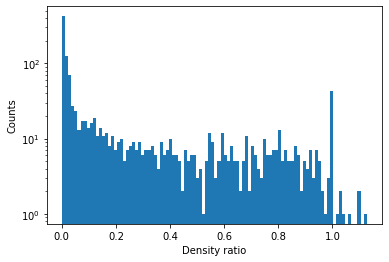

In [8]:
# make histogram on 20 events, make ration between the seed density and the rest
fig = plt.figure()
num_lc = 0
density = []
for ev in range(20):
    reco2sim_index = ass_data[ev].tsCLUE3D_recoToSim_SC
    reco2sim_score = ass_data[ev].tsCLUE3D_recoToSim_SC_score
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    try:
        sim_raw_energy = simtrackstersSC_data[ev].stsSC_raw_energy
    except Exception:
        sim_raw_energy = simtrackstersSC_data[ev].raw_energy
    
    bigTracksters = get_major_PU_tracksters(
        zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
        sim_raw_energy,
        )
    #print(bigTracksters)
    
    # find index of lcs belonging to major tracksters
    for bT in bigTracksters:
        vi_big = trk_data[ev].vertices_indexes[bT]
        seed_lc_idx = trk_data[ev].layer_cluster_seed[bT]
    
        ev_density = list(lc["energy"].array()[ev][vi_big]) #list(lc["cluster_local_density"].array()[ev][vi_big])
        #print(seed_lc_idx)
        seed_density = lc["energy"].array()[ev][seed_lc_idx]
    
        max_density = max(ev_density)
        density = density + list(np.array(ev_density) / seed_density)
        num_lc += len(ev_density)
    
final_density = np.clip(np.array(density).flatten(), 0, 1000)
#print(final_density)
plt.hist(final_density, bins=100)

plt.xlabel('Density ratio')
plt.ylabel('Counts')
plt.yscale('log')
print(num_lc)
plt.show()

1314


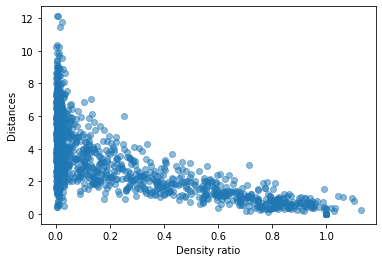

In [9]:
# same thing, not as a histogram, but distance between the seed and the lc
fig = plt.figure()
num_lc = 0
density, distances = [], []
for ev in range(20):
    reco2sim_index = ass_data[ev].tsCLUE3D_recoToSim_SC
    reco2sim_score = ass_data[ev].tsCLUE3D_recoToSim_SC_score
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    try:
        sim_raw_energy = simtrackstersSC_data[ev].stsSC_raw_energy
    except Exception:
        sim_raw_energy = simtrackstersSC_data[ev].raw_energy
    
    bigTracksters = get_major_PU_tracksters(
        zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
        sim_raw_energy,
        )
    #print(bigTracksters)
    
    # find index of lcs belonging to major tracksters
    for bT in bigTracksters:
        vi_big = trk_data[ev].vertices_indexes[bT]
        seed_lc_idx = trk_data[ev].layer_cluster_seed[bT]
        
        # distance in x-y plane
        pos_x = lc["position_x"].array()[ev][vi_big]
        pos_y = lc["position_y"].array()[ev][vi_big]
        pos_z = lc["position_z"].array()[ev][vi_big]
        
        pos_seed_x = lc["position_x"].array()[ev][seed_lc_idx]
        pos_seed_y = lc["position_y"].array()[ev][seed_lc_idx]
        pos_seed_z = lc["position_z"].array()[ev][seed_lc_idx]
    
        dist = np.sqrt((np.array(pos_x)-np.array(pos_seed_x))**2 + (np.array(pos_y)-np.array(pos_seed_y))**2)
    
        ev_density = list(lc["energy"].array()[ev][vi_big]) #list(lc["cluster_local_density"].array()[ev][vi_big])
        #print(seed_lc_idx)
        seed_density = lc["energy"].array()[ev][seed_lc_idx]
    
        max_density = max(ev_density)
        density = density + list(np.array(ev_density) / seed_density)
        distances = distances + list(dist)
        num_lc += len(ev_density)
    
final_density = np.clip(np.array(density).flatten(), 0, 1000)
#print(final_density)
plt.scatter(final_density, distances, alpha=0.5)

plt.xlabel('Density ratio')
plt.ylabel('Distances')
#plt.yscale('log')
print(num_lc)
plt.show()

1314


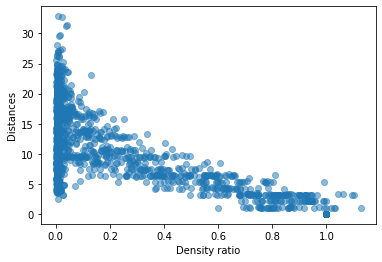

In [10]:
# same thing, not as a histogram, but distance between the seed and the lc
fig = plt.figure()
num_lc = 0
density, distances = [], []
for ev in range(20):
    reco2sim_index = ass_data[ev].tsCLUE3D_recoToSim_SC
    reco2sim_score = ass_data[ev].tsCLUE3D_recoToSim_SC_score
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    try:
        sim_raw_energy = simtrackstersSC_data[ev].stsSC_raw_energy
    except Exception:
        sim_raw_energy = simtrackstersSC_data[ev].raw_energy
    
    bigTracksters = get_major_PU_tracksters(
        zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
        sim_raw_energy,
        )
    #print(bigTracksters)
    
    # find index of lcs belonging to major tracksters
    for bT in bigTracksters:
        vi_big = trk_data[ev].vertices_indexes[bT]
        seed_lc_idx = trk_data[ev].layer_cluster_seed[bT]
        
        # distance in x-y plane
        pos_x = lc["position_x"].array()[ev][vi_big]
        pos_y = lc["position_y"].array()[ev][vi_big]
        pos_z = lc["position_z"].array()[ev][vi_big]
        
        pos_seed_x = lc["position_x"].array()[ev][seed_lc_idx]
        pos_seed_y = lc["position_y"].array()[ev][seed_lc_idx]
        pos_seed_z = lc["position_z"].array()[ev][seed_lc_idx]
    
        dist = np.sqrt((np.array(pos_x)-np.array(pos_seed_x))**2 + (np.array(pos_y)-np.array(pos_seed_y))**2 
                       + (np.array(pos_z)-np.array(pos_seed_z))**2)
    
        ev_density = list(lc["energy"].array()[ev][vi_big]) #list(lc["cluster_local_density"].array()[ev][vi_big])
        #print(seed_lc_idx)
        seed_density = lc["energy"].array()[ev][seed_lc_idx]
    
        max_density = max(ev_density)
        density = density + list(np.array(ev_density) / seed_density)
        distances = distances + list(dist)
        num_lc += len(ev_density)
    
final_density = np.clip(np.array(density).flatten(), 0, 1000)
#print(final_density)
plt.scatter(final_density, distances, alpha=0.5)

plt.xlabel('Density ratio')
plt.ylabel('Distances')
#plt.yscale('log')
print(num_lc)
plt.show()

In [11]:
vx = trk_data.vertices_x
vy = trk_data.vertices_y
vz = trk_data.vertices_z
ve = trk_data.vertices_energy
vi = trk_data.vertices_indexes

try:
    vx_sim = simtracksters["stsSC_vertices_x"].array()
    vy_sim = simtracksters["stsSC_vertices_y"].array()
    vz_sim = simtracksters["stsSC_vertices_z"].array()
    ve_sim = simtracksters["stsSC_vertices_energy"].array()
except Exception:
    vx_sim = simtracksters["vertices_x"].array()
    vy_sim = simtracksters["vertices_y"].array()
    vz_sim = simtracksters["vertices_z"].array()
    ve_sim = simtracksters["vertices_energy"].array()

bx = trk_data.barycenter_x
by = trk_data.barycenter_y
bz = trk_data.barycenter_z
be = trk_data.raw_energy

try:
    bx_sim = simtracksters["stsSC_barycenter_x"].array()
    by_sim = simtracksters["stsSC_barycenter_y"].array()
    bz_sim = simtracksters["stsSC_barycenter_z"].array()
    be_sim = simtracksters["stsSC_raw_energy"].array()
except Exception:
    bx_sim = simtracksters["barycenter_x"].array()
    by_sim = simtracksters["barycenter_y"].array()
    bz_sim = simtracksters["barycenter_z"].array()
    be_sim = simtracksters["raw_energy"].array()

In [12]:
reco2sim_index = ass_data.tsCLUE3D_recoToSim_SC
reco2sim_score = ass_data.tsCLUE3D_recoToSim_SC_score
reco2sim_sharedE = ass_data.tsCLUE3D_recoToSim_SC_sharedE
try:
    sim_raw_energy = simtrackstersSC_data.stsSC_raw_energy
except Exception:
    sim_raw_energy = simtrackstersSC_data.raw_energy

In [13]:
ev = 0

bigTracksters = get_major_PU_tracksters(
    zip(reco2sim_index[ev], reco2sim_sharedE[ev], reco2sim_score[ev]),
    sim_raw_energy[ev],
)

In [14]:
bigTracksters

[0, 1]

In [15]:
def find_dist_to_closest_edge(point, edges, far=False):
    """
    point: np.array (x,y,z)
    edges: dictionary
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    closest_endpoint_id = None
    
    for edge, (segment_start, segment_end) in edges.items():
        
        if far: 
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp, far_endpoint, far_endpoint_id = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        else:
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        
        if dist < min_dist:
            min_dist = dist
            min_edge = edge
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            closest_endpoint_id = closest_endpoint_id_tmp
        
    if far:
        return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
            
    return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id

def distance_point_to_segment(point, segment_start, segment_end, edge, far=False):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        if far:
            return np.linalg.norm(point_vector), segment_start, segment_start, edge[0], segment_end, edge[1] 
        return np.linalg.norm(point_vector), segment_start, segment_start, edge[0]
    elif projection > 1:
        if far:
             return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1], segment_start, edge[0]
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1]
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        closest_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else edge[1]
        
        if far:
            far_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else segment_end
            far_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else edge[1]
            return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id
    
def explored_nodes_affected(nodes, edges, DST_threshold):
    for n, point in nodes.items():
        # go through all explored nodes
        # go through all edges
        min_dist = np.inf
        for edge, (segment_start, segment_end) in edges.items():
        
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge)
            # find minimal distance
            if dist < min_dist:
                min_dist = dist
                
        # check that minimal distance is lower than the threshold
        if min_dist > DST_threshold:
            return True
        
    return False

def closer_to_seed(point, closest_endpoint, seed_coord):
    if np.linalg.norm(point - seed_coord) <  np.linalg.norm(closest_endpoint - seed_coord):
        return True
    return False

In [16]:
def project_lc_to_pca(point, segment_start, segment_end):
    """
    `lc` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    #print(segment_vector)
    point_vector = point - segment_start
    #print(point_vector)
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    closest_point = segment_start + projection * segment_vector
    return np.linalg.norm(point - closest_point), closest_point

In [17]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [18]:
def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [19]:
!pip install wpca
from wpca import WPCA, EMPCA

Defaulting to user installation because normal site-packages is not writeable


In [20]:
def create_graph(lc_data, vx, vy, vz, ve, vi, ev=0, DST_threshold=2, ANGLE_THR = 1.5, MAX_ITER=None, sort_by_z = False):
    all_edges = []
    all_nodes = []
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]

    bubble_size = 10
    pileup_alpha = 0.5
    noise_threshold = 0.2

    for bigT in bigTracksters:

        vxt = vx[ev][bigT]
        vyt = vy[ev][bigT]
        vzt = vz[ev][bigT]
        vet = ve[ev][bigT]
        vit = vi[ev][bigT]
        edges, nodes = {}, {}

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
        seed_lc_idx = trk_data.layer_cluster_seed[ev][bigT]
        ax.scatter(lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx], s=lce[seed_lc_idx]*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        # go through the layers of the trackster: a) in increasing z-component b) by increasing energy
        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]
        
        if sort_by_z:
            # sorted by z
            ordered_data = sorted(data, key=lambda a: -a[2])
        else: 
            # sorted by energy
            ordered_data = sorted(data, key=lambda a: -a[3])

        txt = range(len(ordered_data))
        txt_i = 0
        
        seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
        edges[(-1, -1)] = (seed_coord, seed_coord)

        for x, y, z, e, i, j in ordered_data:

            # Check how far the new node is from the current edges
            point = np.array([x, y, z])
            min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id =  find_dist_to_closest_edge(point, edges, far=True)

            if min_dist > DST_threshold:
                # refine the graph

                if closer_to_seed(point, closest_endpoint, seed_coord):
                    
                    
                    if min_edge == (-1, -1):
                        affected = True
                    else:
                        edge_angle = angle_between(np.array(point - edges[min_edge][0]), point - edges[min_edge][1])
                        
                        if abs(edge_angle) < ANGLE_THR:
                            affected = True
                            continue 
                            
                        # input new edges
                        new_edges = edges.copy()
                        new_edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        new_edges[(min_edge[1], j)] = (edges[min_edge][1], point)
                        del new_edges[min_edge]
                        affected = explored_nodes_affected(nodes, new_edges, DST_threshold)
                    #print(affected)

                    if not affected:
                        #print('not affected')
                        edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        edges[(min_edge[1], j)] = (edges[min_edge][1], point)

                        # drop the closest edge
                        del edges[min_edge]
                else:
                    
                    # Can refine? What if I remove closest endpoint and directly connect to a new node?
                    if far_endpoint_id != -1:
                        affected = True
                    else:
                        # input new edges
                        new_edges = edges.copy()
                        new_edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        del new_edges[min_edge]
                        affected = explored_nodes_affected(nodes, new_edges, DST_threshold)
                    
                    if not affected:
                        
                        edges[(far_endpoint_id, j)] = (far_endpoint, point)
                        del edges[min_edge]
                        
                    else:
                        edges[(closest_endpoint_id, j)] = (closest_endpoint, point)

                #print(txt_i, (closest_endpoint_id, j), ' energy: ', e)

#             else:
#                 print("close enough: ", txt_i, ' energy: ', e)

            #print('-------------')
    
            # othervise we ignore it

            ax.text(x, y, z, txt[txt_i])

            nodes[j] = point
            
            txt_i += 1
            if MAX_ITER and txt_i == MAX_ITER:
                break

        all_edges.append(edges)
        all_nodes.append(nodes)
        break
        
    for edge, (segment_start, segment_end) in edges.items():
        plt.plot((segment_start[0], segment_end[0]), (segment_start[1], segment_end[1]), (segment_start[2], segment_end[2]), c='b', alpha=0.6)

    set_axes_equal(ax)
    ax.view_init(azim=90, elev=0)
    plt.show()

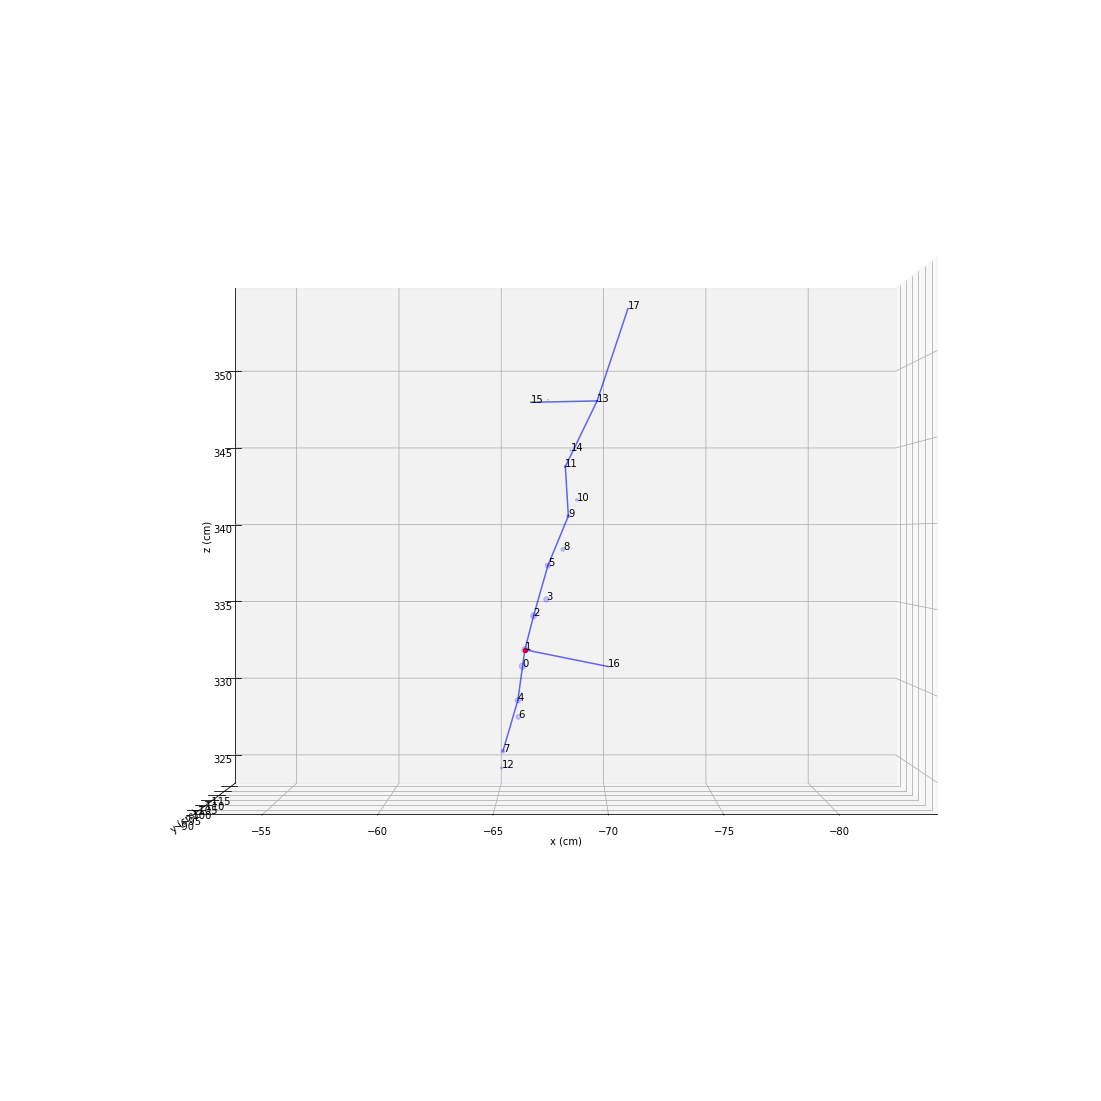

In [21]:
%matplotlib inline
create_graph(lc_data, vx, vy, vz, ve, vi, ev=1, DST_threshold=2, ANGLE_THR = 1.5)

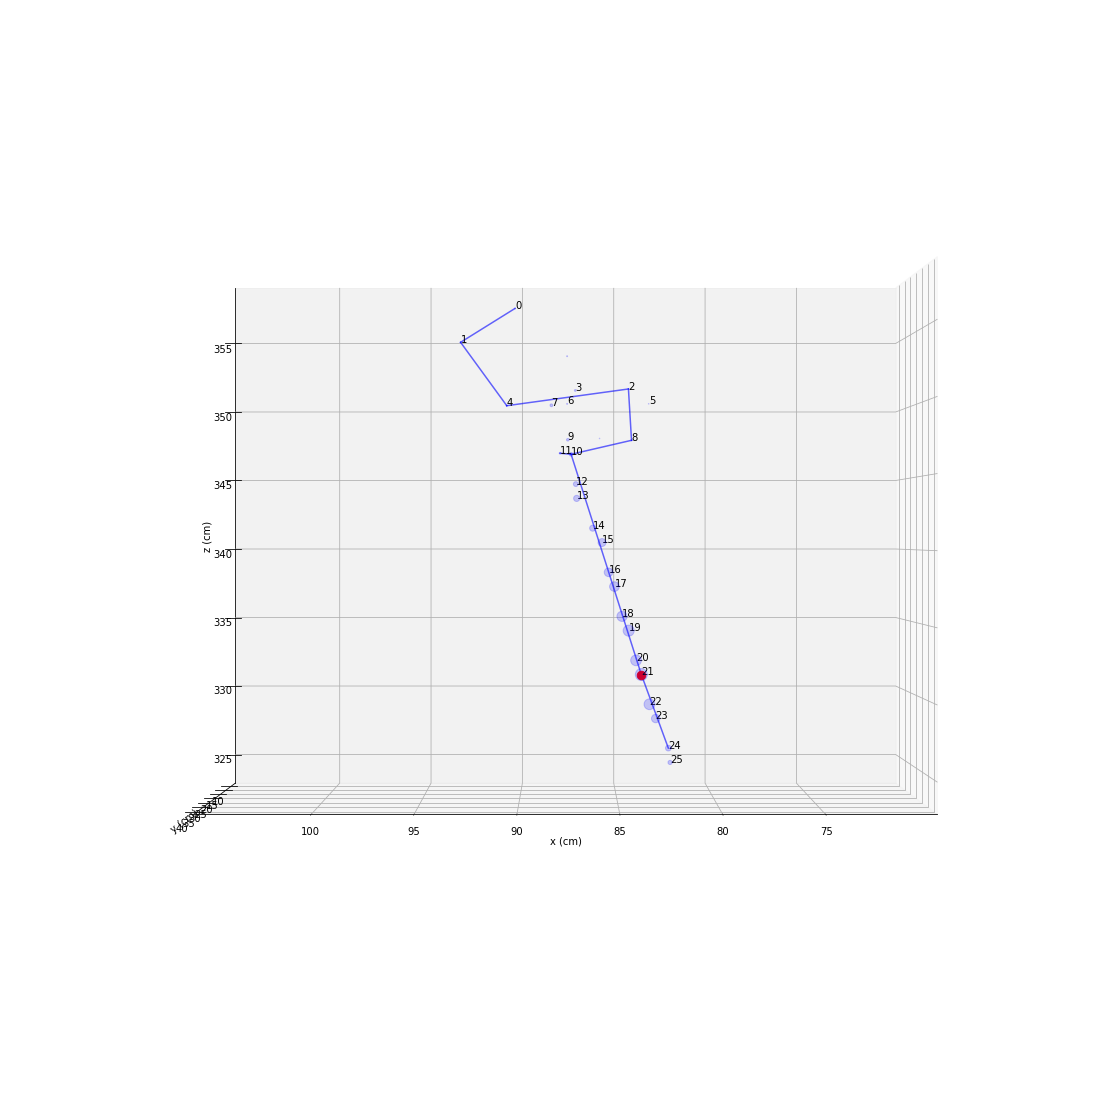

In [22]:
%matplotlib inline 
#widget
create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR = 1.5, sort_by_z = True)

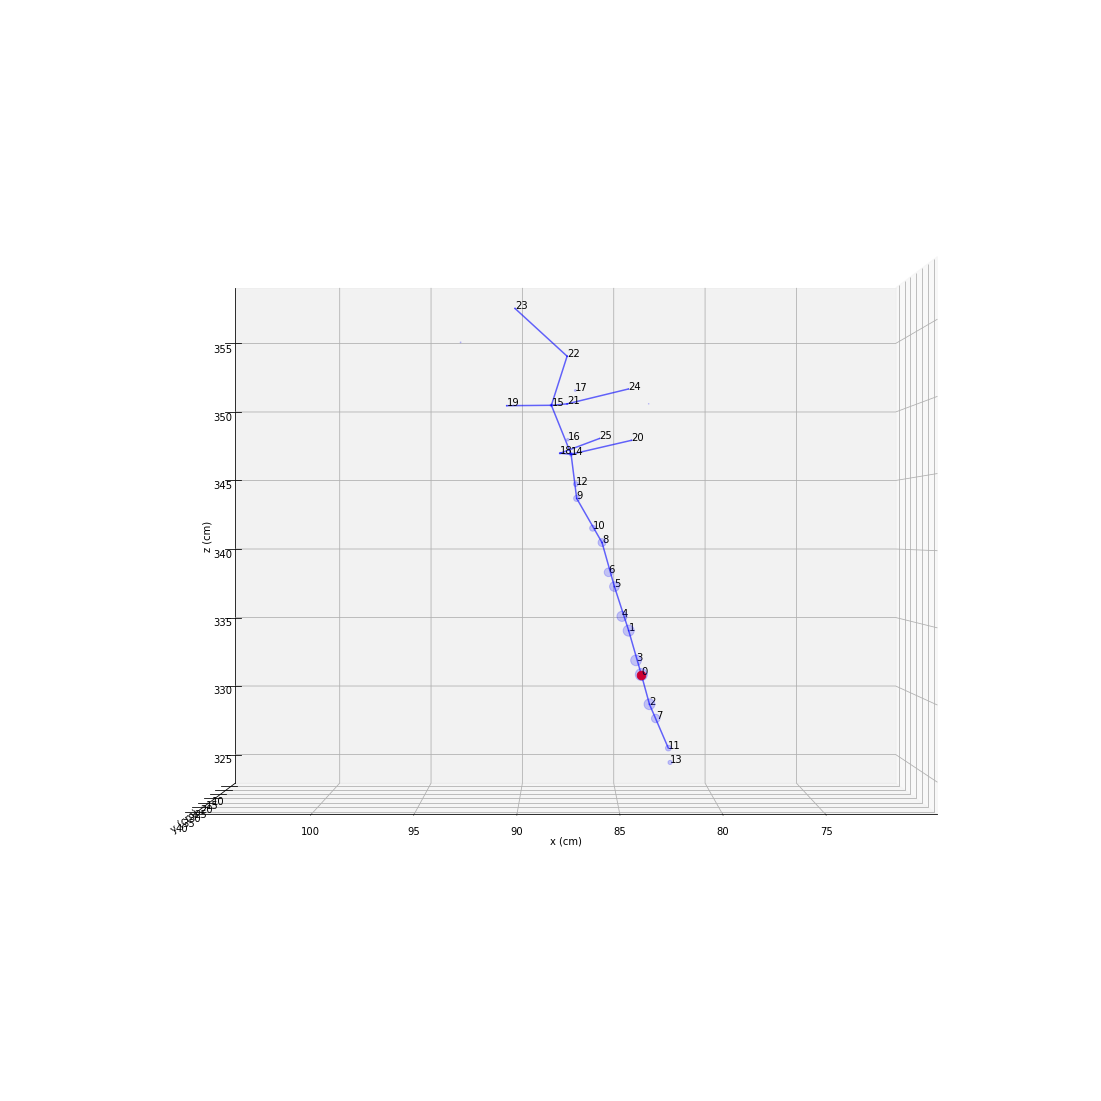

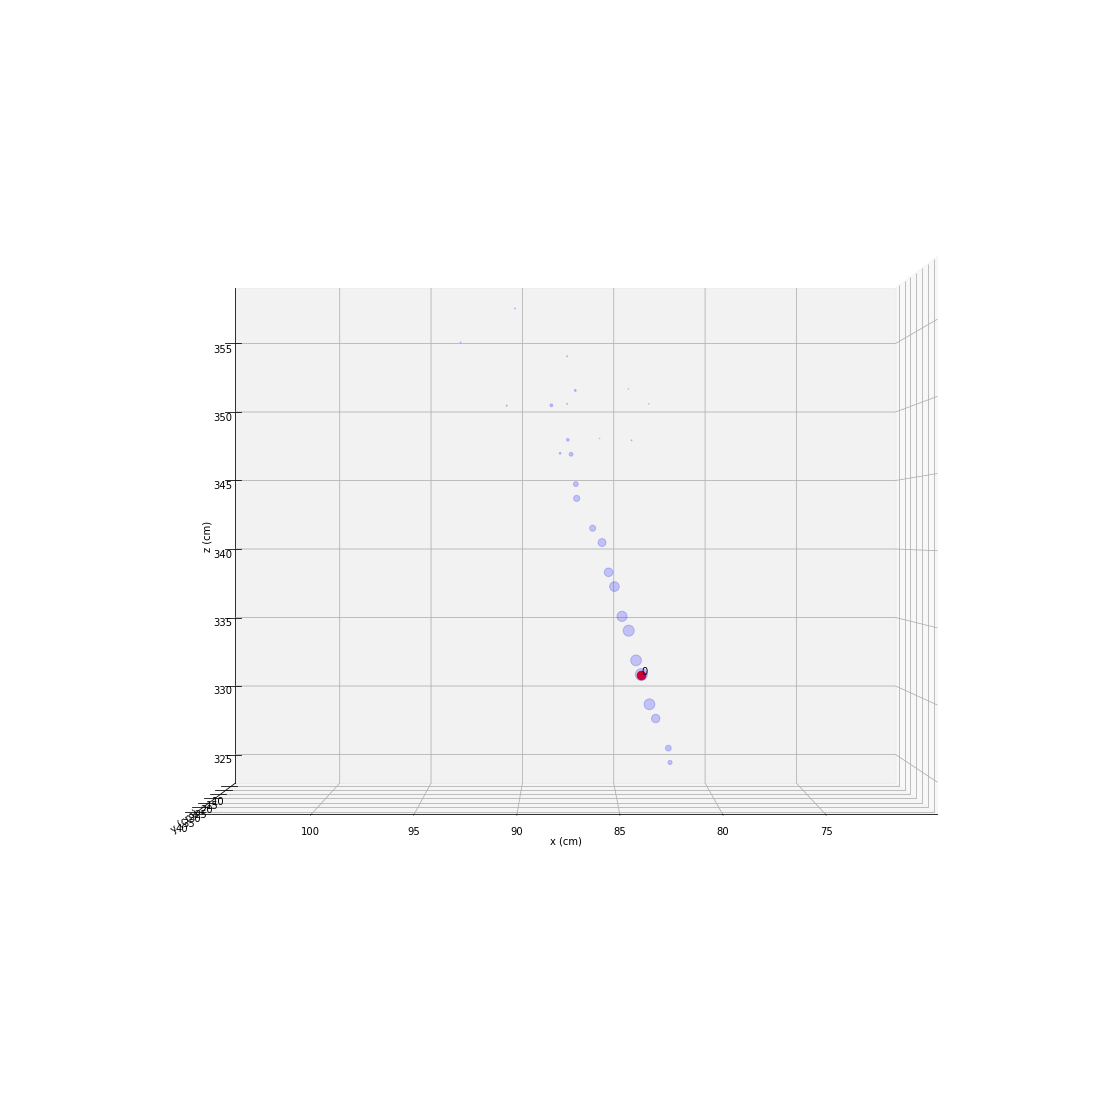

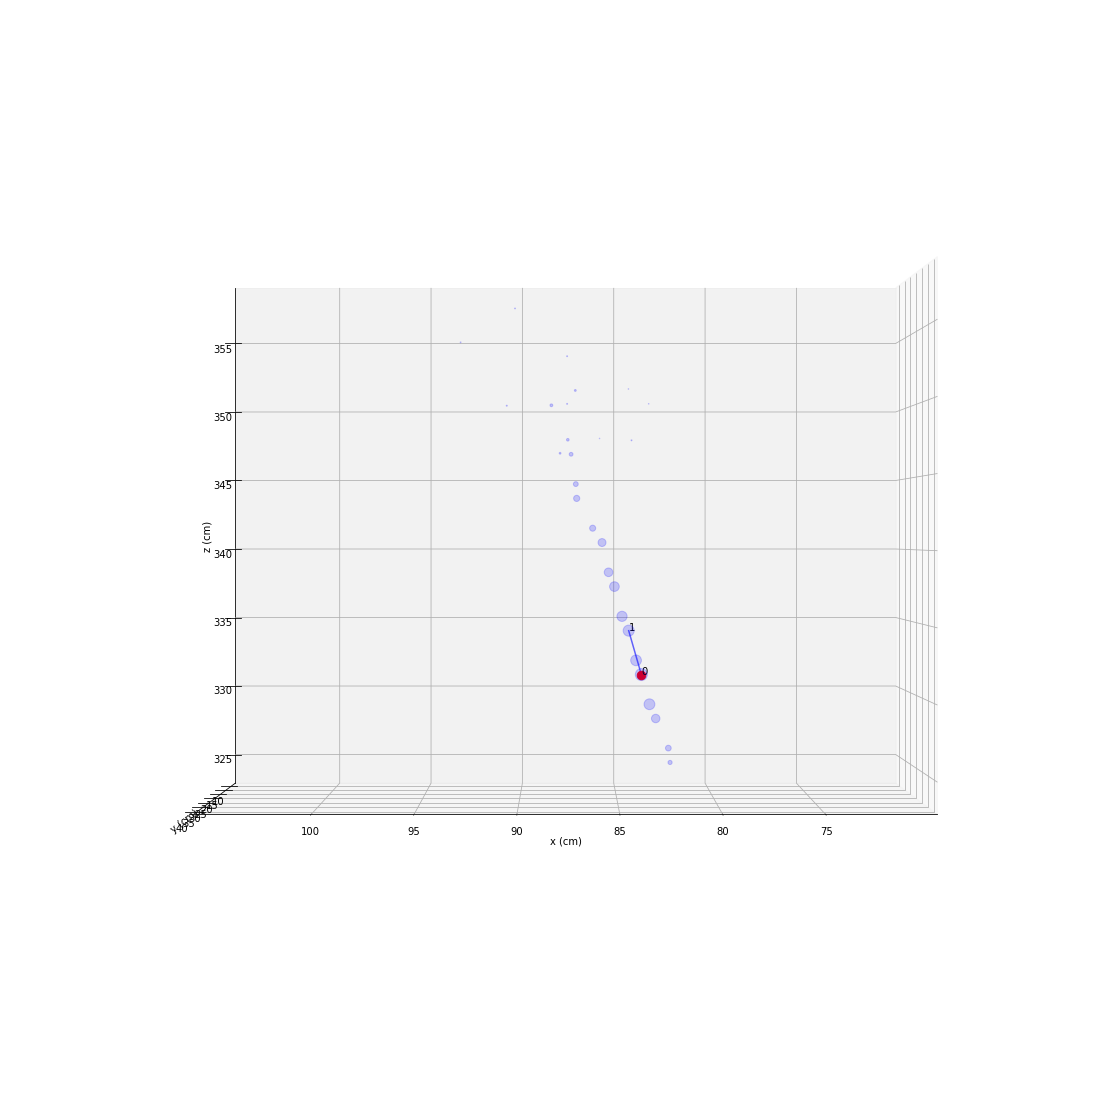

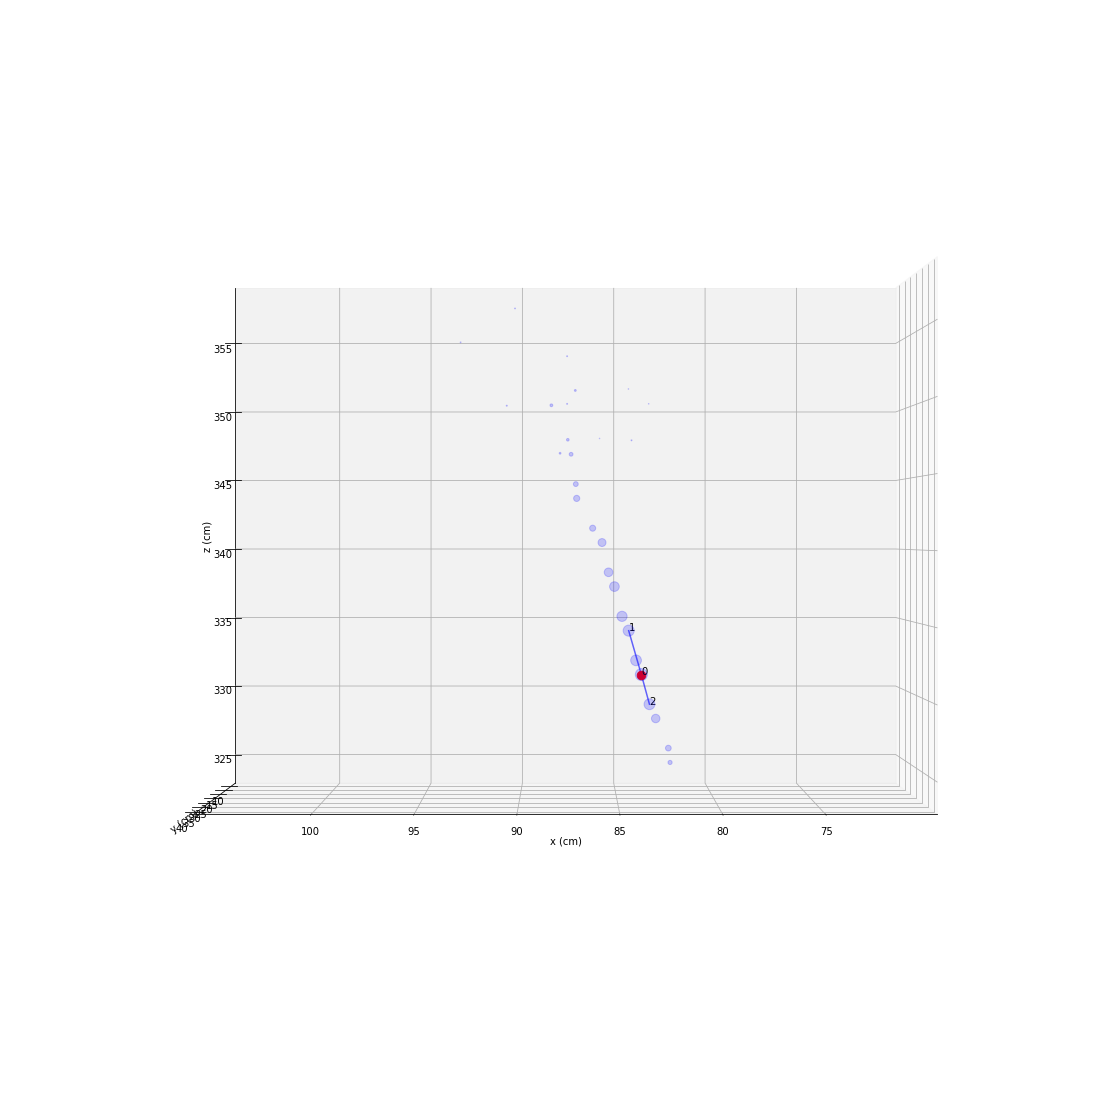

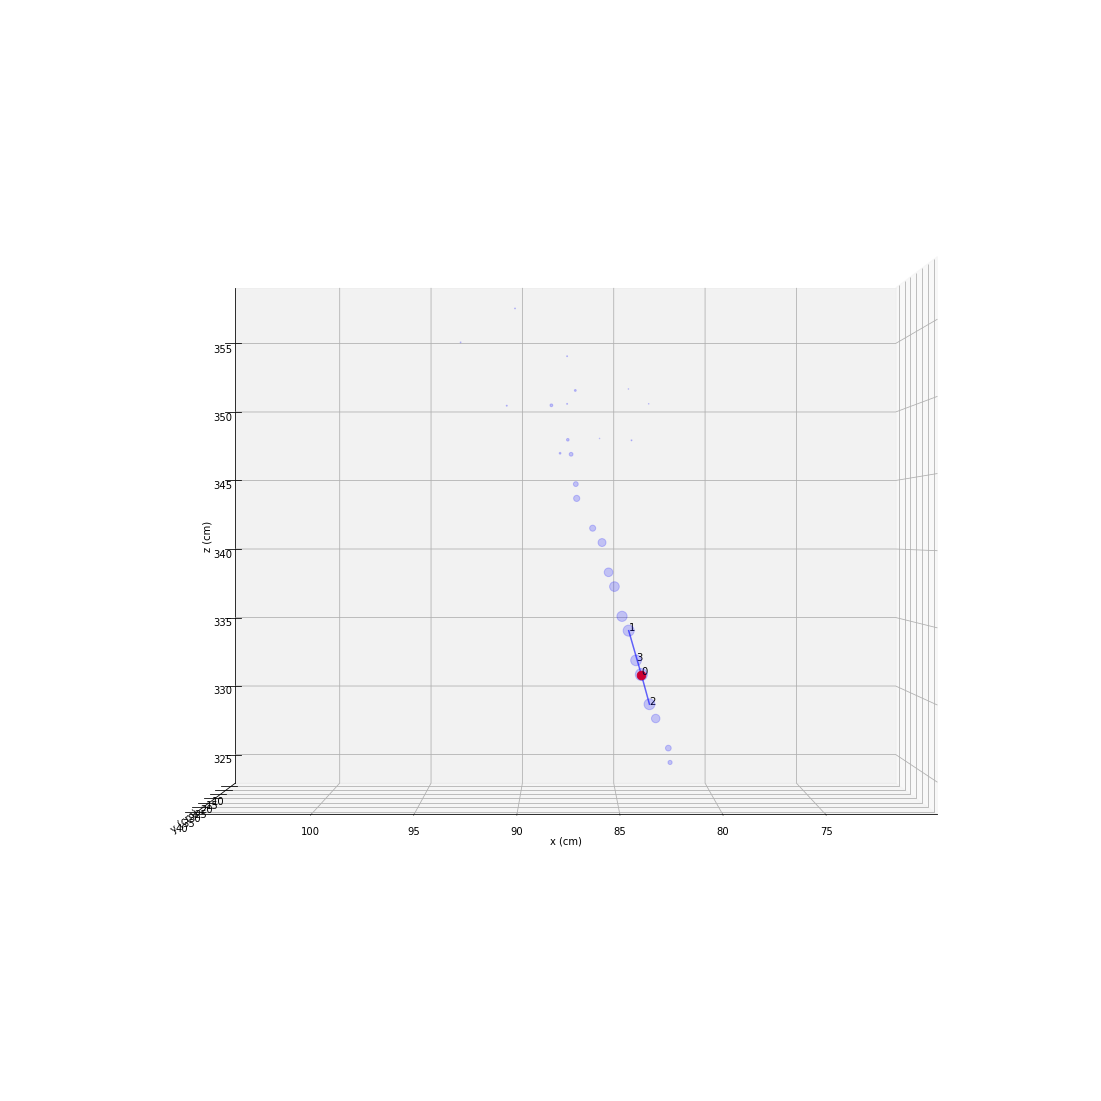

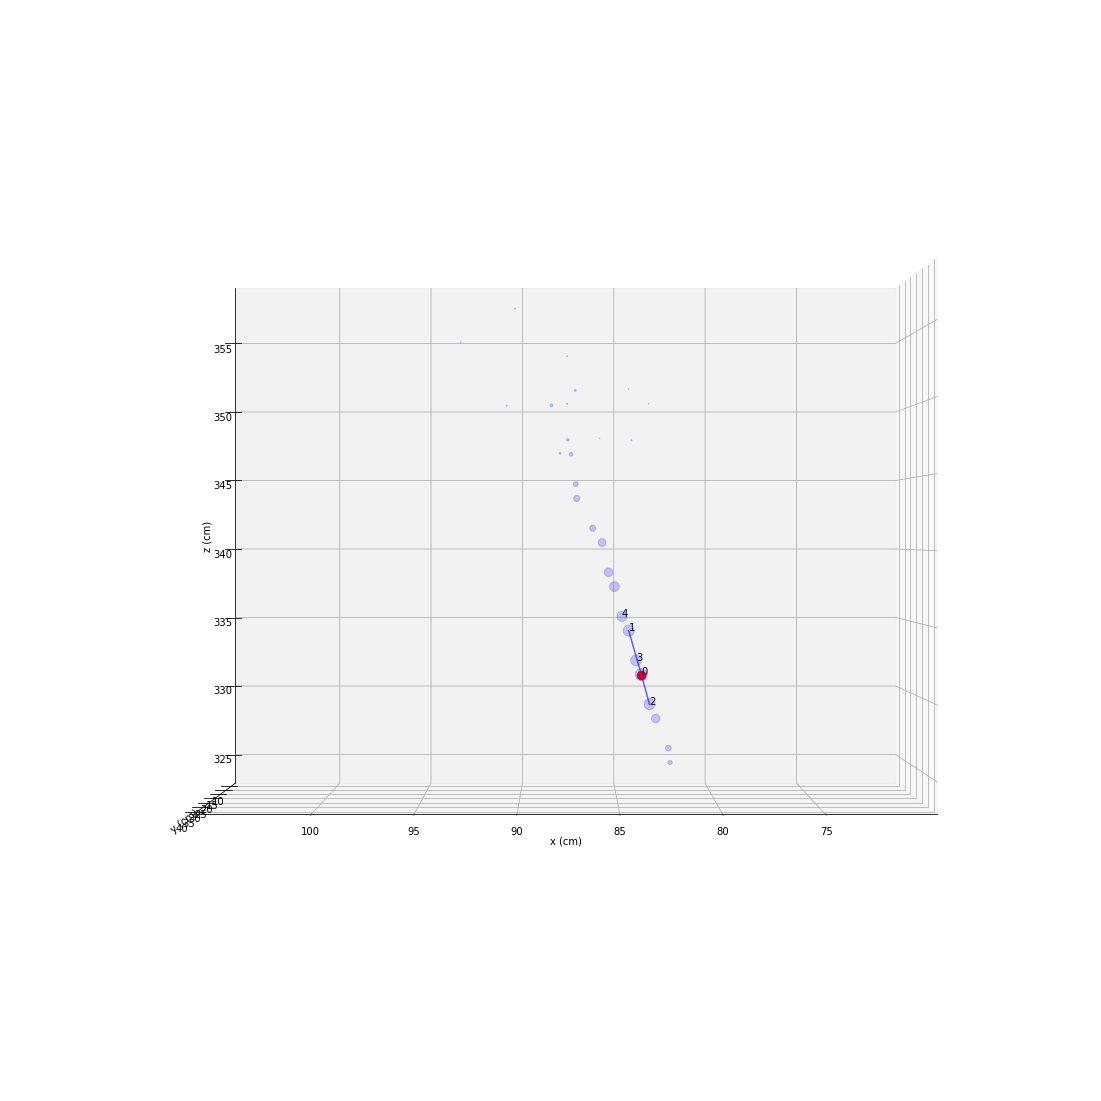

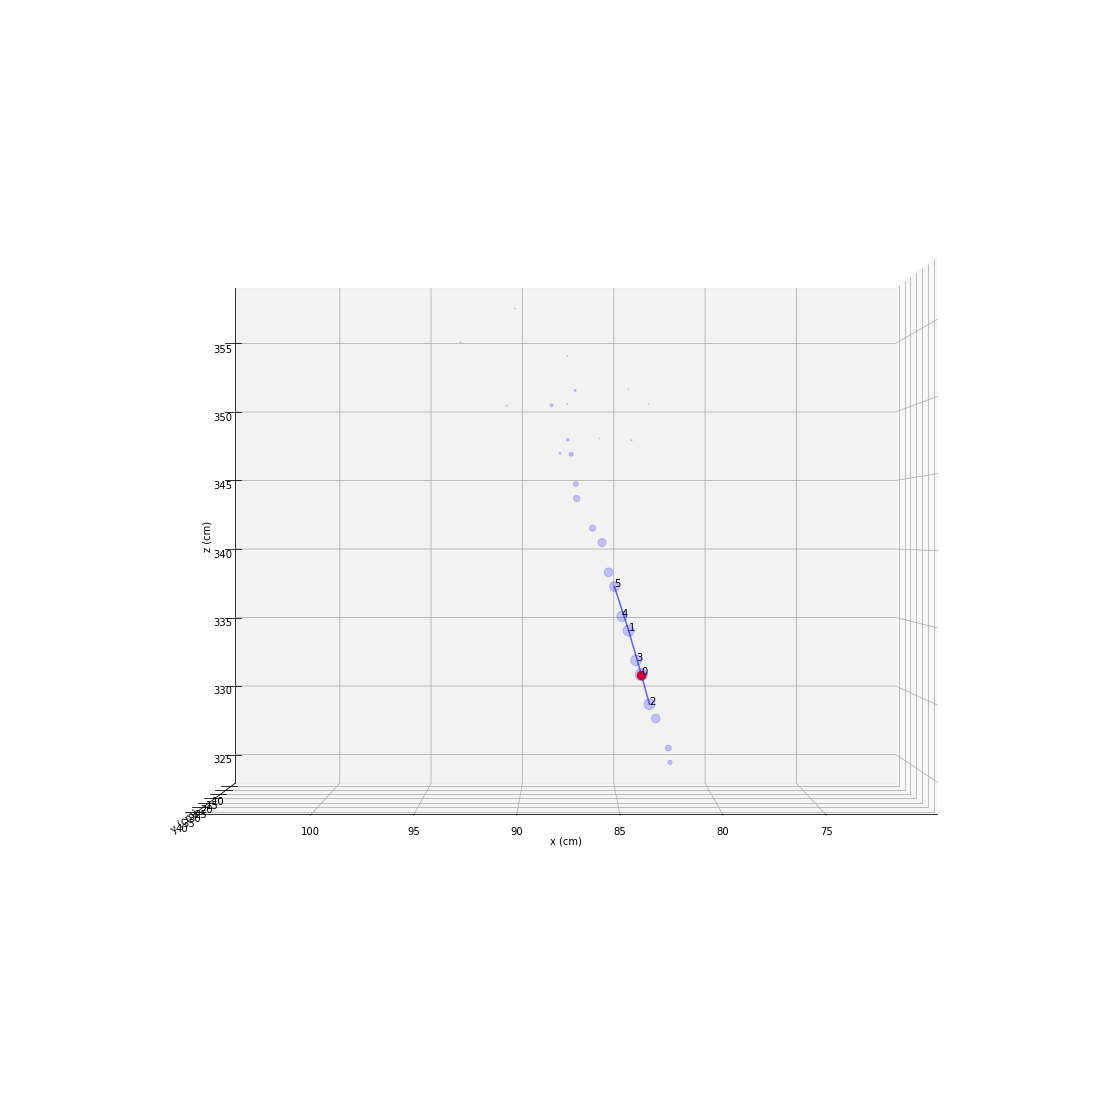

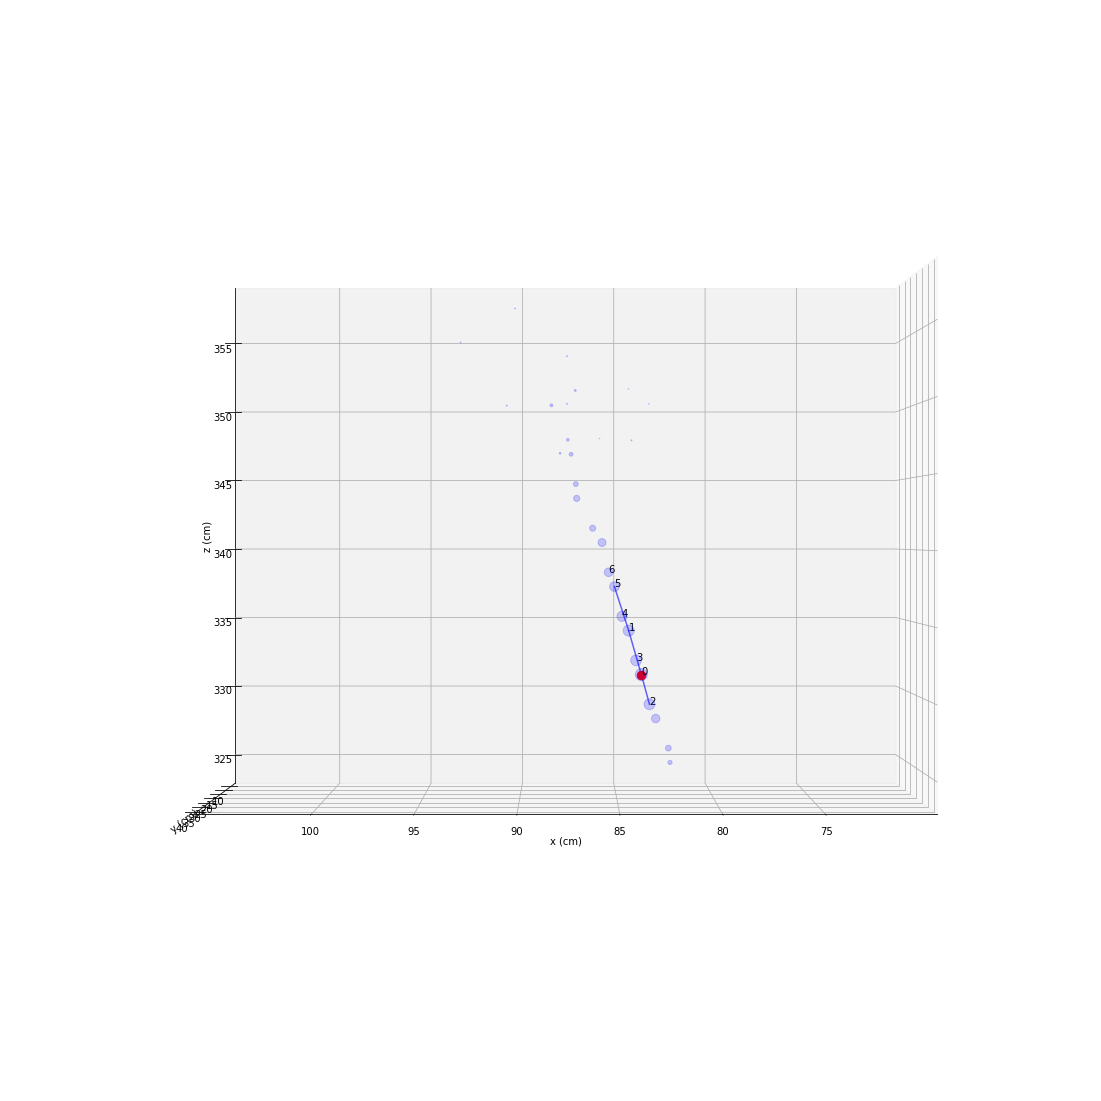

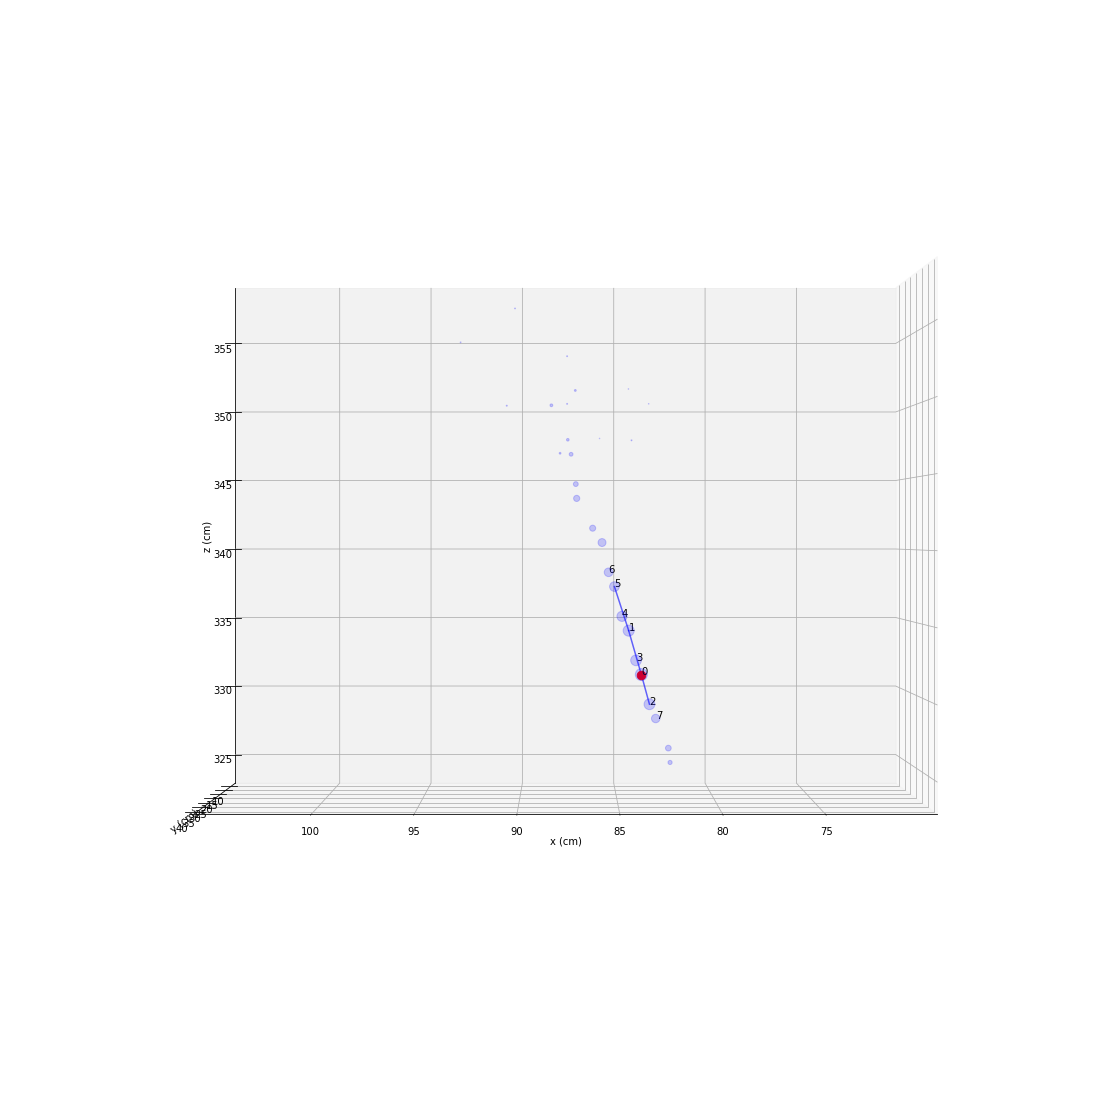

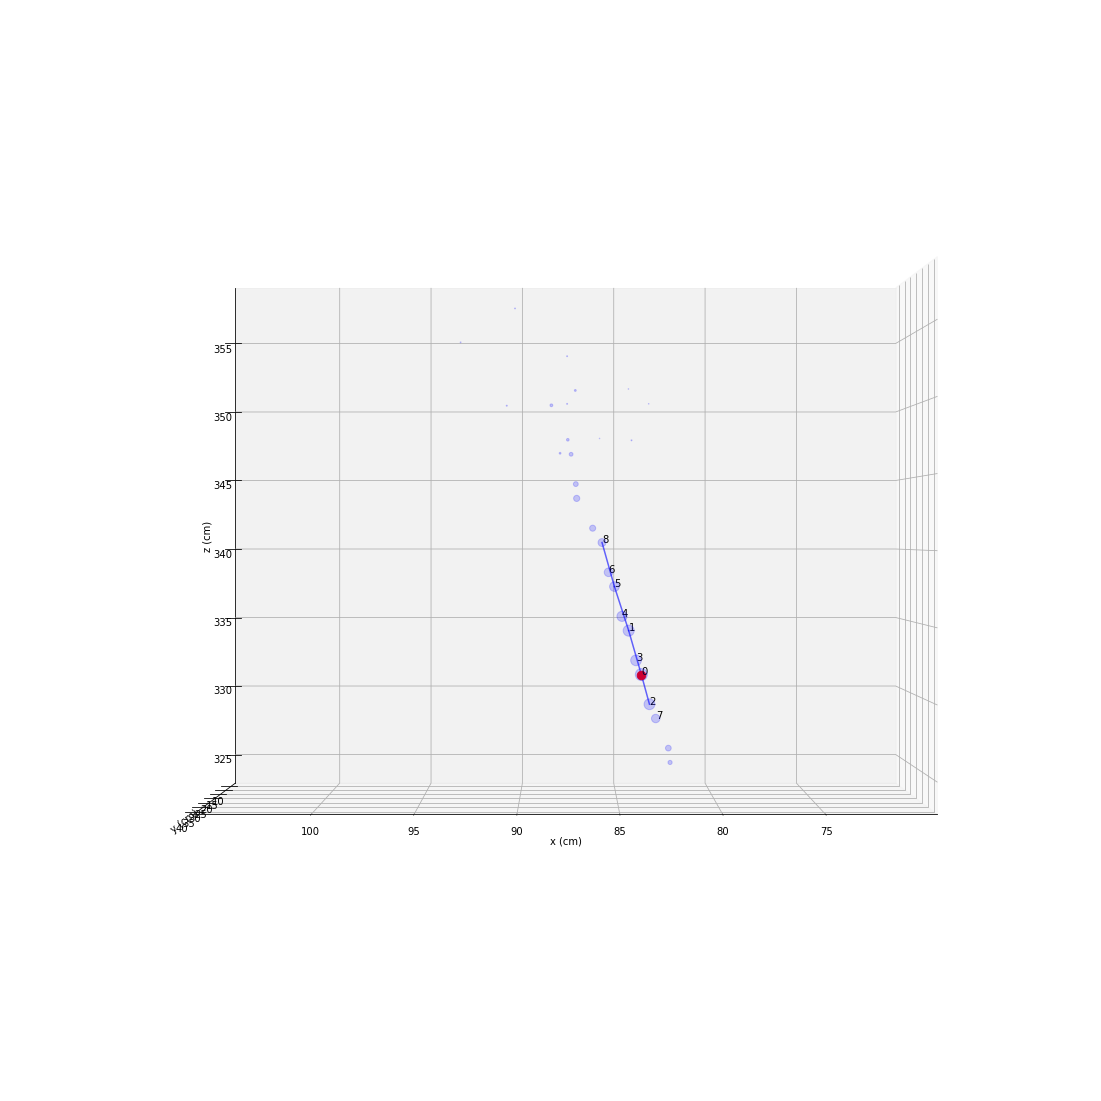

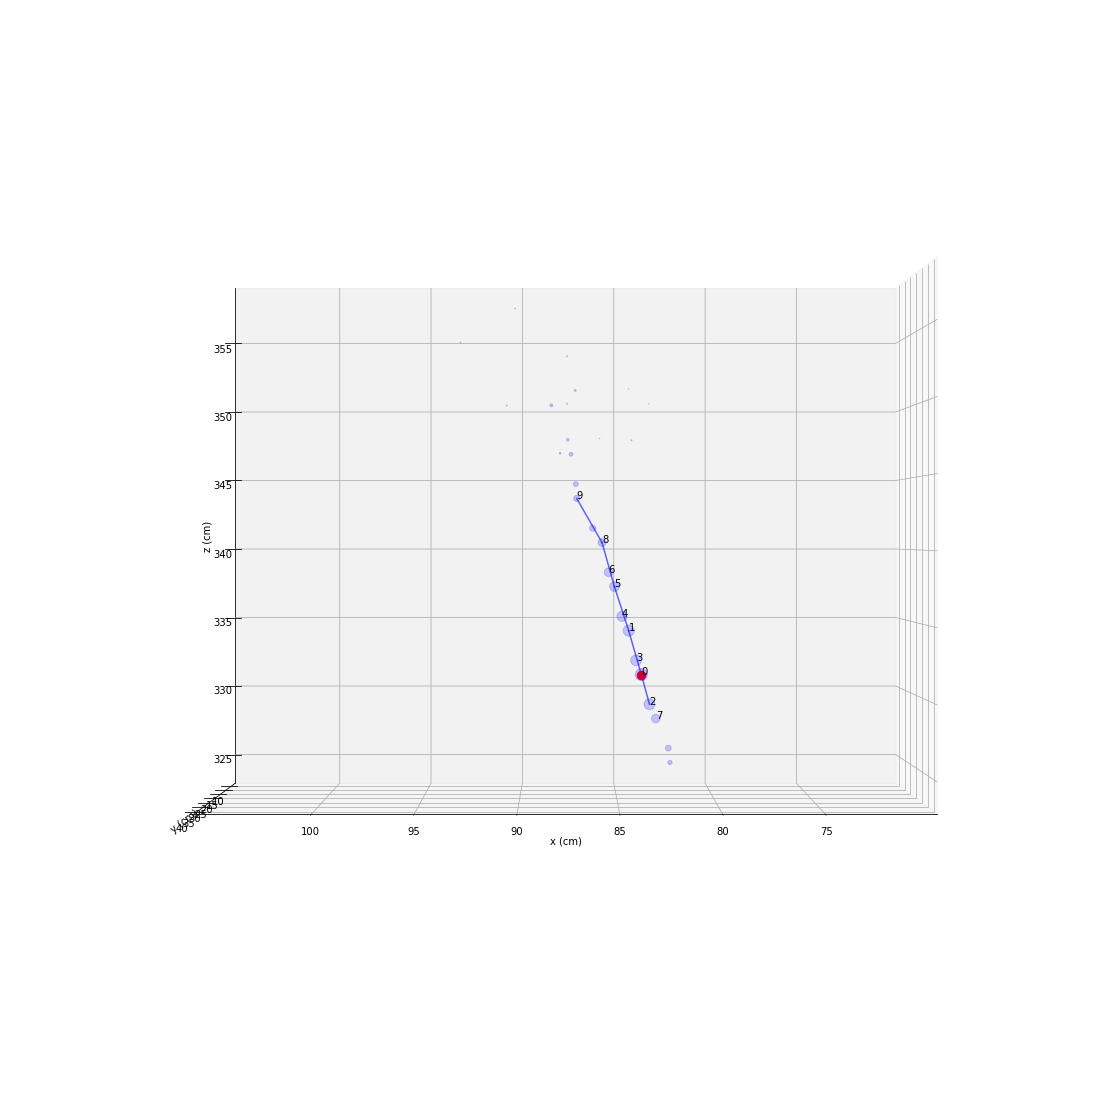

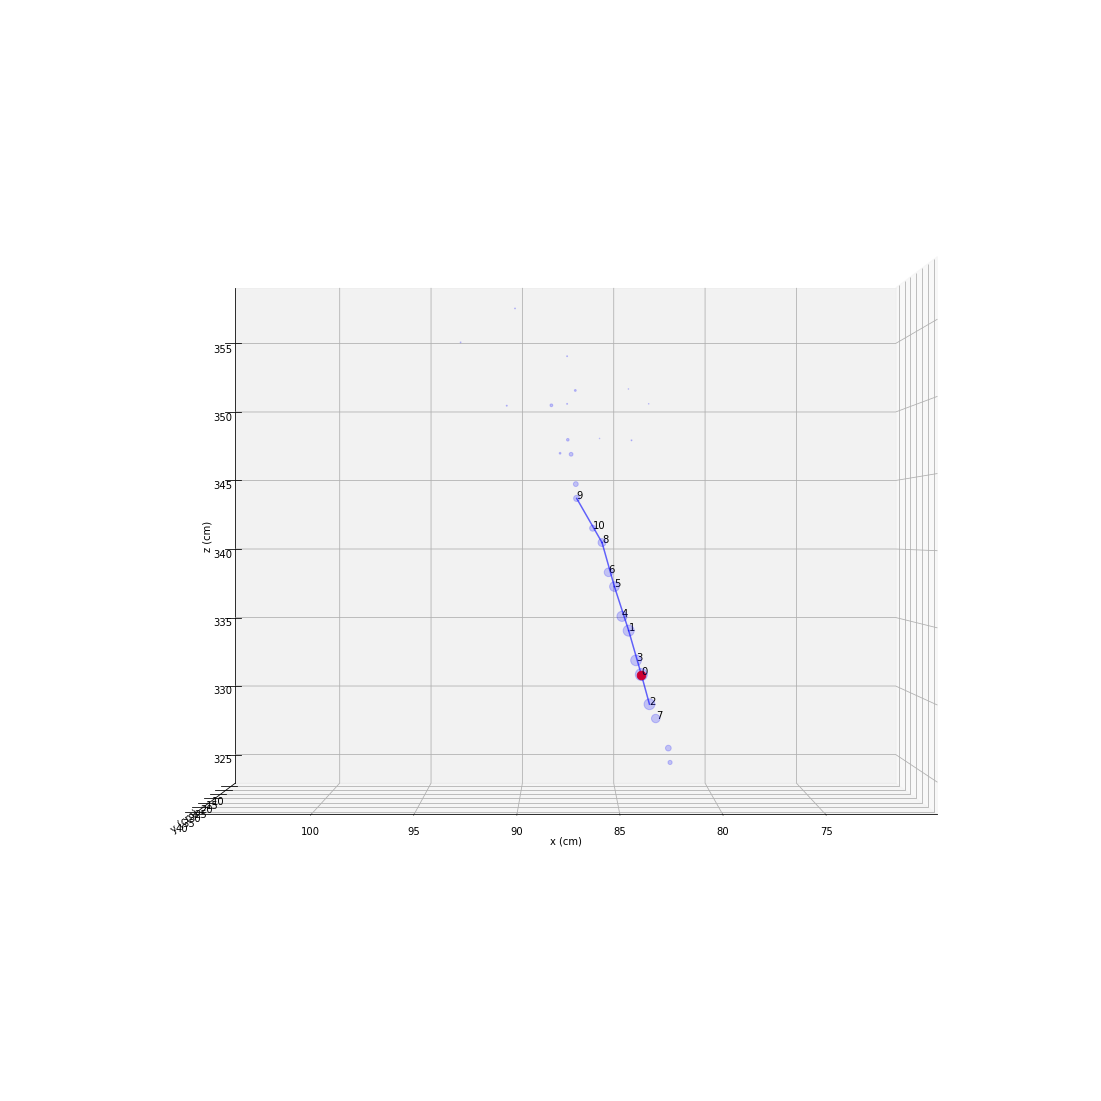

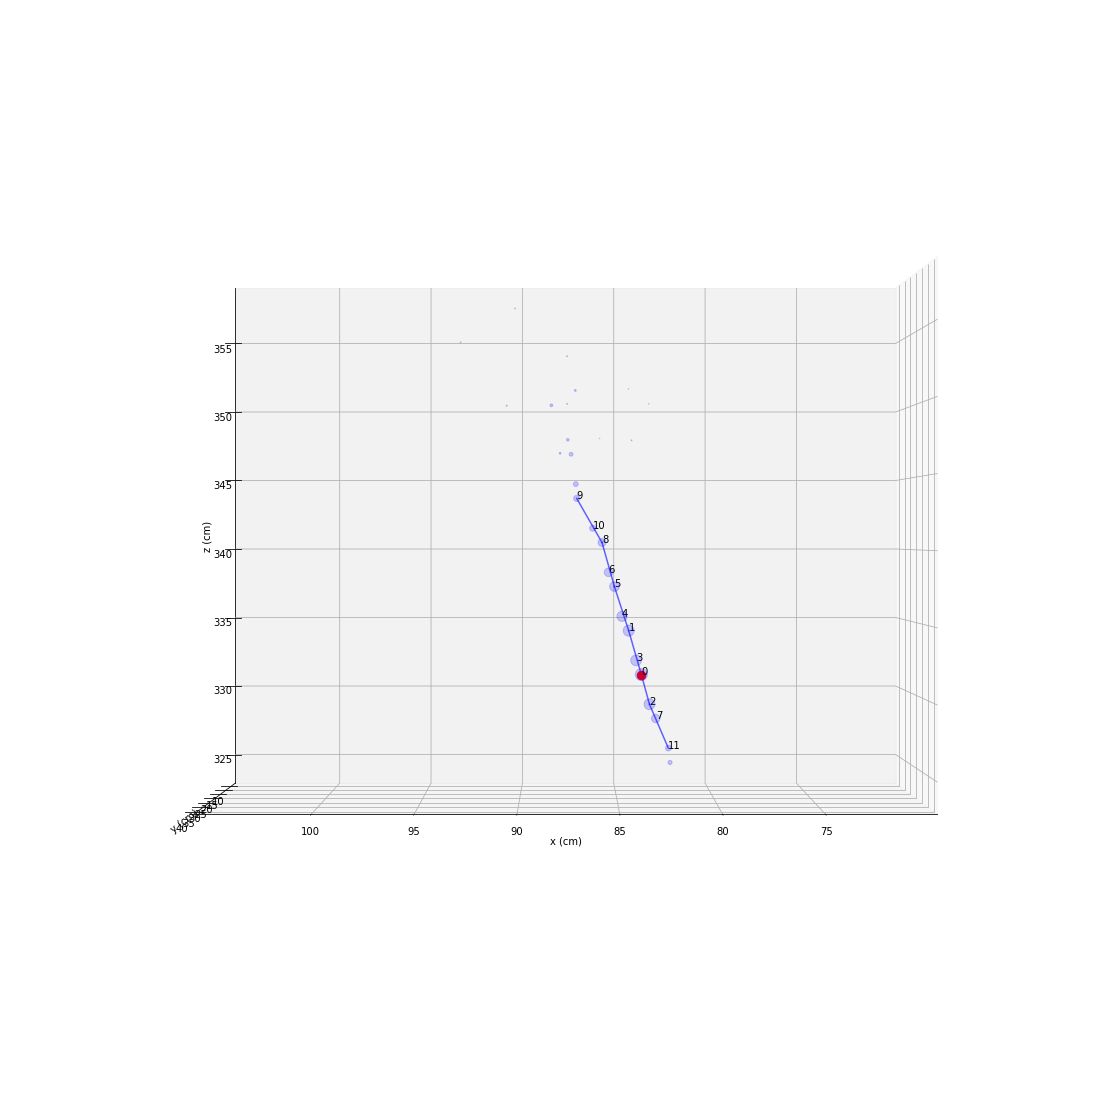

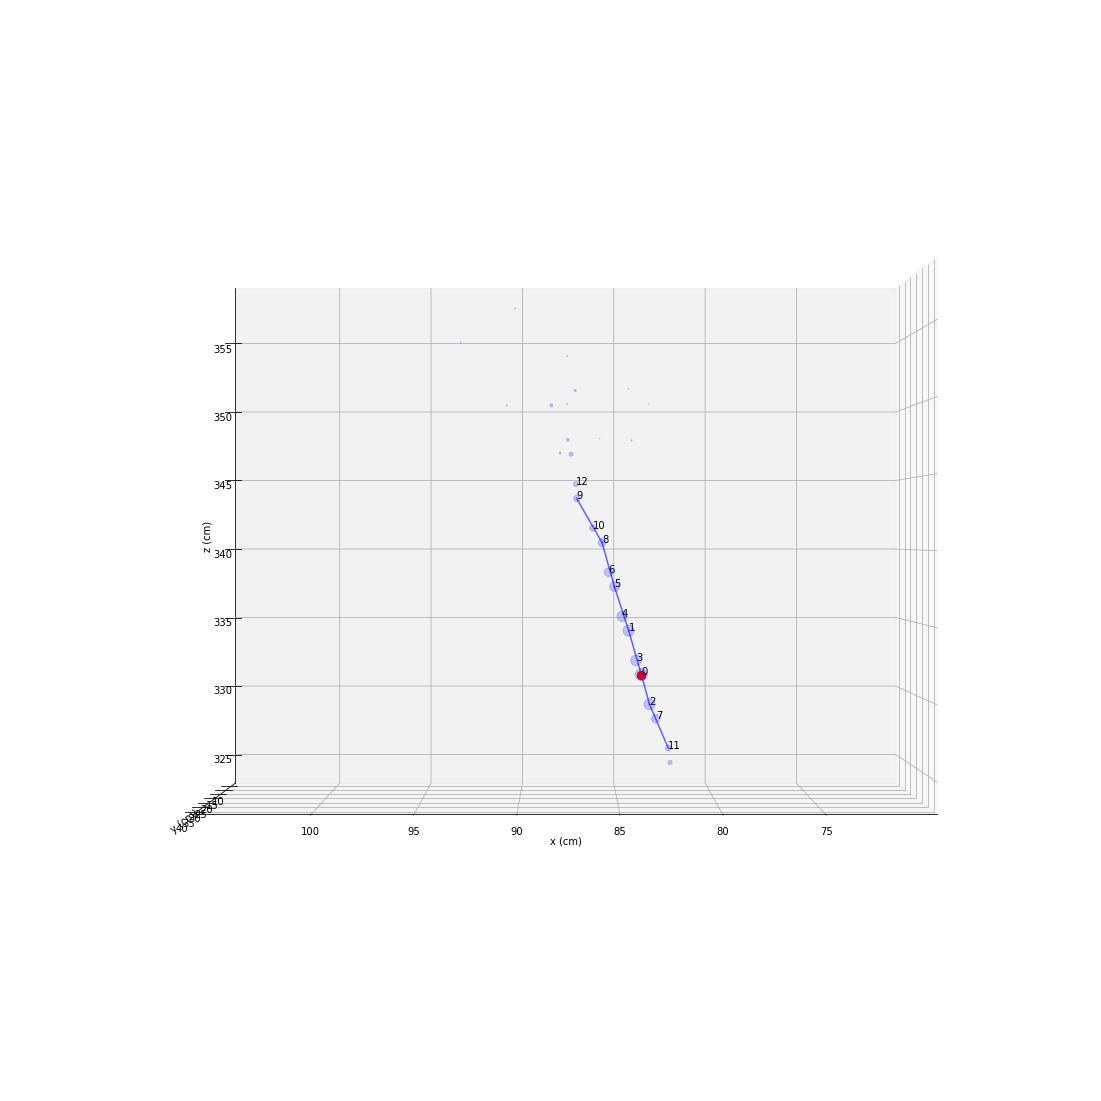

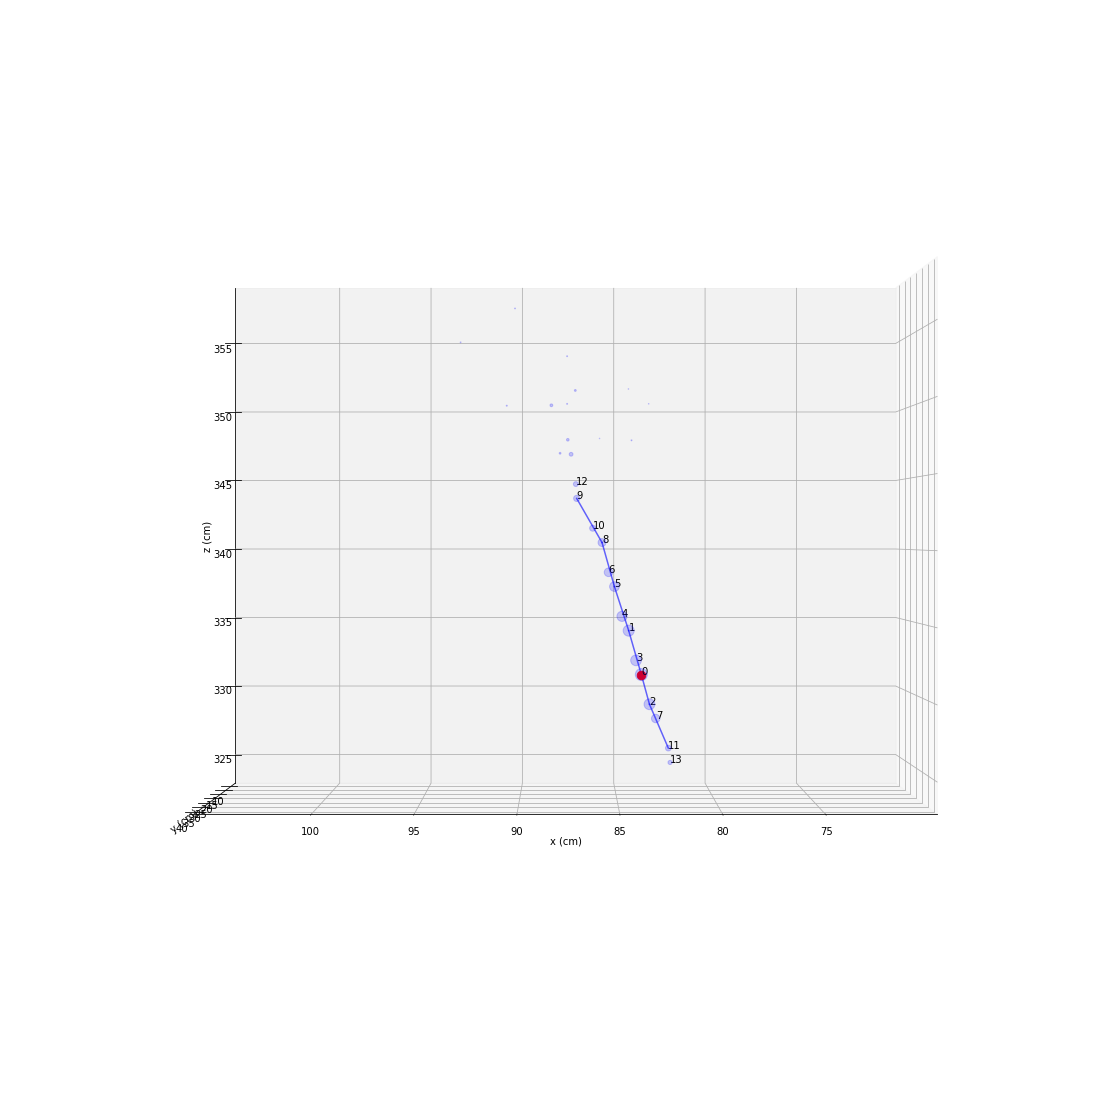

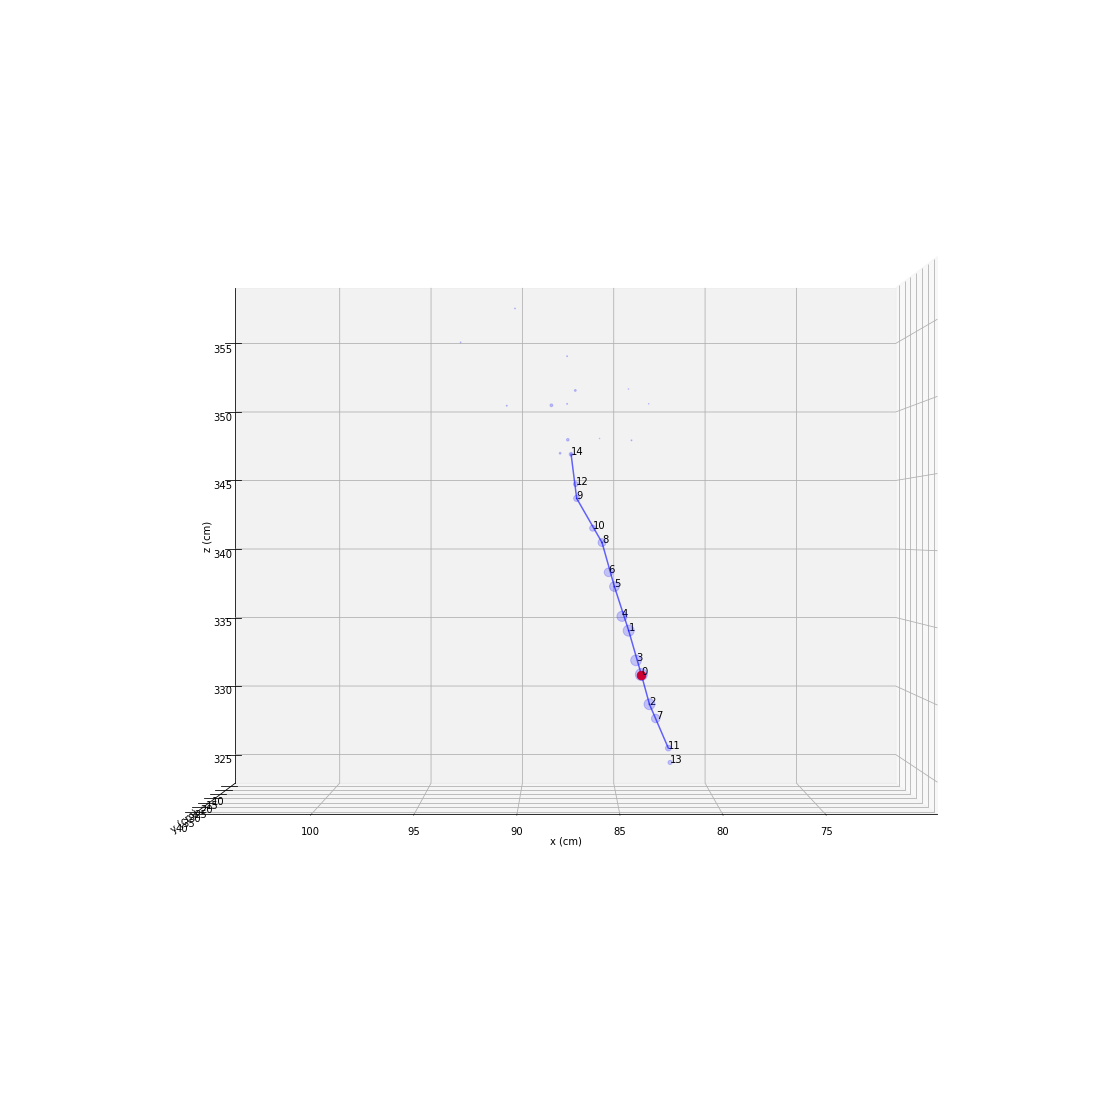

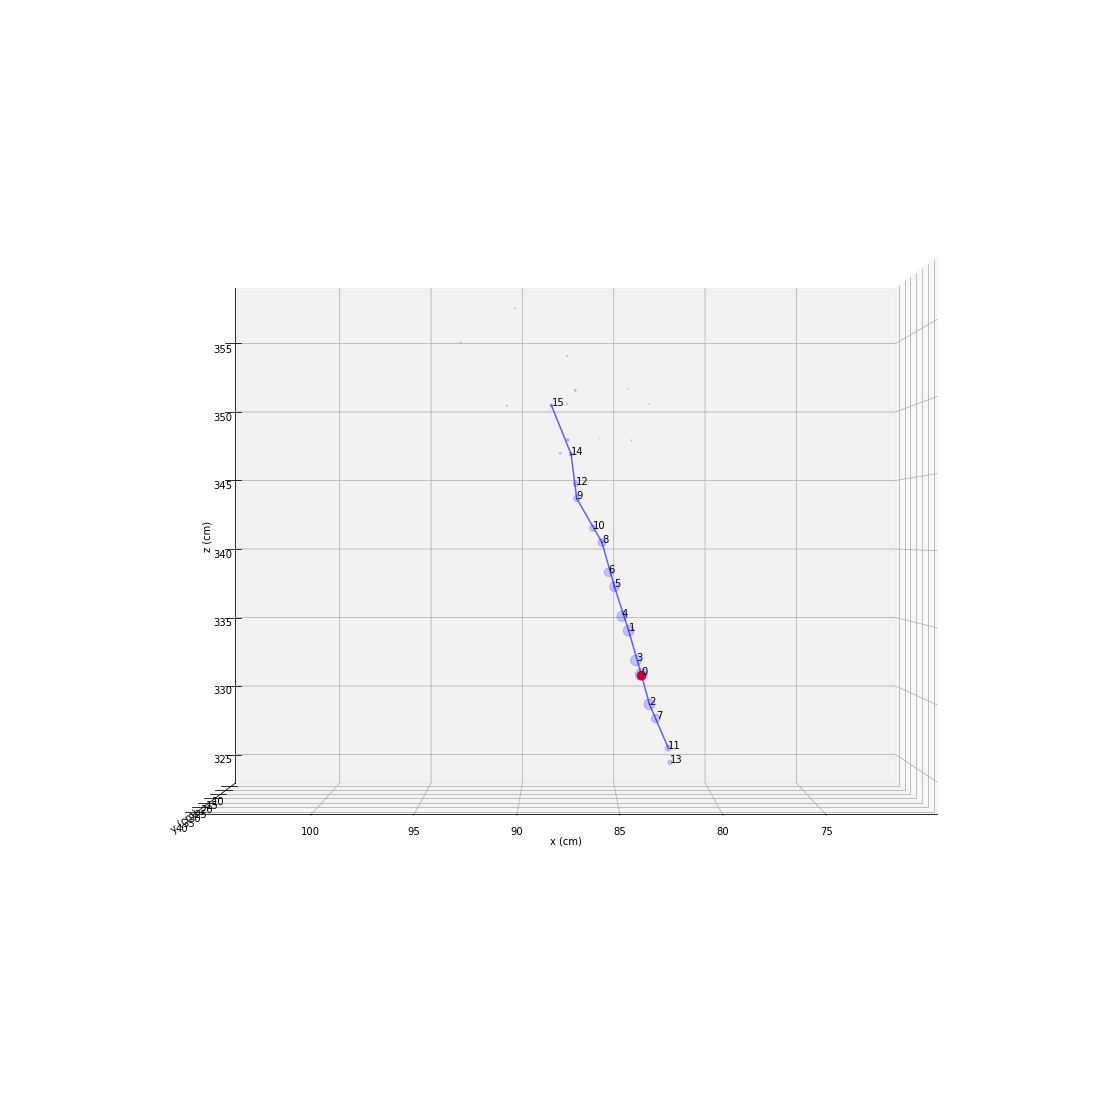

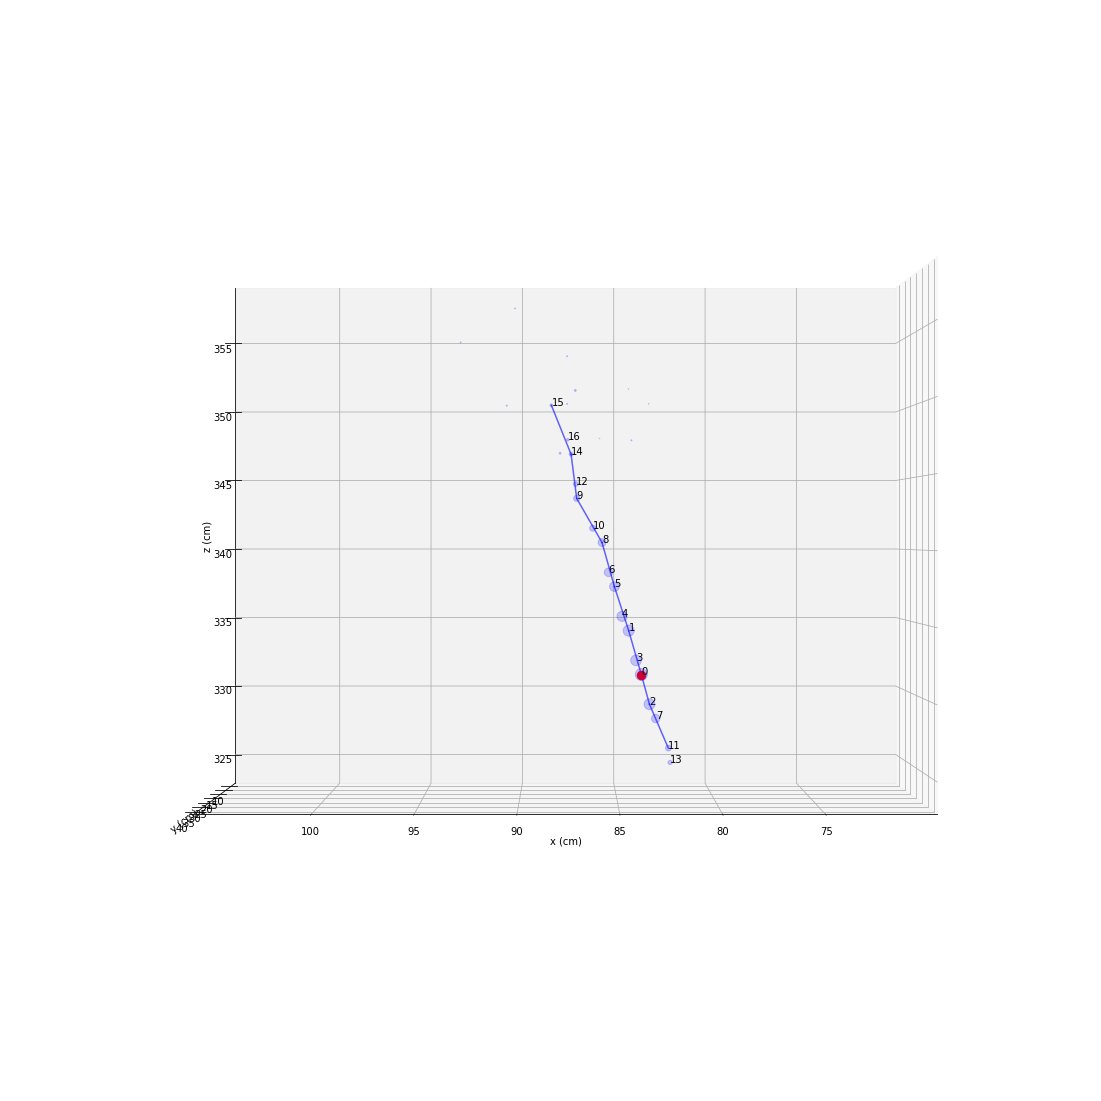

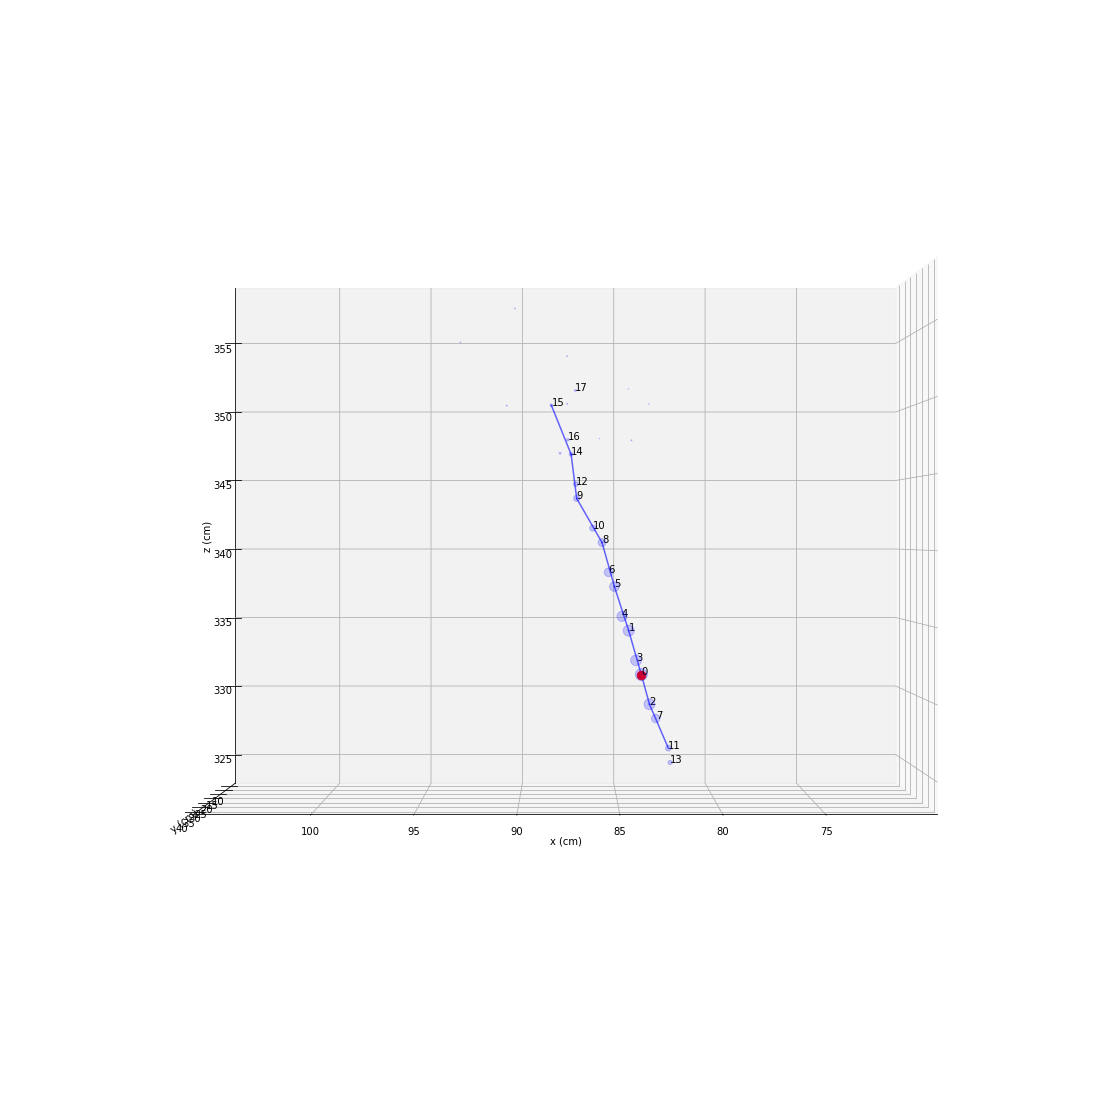

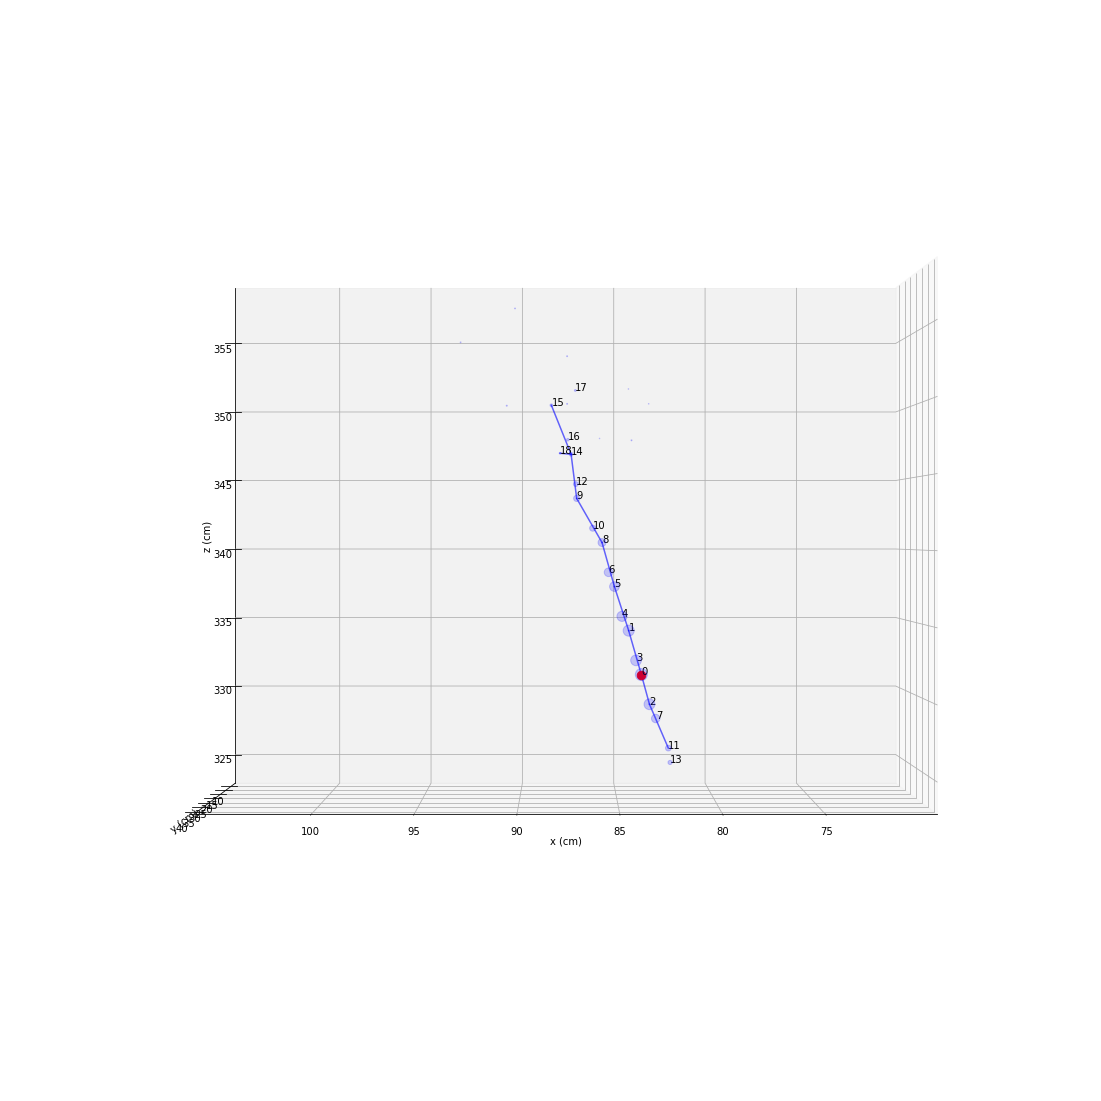

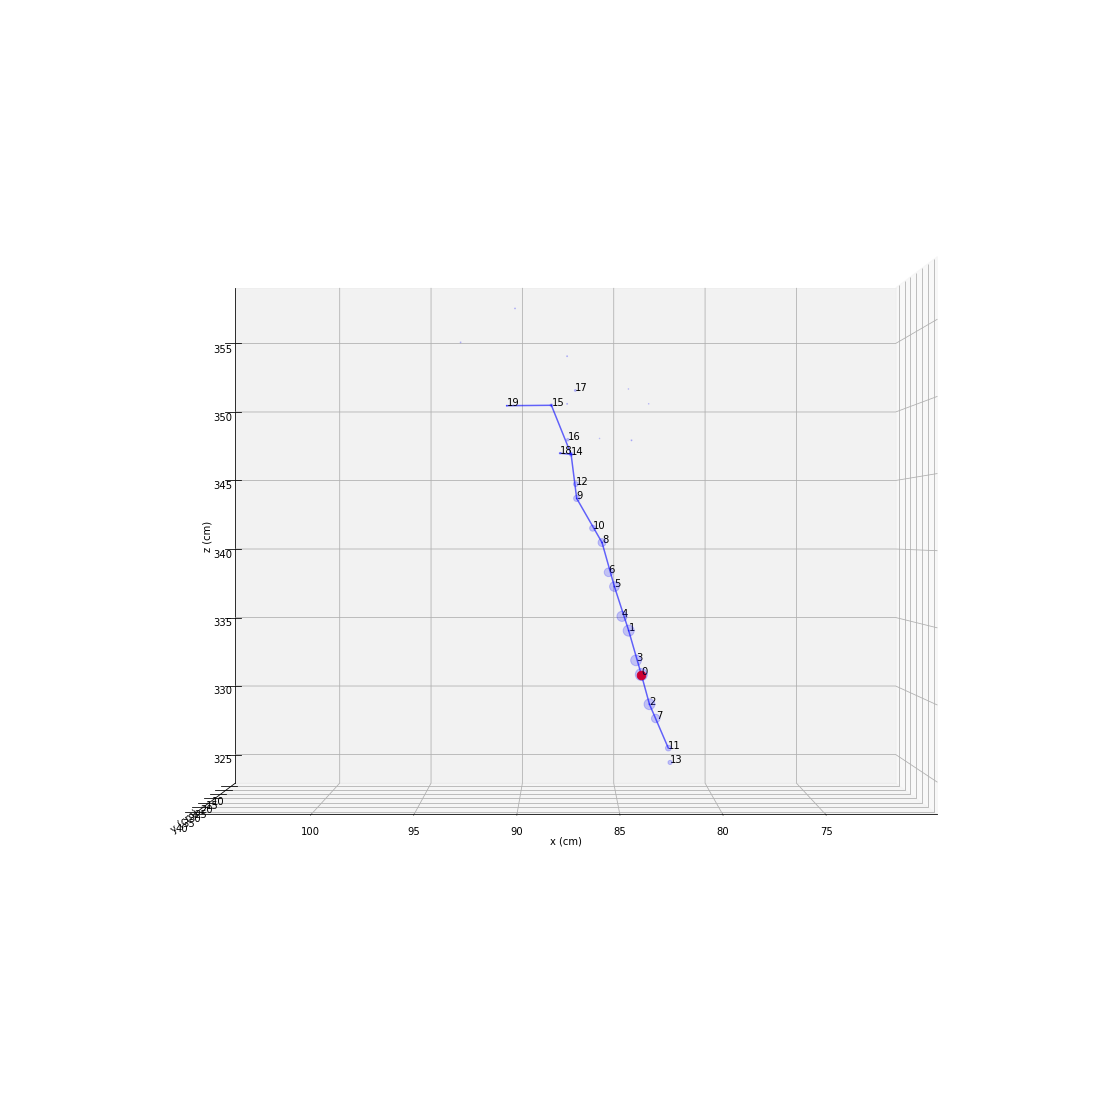

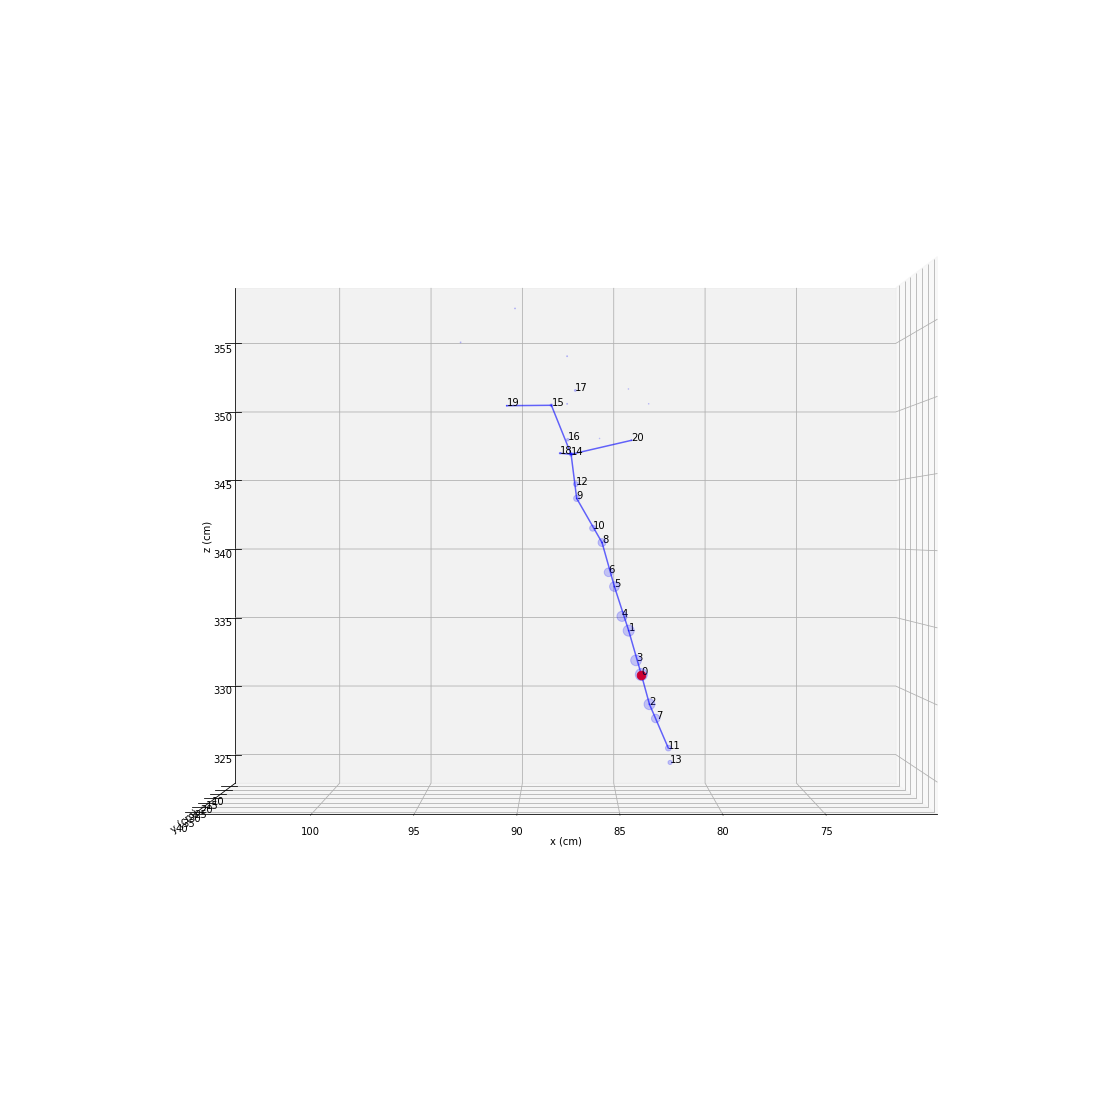

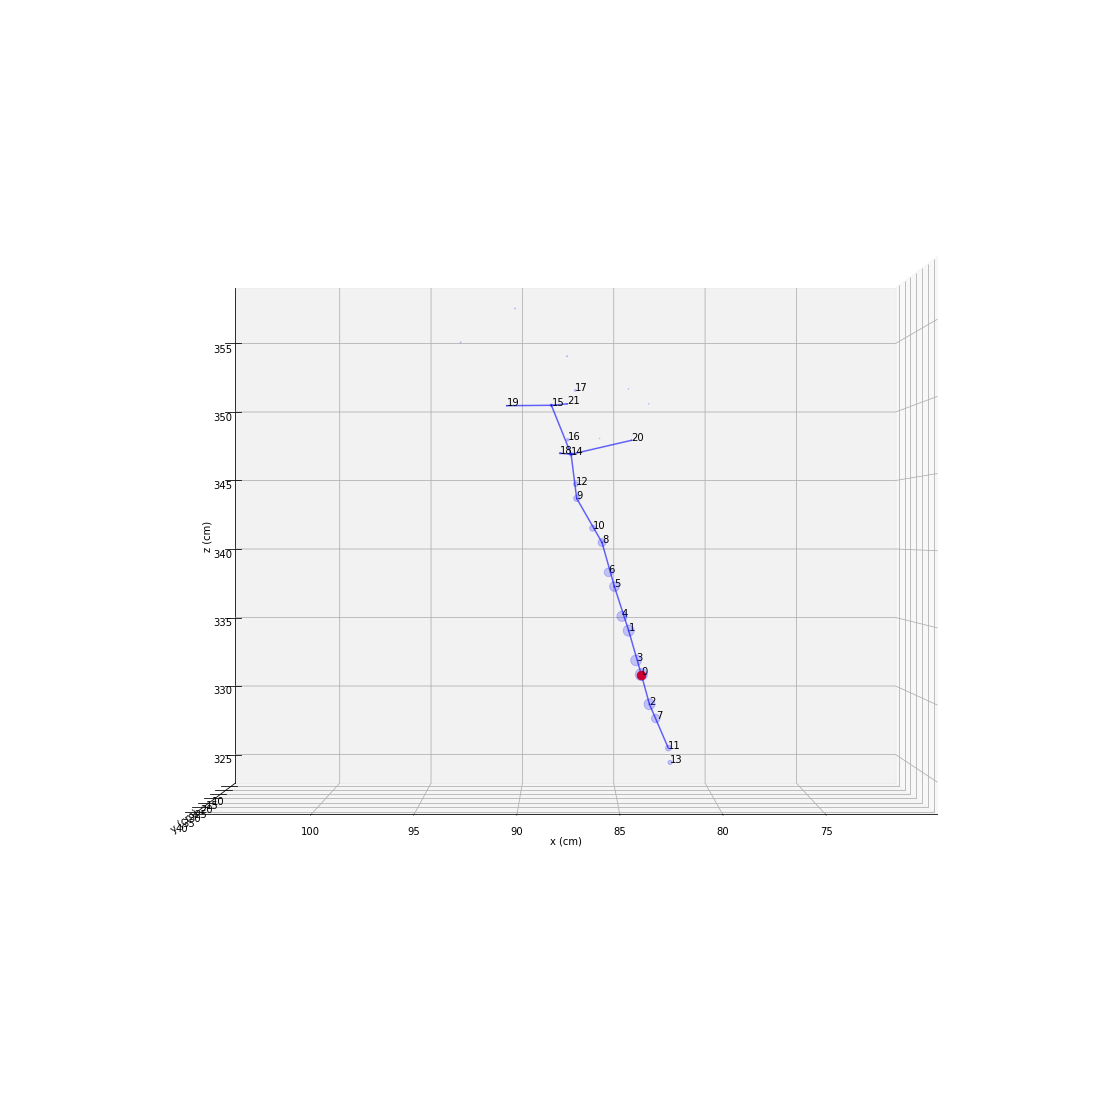

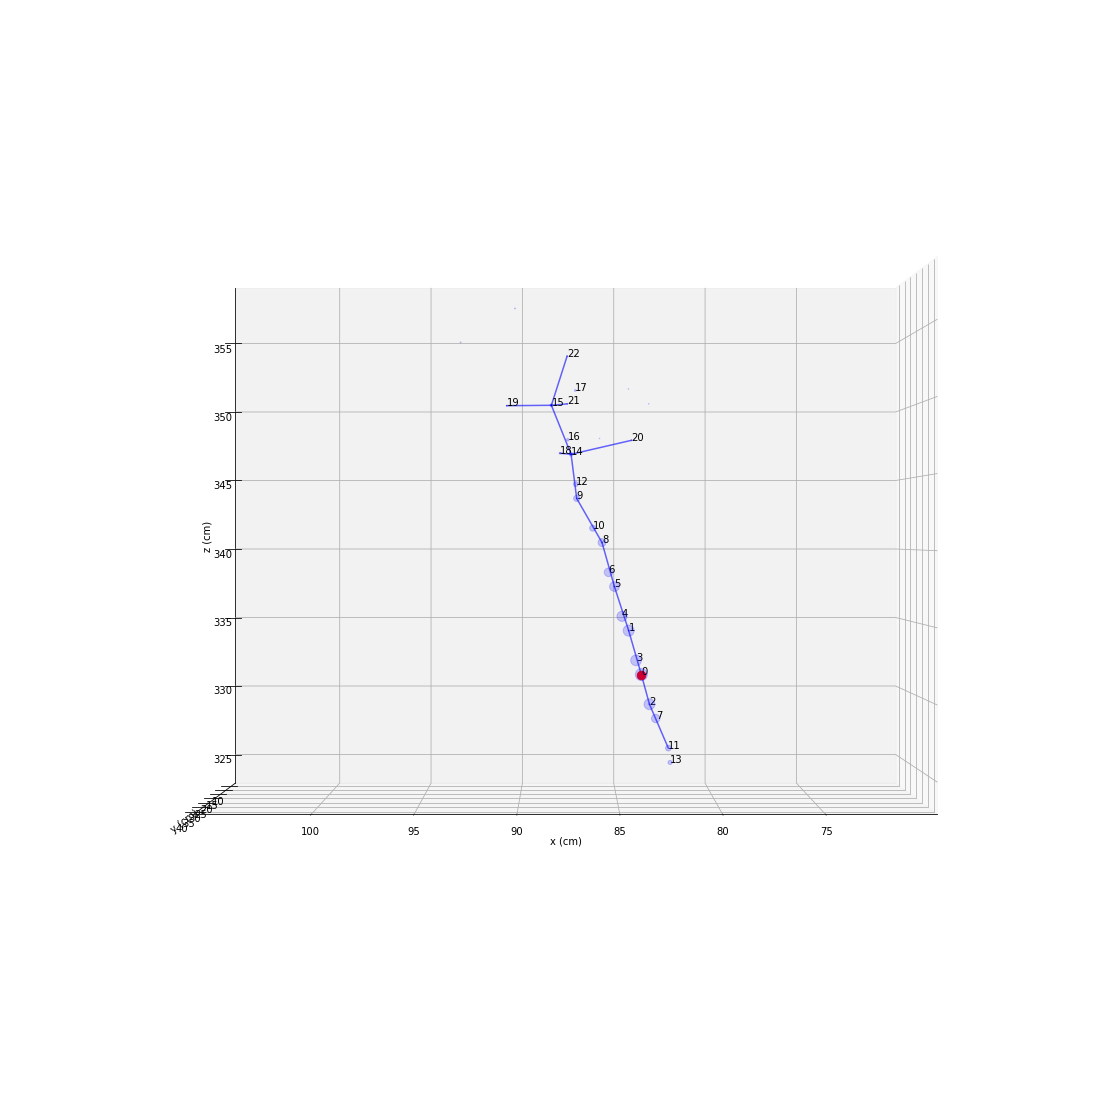

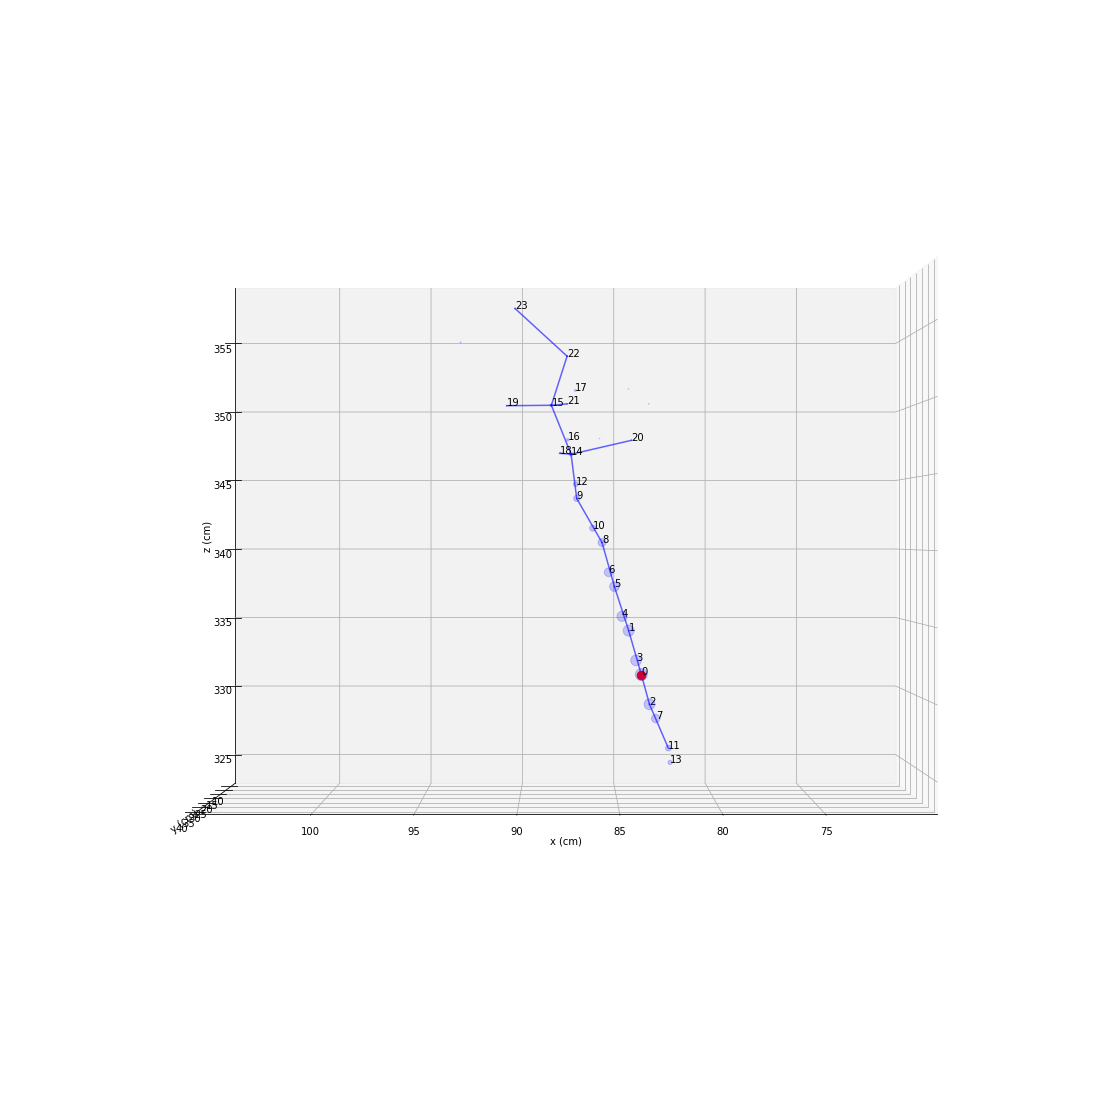

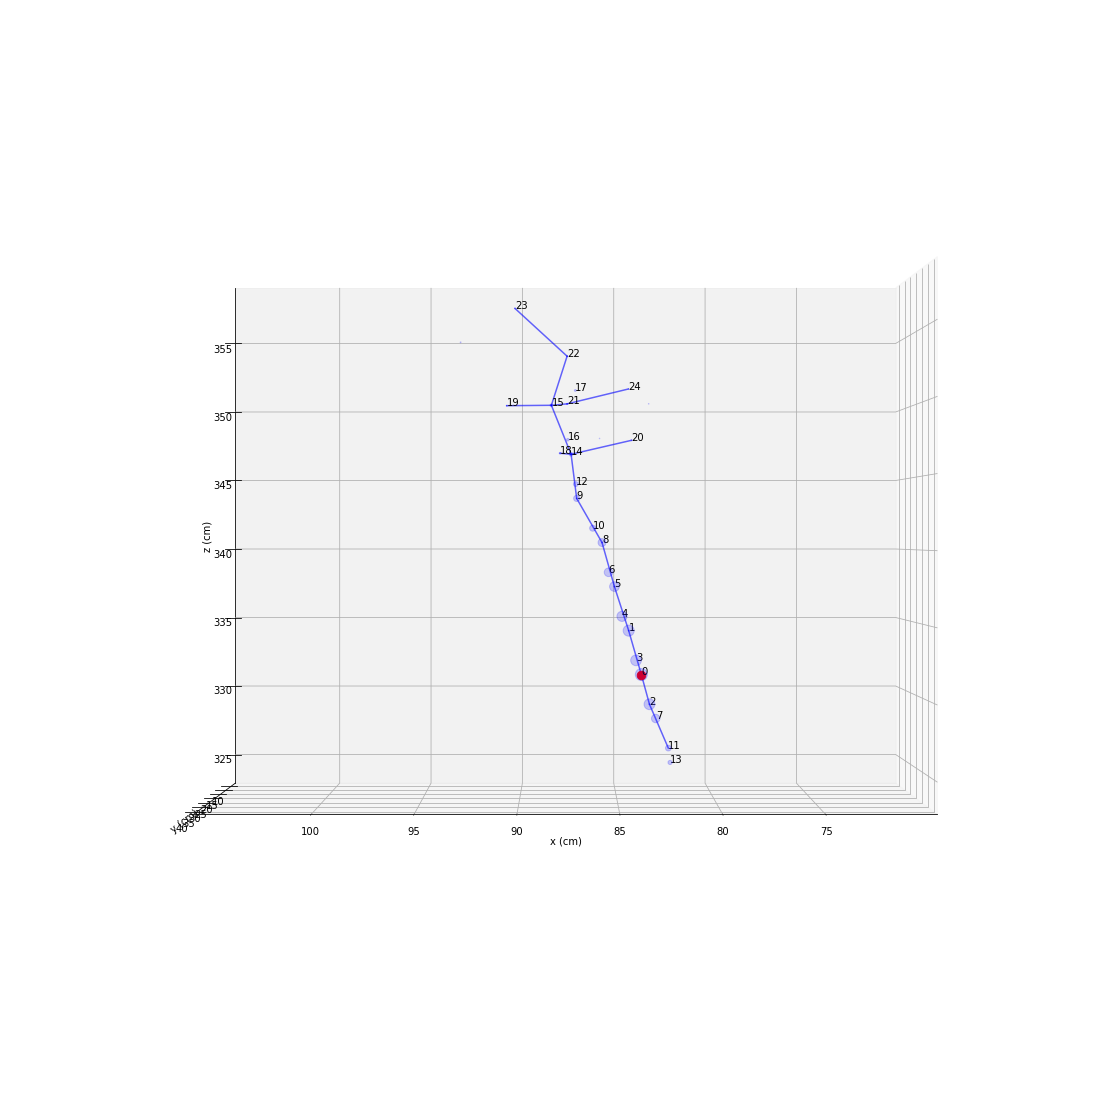

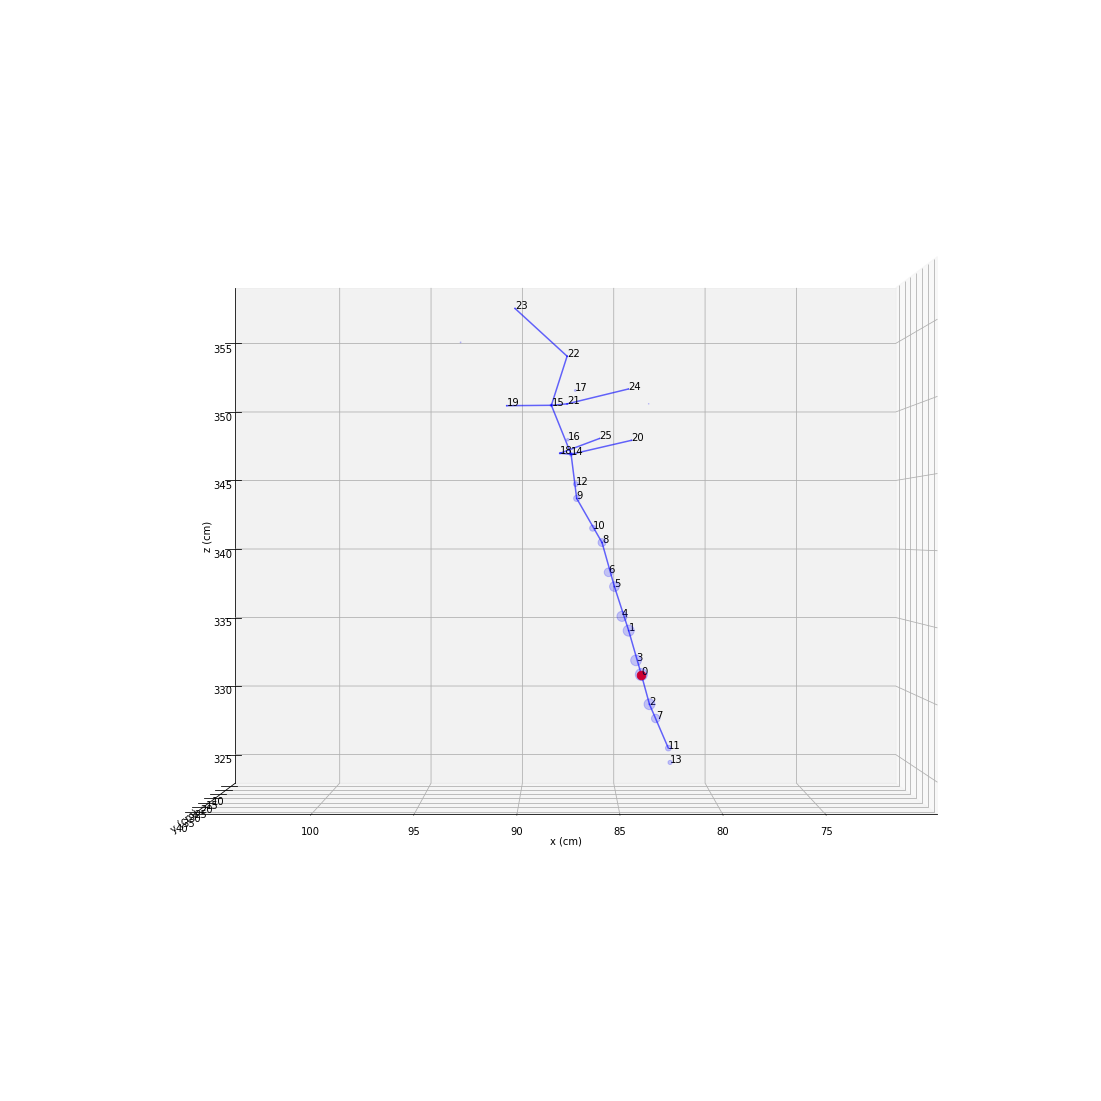

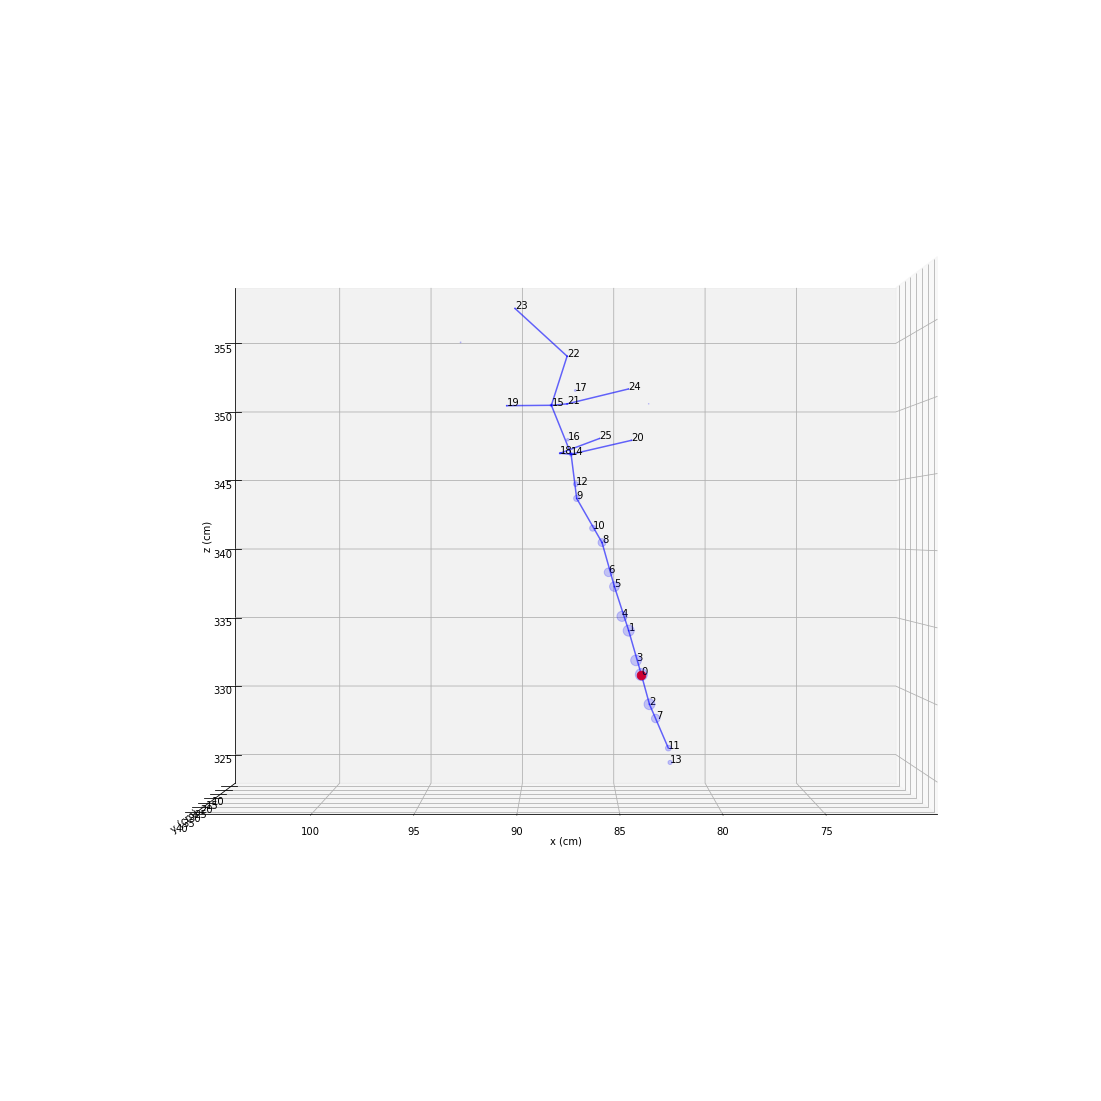

In [23]:
%matplotlib inline
MAX_ITER = 30
ANGLE_THR = 1.5 # ~ 85 degrees
DST_threshold = 2 # 2 cm - if the LC are further than 2 cm apart, we connect them with an edge
all_edges, all_nodes = [], []

for MAX_ITER in range(28):
    create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR=1.5, sort_by_z=False, MAX_ITER=MAX_ITER)

In [24]:
%matplotlib widget

def create_graph_pca(vx, vy, vz, ve, vi, bx, by, bz, be, bigTracksters, ev=0, DST_threshold=2):
    # Project the poits on pca
    edges = {}
    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]
    
    bubble_size = 10
    pileup_alpha = 0.5
    noise_threshold = 0.2


    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    for bigT in bigTracksters:

        vxt = vx[ev][bigT]
        vyt = vy[ev][bigT]
        vzt = vz[ev][bigT]
        vet = ve[ev][bigT]
        vit = vi[ev][bigT]

        bxt = bx[ev][bigT]
        byt = by[ev][bigT]
        bzt = bz[ev][bigT]
        bet = be[ev][bigT]

        pca = WPCA(n_components=3)
        positions = np.array((vxt, vyt, vzt)).T
        vet_array = np.array(vet).reshape(-1,1)
        vet_array = np.tile(vet_array,(1, 3))
        pca.fit(positions, weights = vet_array)
        components = pca.components_
        eigenvalues = pca.explained_variance_

        seed_lc_idx = trk_data.layer_cluster_seed[ev][bigT]
        seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
        edges[(-1, -1)] = (seed_coord, seed_coord)

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        
        ax.scatter(bxt, byt, bzt, s=bet*bubble_size/5, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        segment_start = np.array([bxt, byt, bzt])
        segment_end = np.array([bxt+components[0][0],
                                byt+components[0][1],
                                bzt+components[0][2]])

        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

        # project each LC to the principal component
        min_p, max_p = (0,0,99999), (0,0,-99999)
        for x,y,z,e,i,j in data:
            point = np.array([x, y, z])
            dist, closest_point = project_lc_to_pca(np.array([x,y,z]), segment_start, segment_end)

            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point
                
            if dist > DST_threshold:
                # find distance to closest edge
                min_dist, min_edge, closest_point_edge, closest_endpoint, closest_endpoint_id =  find_dist_to_closest_edge(np.array([x,y,z]), edges)
                if min_dist > DST_threshold:
                    # plot the new edge
                    edges[(closest_endpoint_id, j)] = (closest_point_edge, point)
                    ax.plot([x, closest_point[0]], [y, closest_point[1]], [z, z_cl], c='blue', alpha=0.4)
                    # add it to the edge list

        break

    ax.plot([min_p[0], max_p[0]], [min_p[1], max_p[1]], [min_p[2], max_p[2]], c='blue', alpha=0.4)

    set_axes_equal(ax)
    plt.show()


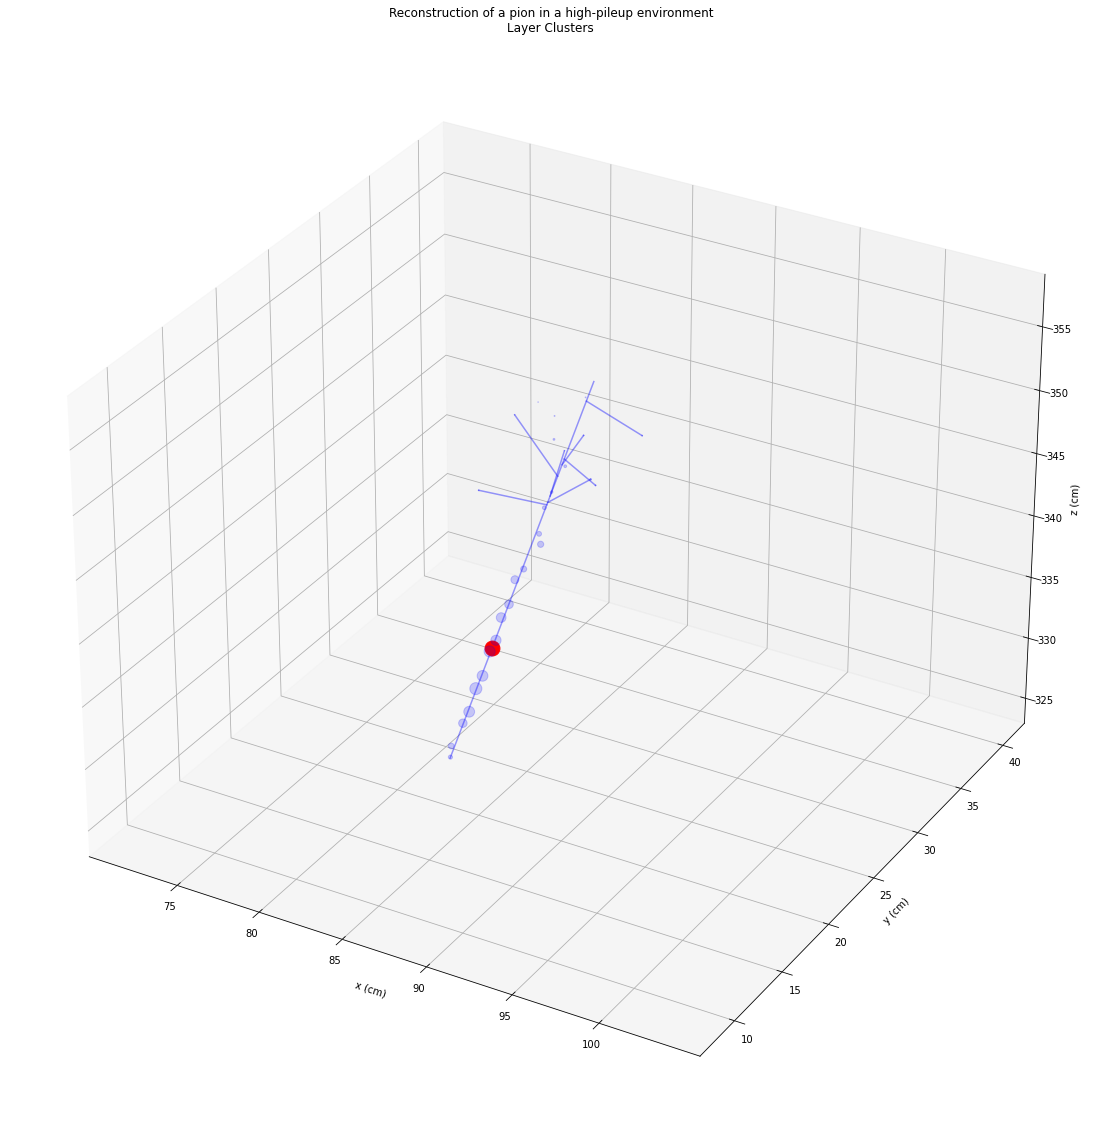

In [25]:
%matplotlib inline
create_graph_pca(vx, vy, vz, ve, vi, bx, by, bz, be, bigTracksters, DST_threshold=2)

# Hackathon Graph
Based on the distance VS energy "density" plots, we estimated that the threshold to use will be 0.1-0.2 m distance in x-y plane

In [26]:
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def distance_matrix(trk_x, trk_y, trk_z):
    v_matrix = np.concatenate(([trk_x], [trk_y], [trk_z]))
    gram = v_matrix.T.dot(v_matrix)

    distance = np.zeros(np.shape(gram))
    for row in range(np.shape(distance)[0]):
        for col in range(np.shape(distance)[1]): #half of the matrix is sufficient, but then mask doesn't work properly
            distance[row][col] = (gram[row][row]-2*gram[row][col]+gram[col][col])**0.5 #= 0 if row==col else
    #print('\n'.join(['\t'.join([str("{:.2f}".format(cell)) for cell in row]) for row in distance]))
    return distance

In [27]:
def create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=0, DST_THR=2, pca_length=30, bubble_size = 10, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05):
    # Project the poits on pca
    edges = {}
    
    bigTracksters = get_major_PU_tracksters(
    zip(reco2sim_index[ev], reco2sim_sharedE[ev], reco2sim_score[ev]),
    sim_raw_energy[ev],
    )
    print(bigTracksters)
    
    
    pileup_alpha = 0.5
    noise_threshold = 0.2

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")
    
    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]

    for bigT in bigTracksters:

        vxt = vx[ev][bigT]
        vyt = vy[ev][bigT]
        vzt = vz[ev][bigT]
        vet = ve[ev][bigT]
        vit = vi[ev][bigT]
        
        dist_matrix = distance_matrix(vxt, vyt, vzt)
        
        seed_lc_idx = trk_data.layer_cluster_seed[ev][bigT]
        
        seed_x = lcx[seed_lc_idx]
        seed_y = lcy[seed_lc_idx]
        seed_z = lcz[seed_lc_idx]
        seed_e = lce[seed_lc_idx]
        
        vz_seed = lc_data.position_z[ev][seed_lc_idx]
        pca_lower_z = WPCA(n_components=3)
        pca_higher_z = WPCA(n_components=3)
        
        positions_higher_z = np.array((vxt[vzt >= vz_seed], vyt[vzt >= vz_seed], vzt[vzt >= vz_seed])).T
        positions_lower_z = np.array((vxt[vzt <= vz_seed], vyt[vzt <= vz_seed], vzt[vzt <= vz_seed])).T
        
        vet_array_higher_z = np.array(vet[vzt >= vz_seed]).reshape(-1,1)
        vet_array_higher_z = np.tile(vet_array_higher_z,(1, 3))
        
        vet_array_lower_z = np.array(vet[vzt <= vz_seed]).reshape(-1,1)
        vet_array_lower_z = np.tile(vet_array_lower_z,(1, 3))
        
        pca_lower_z.fit(positions_lower_z, weights = vet_array_lower_z)
        pca_higher_z.fit(positions_higher_z, weights = vet_array_higher_z)
        
        components_lower_z = pca_lower_z.components_
        eigenvalues_lower_z = pca_lower_z.explained_variance_
        
        components_higher_z = pca_higher_z.components_
        eigenvalues_higher_z = pca_higher_z.explained_variance_
        
        seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
        edges[(-1, -1)] = (seed_coord, seed_coord)

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
        ax.scatter(seed_x, seed_y, seed_z, s=seed_e*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        if components_lower_z[0][2] < 0:
#             ax.plot([seed_x, seed_x+pca_length*components_lower_z[0][0]],
#              [seed_y, seed_y+pca_length*components_lower_z[0][1]],
#              [seed_z, seed_z+pca_length*components_lower_z[0][2]], c='red')
            
            lower_segment_end = np.array([seed_x+components_lower_z[0][0],
                                seed_y+components_lower_z[0][1],
                                seed_z+components_lower_z[0][2]])
        else:
#             ax.plot([seed_x, seed_x-pca_length*components_lower_z[0][0]],
#              [seed_y, seed_y-pca_length*components_lower_z[0][1]],
#              [seed_z, seed_z-pca_length*components_lower_z[0][2]], c='red')
            
            lower_segment_end = np.array([seed_x-components_lower_z[0][0],
                                seed_y-components_lower_z[0][1],
                                seed_z-components_lower_z[0][2]])
            
        if components_higher_z[0][2] < 0:        
#             ax.plot([seed_x, seed_x-pca_length*components_higher_z[0][0]],
#              [seed_y, seed_y-pca_length*components_higher_z[0][1]],
#              [seed_z, seed_z-pca_length*components_higher_z[0][2]], c='green')
            
            higher_segment_end = np.array([seed_x-components_higher_z[0][0],
                                seed_y-components_higher_z[0][1],
                                seed_z-components_higher_z[0][2]])
            
        else:
#             ax.plot([seed_x, seed_x+pca_length*components_higher_z[0][0]],
#              [seed_y, seed_y+pca_length*components_higher_z[0][1]],
#              [seed_z, seed_z+pca_length*components_higher_z[0][2]], c='green')
            
            higher_segment_end = np.array([seed_x+components_higher_z[0][0],
                                seed_y+components_higher_z[0][1],
                                seed_z+components_higher_z[0][2]])

        segment_start = np.array([seed_x, seed_y, seed_z])

        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

        # project each LC to the principal component
        min_p, max_p = (0,0,99999), (0,0,-99999)
        
        for x,y,z,e,i,j in data:
            
            point = np.array([x, y, z])
            # if energy density is low: don't do anything for now 
            # else - create main edges
            
           

            if z > seed_z:
                dist, closest_point = project_lc_to_pca(point, segment_start, higher_segment_end)
            else:
                dist, closest_point = project_lc_to_pca(point, segment_start, lower_segment_end)

            

            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point
                
            #ax.text(x, y, z, str(j))
            
            print(j, e/seed_e, dist)
            if e / seed_e > ENERGY_RATIO_THR and dist > DST_THR:
                # and not covered by any other edges
                min_dist, min_edge, closest_point_edge, closest_endpoint, closest_endpoint_id =  find_dist_to_closest_edge(point, edges)
                if min_dist < DST_THR:
                    continue
                
                print(f"big: {dist}")
                
                # find neares higher
                # go through all points, if the point is within the Neighbour_threshold = 10
                distances = dist_matrix[j]
                indices = np.argsort(distances)
                for idx in indices:
                
                    if distances[idx] < NEIGHBOUR_THR and vet[idx] > e and abs(vzt[idx]) < abs(z):
                        # found the nearest higher
                        # create an edge - to projection of the nearest higher to the pca
                        #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                        #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                        nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                        if z > seed_z:
                            dist, closest_point = project_lc_to_pca(nearest_higher, segment_start, higher_segment_end)
                        else:
                            dist, closest_point = project_lc_to_pca(nearest_higher, segment_start, lower_segment_end)
                            
                        edges[(idx, j)] = (closest_point, point)
                        ax.plot([closest_point[0], x], [closest_point[1], y], [closest_point[2], z], c='blue')

                        break
        
        ax.plot([seed_x, min_p[0]], [seed_y, min_p[1]], [seed_z, min_p[2]], c='red')
        ax.plot([seed_x, max_p[0]], [seed_y, max_p[1]], [seed_z, max_p[2]], c='green')
        
        break

    set_axes_equal(ax)
    plt.show()
    return edges


[0, 1]
0 0.12019902692262735 0.005155032068320262
1 0.22802583800246948 0.16538472889047562
2 0.4976839650817751 0.018989219341694466
3 0.809240472498882 0.10403078698875974
4 1.0 0.0
5 0.8012947351851746 0.16644775861476271
6 0.8471547195785217 0.15519411670029903
7 0.7175043221535208 0.13581837348376444
8 0.6477229290910286 0.1430224571497156
9 0.516007080681712 0.10414033802360152
10 0.4347343471540289 0.17752618155060657
11 0.2554799078650992 0.06247885302675779
12 0.26413635107562305 0.42728873982827376
13 0.16237289665226573 0.21338737394953636
14 0.10044056266831534 0.12481707867527227
15 0.022144374645576177 3.6791251280680983
16 0.007060277983391011 3.626850484415552
17 0.0023193182000568195 4.730953270869751
18 0.04822816948222498 0.31009717153162475
19 0.00804939836833319 2.5754026458338743
20 0.0028309325466793567 5.9046573866049314
21 0.007026170188984161 3.404502618734407
22 0.054589252840208886 0.13842489316837417
23 0.0028309325466793567 5.671534785942963
24 0.024796240

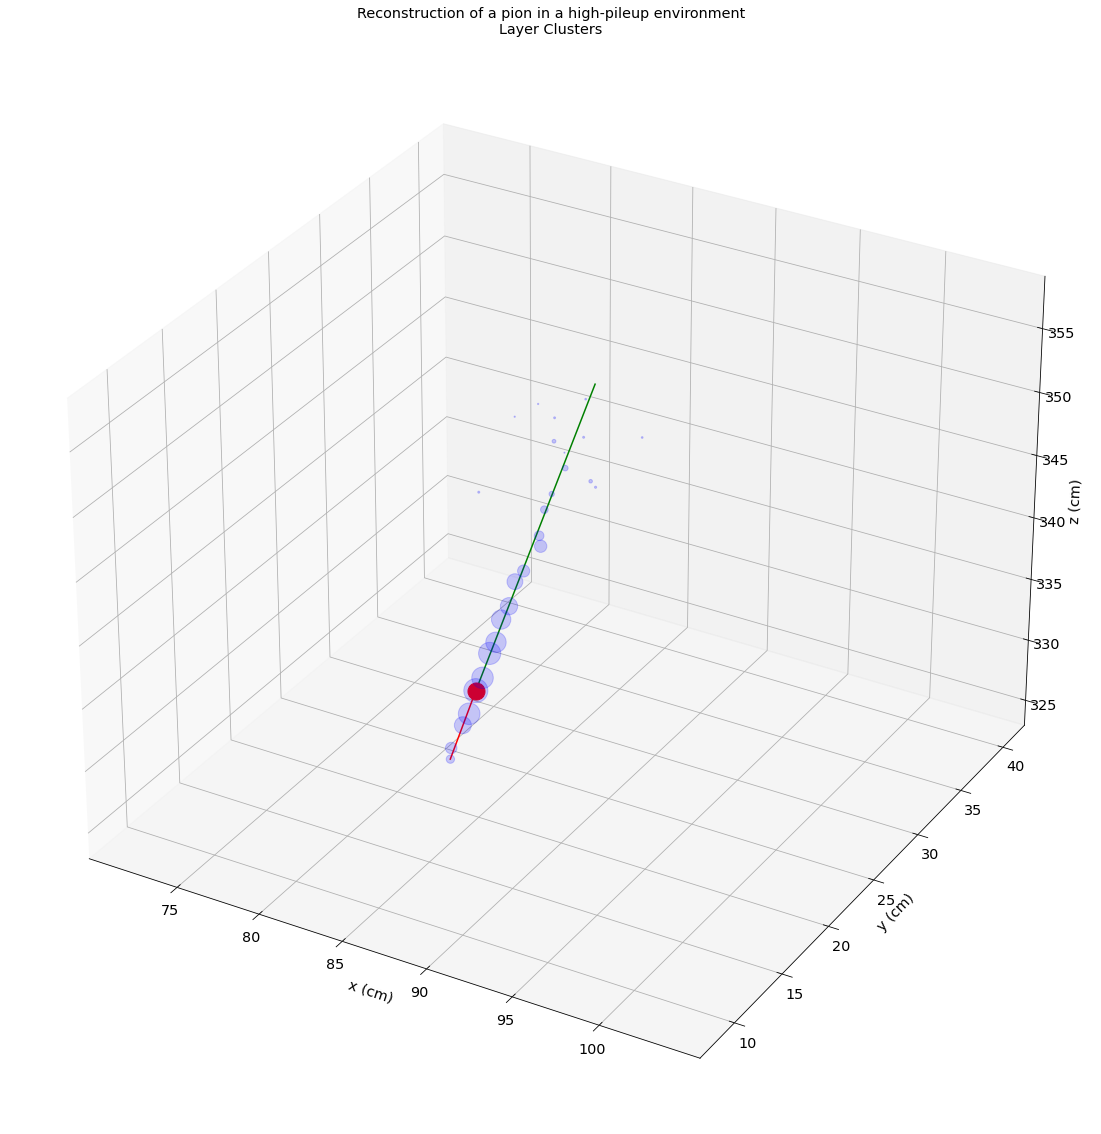

In [28]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=0, DST_THR=2, bubble_size=40, ENERGY_RATIO_THR=0.05)
plt.show()

[0, 1]
0 0.12230973667860079 0.24040443031810882
1 0.37710598232210074 0.27756597866668214
2 0.5807167933911492 0.20268218656894266
3 0.7472390098169107 0.042937507721598815
4 1.0321509830961921 0.03173604857772067
5 0.019222792983409915 3.966406365812918
6 1.0 0.0
7 0.9592173858393885 0.19425653086928119
8 0.7485204761250257 0.2846761514328798
9 0.712336425271047 0.8494360511086535
10 0.37284678660060405 0.7907963248895918
11 0.2742829051474785 0.3450016983818638
12 0.18661185455970544 0.44292075909704626
13 0.1410425351777319 0.9950212747879846
14 0.04266706708230866 1.6417348891517534
15 0.027089296163699657 3.148212966914453
16 0.044791208140938815 2.407693920161976
17 0.025390625997952106 4.970881477868235
18 0.009566186267425362 3.1480977425755206


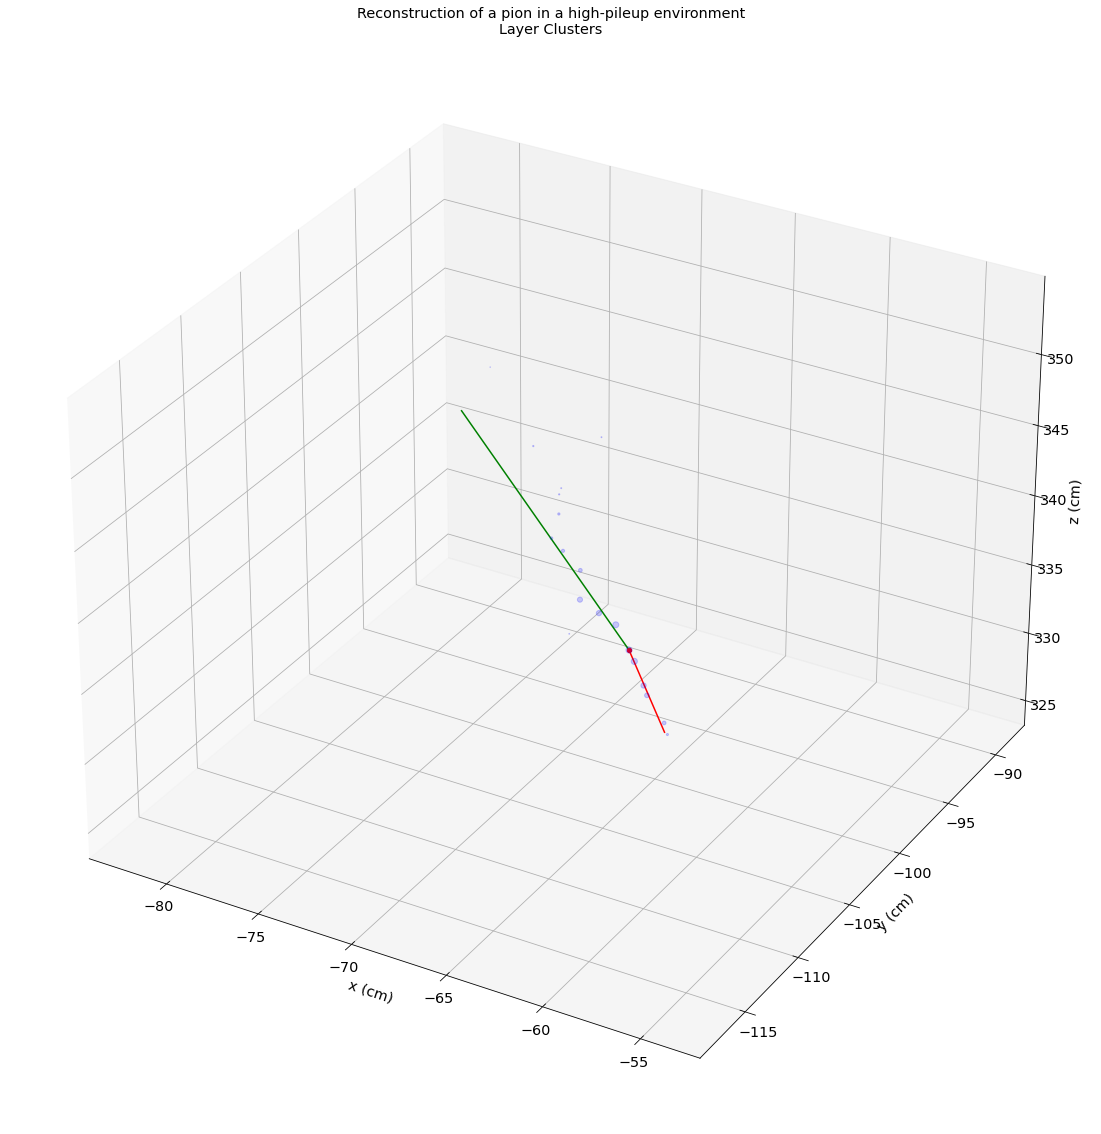

{(-1, -1): (array([ -66.27864838, -100.29718781,  332.32000732]),
  array([ -66.27864838, -100.29718781,  332.32000732]))}

In [29]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=1, DST_THR=2, ENERGY_RATIO_THR=0.05)

[0, 1]
0 0.031611845775682476 0.5052427725801975
1 0.10988359665680618 0.2660001476515643
2 0.22517823106677448 0.16864405090805956
3 0.43510970398614 0.18172723870457033
4 0.6301044727119968 0.11294058342879988
5 0.8449398260049407 0.07942726253730042
6 0.9201026413954001 0.09339561450913961
7 1.0 0.0
8 0.6920214093222072 0.19816597828166477
9 0.7059234293076018 0.20555127000801585
10 0.40078341158489206 0.1212380362094439
11 0.2631964538594272 0.42927416997184503
12 0.2042104456725847 0.5870928161845964
13 0.14612630128387477 0.22511133788825444
14 0.008787408879751858 4.098541939672668
15 0.005782190989174605 6.01992113352346
16 0.016433595813987997 4.568308352802453
17 0.04376246379830017 0.13659414067413986
18 0.024003699472244337 3.2998051829075057
19 0.026362226639255578 3.3476322796270495
20 0.010934813517050293 3.569579040849145
21 0.012058911185915119 2.9907039152928183
22 0.03828304980156225 1.8579647516213733
23 0.01530024003719616 3.568875878903959
24 0.025357474159968117 

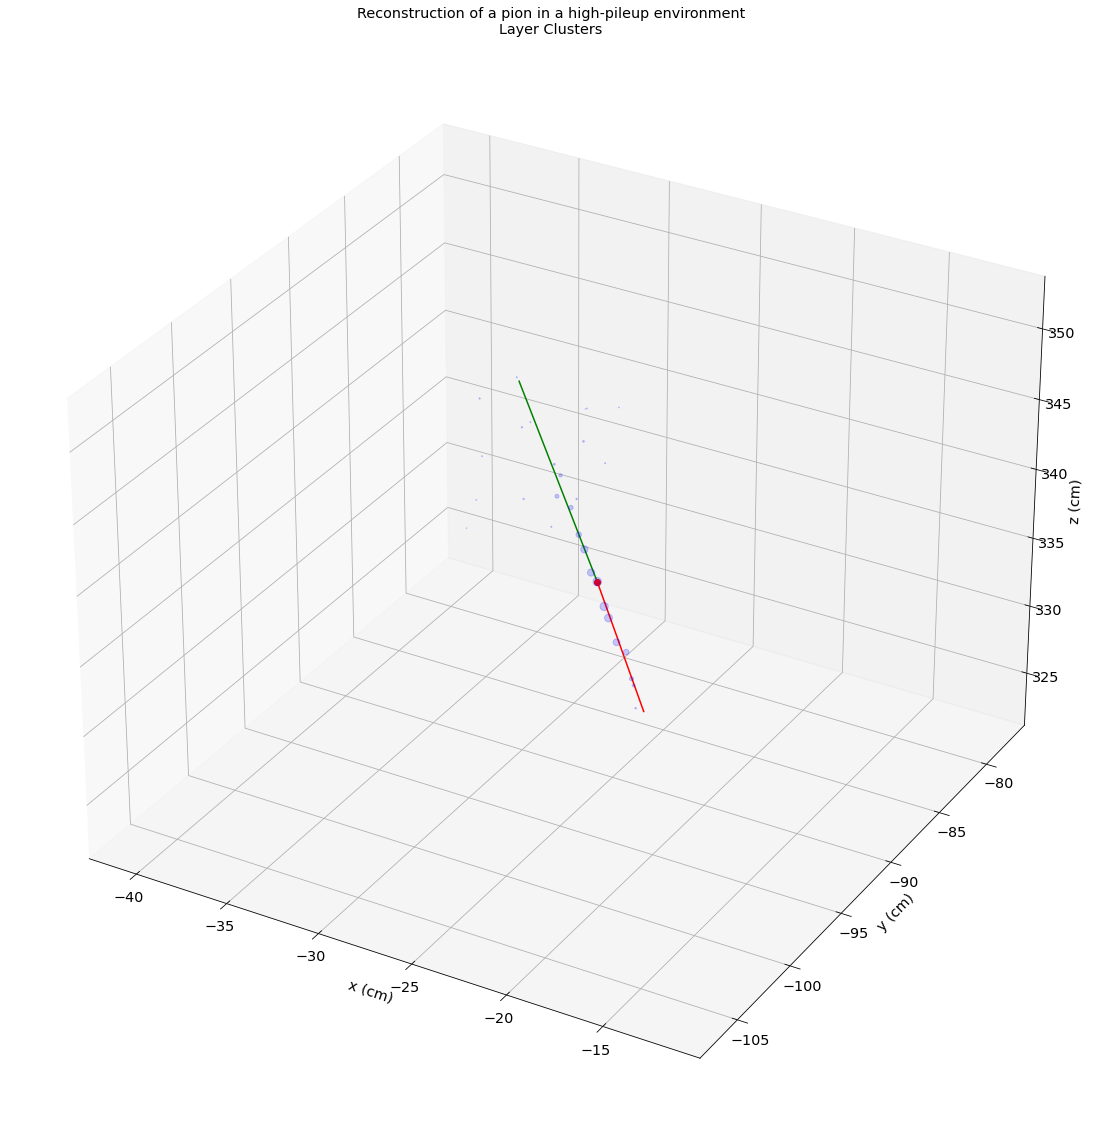

{(-1, -1): (array([-26.3593483 , -89.13424683, 334.38299561]),
  array([-26.3593483 , -89.13424683, 334.38299561]))}

In [30]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=2, DST_THR=2, ENERGY_RATIO_THR=0.05)

[0, 1]
0 0.13390021144626302 0.337571091918935
1 0.33414586534278046 0.19167083784436437
2 0.5609978329910819 0.08052082765112303
3 0.8311396659317193 0.24648911094712517
4 1.0 0.0
5 0.9176661671266219 0.16459252012507952
6 0.8769930807047929 0.24748651226212257
7 0.6821345773491869 0.15911034011131128
8 0.5589856254374479 0.04901167753828602
9 0.007101240013577961 4.249944171474581
10 0.003007948627727415 5.0446820140743815
11 0.01203179533194541 4.765267283045979
12 0.45704619449272865 0.14065443020529733
13 0.00291491952995769 4.89537243401651
14 0.4050121276832762 0.11011261723694155
15 0.012620981259891839 3.995934884056775
16 0.2867927795094699 0.2820965786540909
17 0.019660200232885148 3.638105370212394
18 0.007773609999611158 4.165462930333403
19 0.013874009896567887 5.183524564823068
20 0.2710327289809593 0.4222702646082279
21 0.12281913199837736 0.7958473122749639
22 0.03383167138182024 3.4461009733374026
23 0.21074247116785175 0.7173505308546403
24 0.011752706396564734 5.769

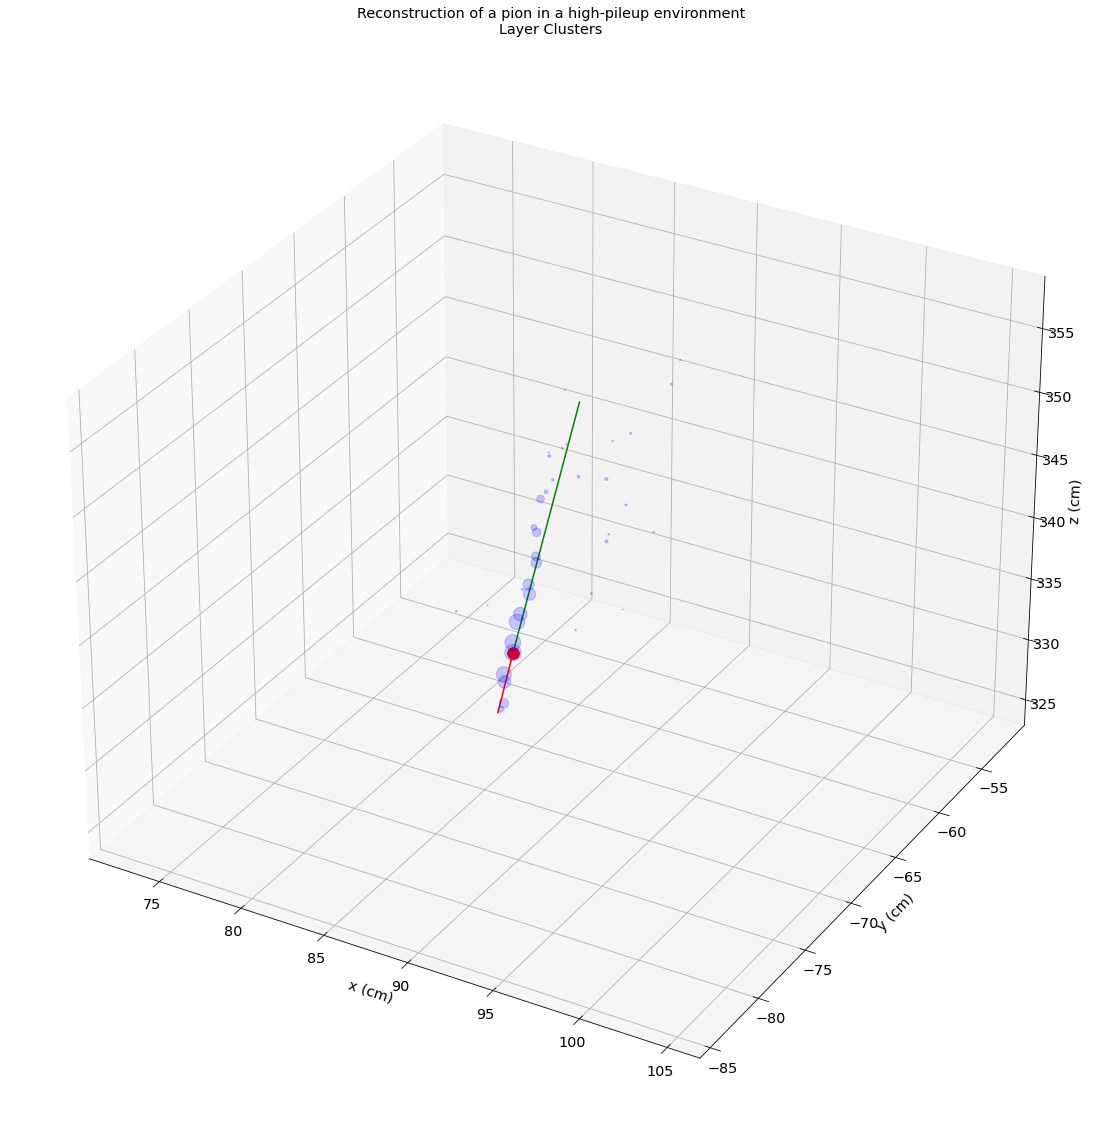

{(-1, -1): (array([ 84.54052734, -66.20721436, 331.32598877]),
  array([ 84.54052734, -66.20721436, 331.32598877]))}

In [31]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=3, DST_THR=2, ENERGY_RATIO_THR=0.05, bubble_size=30)

[0, 1]
0 0.04499910995962834 0.45100225664999455
1 0.09107584027527517 0.21230039435077425
2 0.27838963717336374 0.1282627106930416
3 0.489915035603382 0.12746807389267006
4 0.7836466774162653 0.08203361706740314
5 0.7129540280894621 0.06359260639357642
6 0.007983518739266943 3.4507519245297207
7 0.8990214150428486 0.15956241849751795
8 1.0 0.0
9 0.7448622993860194 0.25263633855933526
10 0.5431367402421593 0.09795605777330477
11 0.5133145562892515 0.28875486082321145
12 0.2961885596767062 0.16492816346925698
13 0.3019830111261526 0.03246244287463611
14 0.032088598718318304 3.39971082446317
15 0.18714914531973656 0.12997531188562297
16 0.12490344151692567 1.2391535190975351
17 0.01594343535732794 2.8820560577322842
18 0.06267420139934846 0.4058907975398432
19 0.051128953773152686 0.7314669018475727
20 0.004764704909353128 3.6972418050232743
21 0.010628958132053246 3.4314094956832415
22 0.07541062168642564 1.8029623232389536
23 0.010995472088958328 2.185203675822015
24 0.0249135317826878

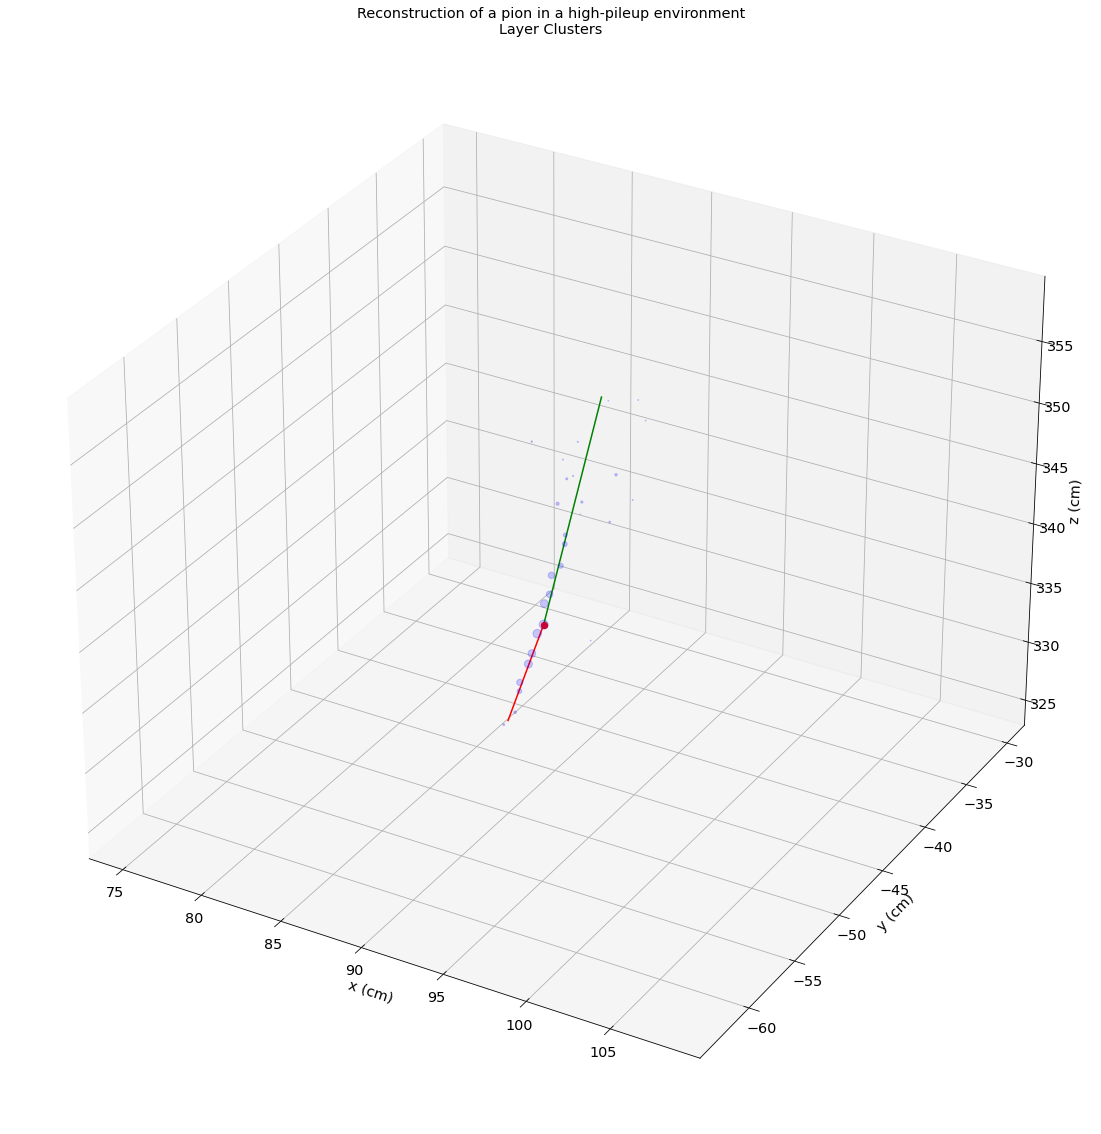

{(-1, -1): (array([ 89.55866241, -45.43873978, 335.37701416]),
  array([ 89.55866241, -45.43873978, 335.37701416]))}

In [32]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=4, DST_THR=2, ENERGY_RATIO_THR=0.05)

[0, 1]
0 0.0689875666069933 0.02487239851640654
1 0.18203487885662584 0.16968843437557146
2 0.003682954853791501 2.610395881925719
3 0.010351041722286361 2.8976879947710166
4 0.48754569048443896 0.08226379263063621
5 0.6772759789346581 0.04547704662748112
6 0.9285891467914286 0.04764779318250821
7 0.9462092559020292 0.030534615900209713
8 0.007753588560813856 2.470601412974174
9 1.0 0.0
10 0.9976736427603233 0.07109873363338315
11 0.8282580142812457 0.03567099296293753
12 0.589121302718011 0.18079635400732919
13 0.6612786335444464 0.12260085097693658
14 0.4095636374796931 0.11110973403780737
15 0.36372376817529 0.17817653517789428
16 0.22597670636669098 0.11514985384559324
17 0.16385793339006366 0.05823530054302332
18 0.11670802319441127 0.1818913005663019
19 0.09235762006286305 0.3346864391503711
20 0.0070806356905433 2.316684709852168
21 0.060595454642918406 0.5359132573962809
22 0.012643992656465998 3.42901800184741
23 0.02725036475133109 1.6831191163272397
24 0.00817510975386209 5.

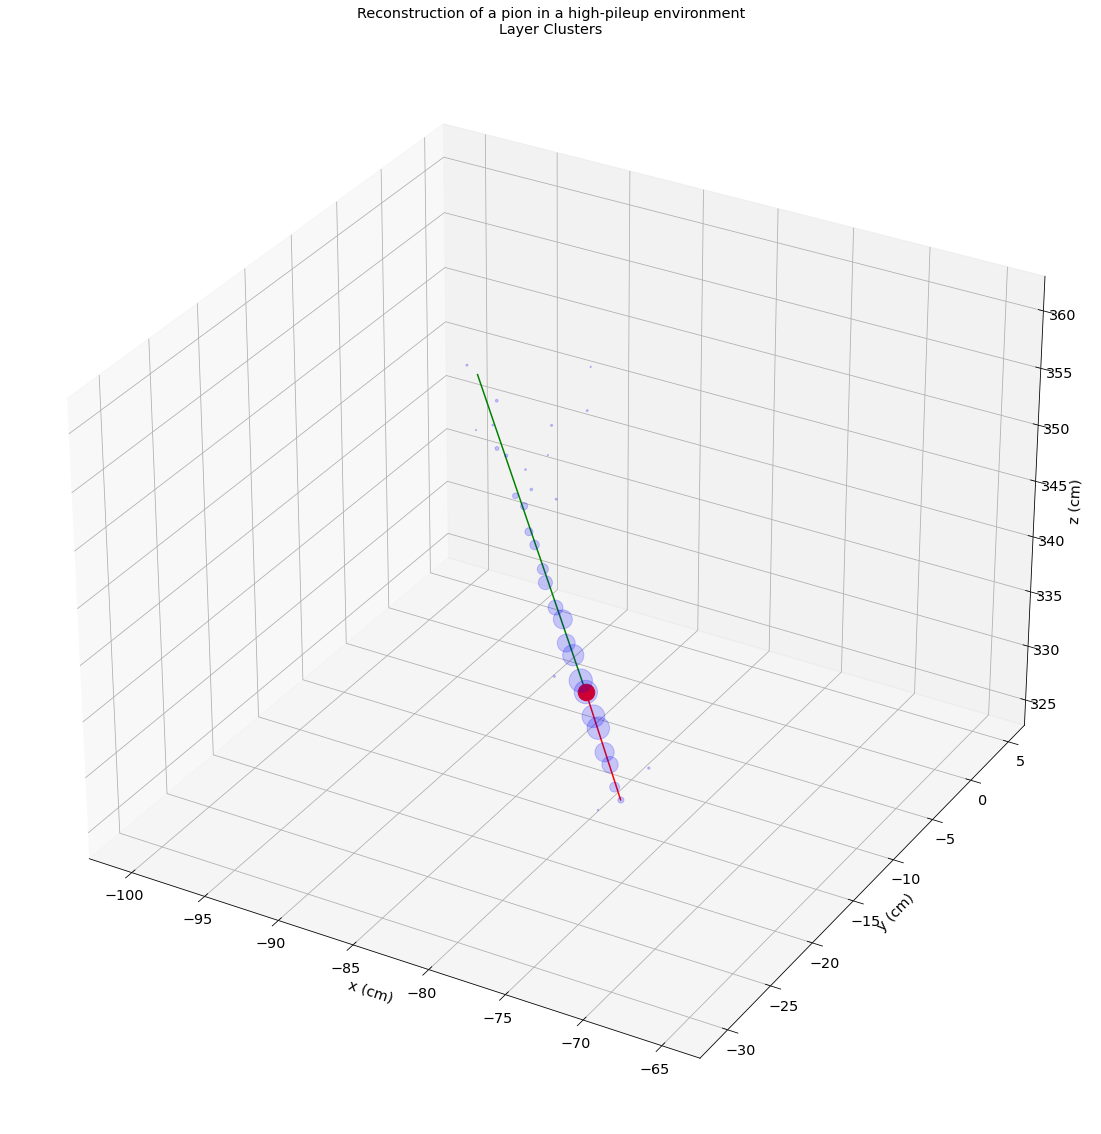

{(-1, -1): (array([-80.1049118 , -15.27165985, 334.38299561]),
  array([-80.1049118 , -15.27165985, 334.38299561]))}

In [33]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=6, DST_THR=2, ENERGY_RATIO_THR=0.05, bubble_size=30)

[0, 1]
0 0.08929344977449652 0.39642606089464777
1 0.20206503998968103 0.22824218892395398
2 0.3198681928630703 0.3740267244725976
3 0.6067059418246509 0.20069165282356344
4 0.7120969437549814 0.10196066890955349
5 0.8676694593955806 0.30325846042230425
6 1.0 0.0
7 0.7187387462618018 0.13817506935178173
8 0.8551660203650256 0.30469184476132966
9 0.011990100083012047 6.88568298631494
10 0.4126235068642677 0.06789949902927969
11 0.49426278368740123 0.27848759193014183
12 0.019966097472936973 4.996392196265209
13 0.013691037518238977 2.918050587023599
14 0.2168154987134857 0.263183845802982
15 0.1003932820355482 0.157619468393799
16 0.010920234074492571 2.651009976120808
17 0.04076706854239533 2.777278544746479
18 0.0037950319615484697 3.9161591379729424
19 0.1671423021448367 0.7867850575775799
20 0.063094030784263 0.6869087115682891
21 0.10158008542216383 0.6771113712274485
22 0.022953616925827286 1.0720780896157867
23 0.015270840723210418 2.057389358653293


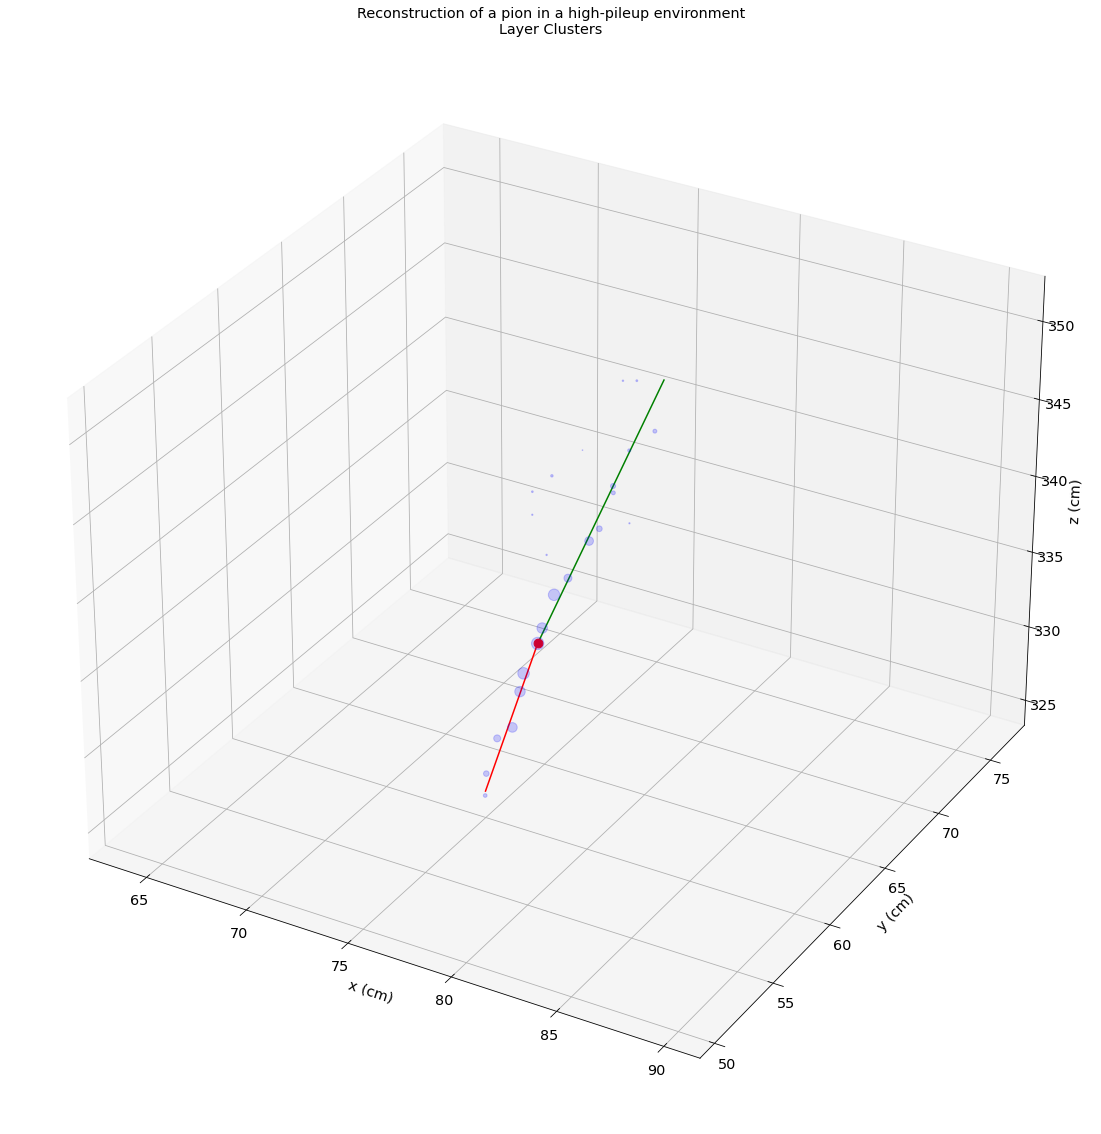

{(-1, -1): (array([ 76.62827301,  61.66090393, 334.38299561]),
  array([ 76.62827301,  61.66090393, 334.38299561]))}

In [34]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=7, DST_THR=2, ENERGY_RATIO_THR=0.05, bubble_size=30)

# Event Graph Creation

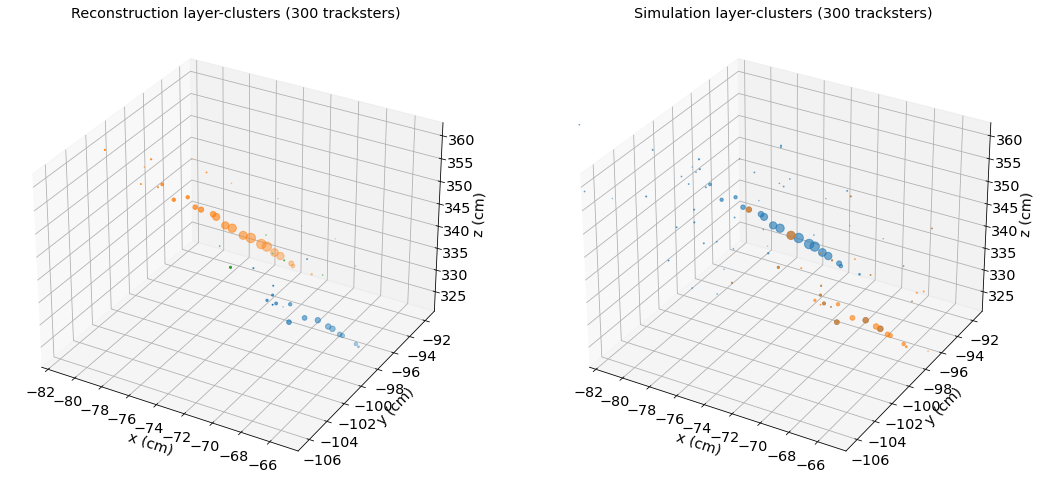

In [35]:
eid = 1
trk_id = 0

fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(121, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid], vy[eid], vz[eid], ve[eid]):
    ax1.scatter(x, y, z, s=8*e)

ax1.set_title(f"Reconstruction layer-clusters ({len(vx)} tracksters)")


ax2 = fig.add_subplot(122, projection='3d')
ax2.set_xlabel("x (cm)")
ax2.set_ylabel("y (cm)")
ax2.set_zlabel("z (cm)")
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
ax2.set_zlim(ax1.get_zlim())

for x, y, z, e in zip(vx_sim[eid], vy_sim[eid], vz_sim[eid], ve_sim[eid]):
    ax2.scatter(x, y, z, s=8*e, alpha=0.6)

ax2.set_title(f"Simulation layer-clusters ({len(vx_sim)} tracksters)")

plt.show()

In [99]:
def find_dist_to_closest_edge_set(point, edges):
    """
    point: np.array (x,y,z)
    edges: set
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    point = np.array(point)
    
    for (segment_start, segment_end) in edges:
        
        segment_start, segment_end = np.array(segment_start), np.array(segment_end)
        dist, closest_point_tmp, closest_endpoint_tmp = distance_point_to_segment_set(point, segment_start, segment_end)
        
        if dist < min_dist:
            min_dist = dist
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            
    return min_dist, min_edge, closest_point, closest_endpoint

def distance_point_to_segment_set(point, segment_start, segment_end):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        
        return np.linalg.norm(point_vector), segment_start, segment_start
    elif projection > 1:
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint

def create_tr_skeletons(vx, vy, vz, ve, vi, ev, tr_id, DST_THR=2, bubble_size=10, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05):
    # Project the poits on pca
    edges = set()
    nodes = set()

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")
    
    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]

    vxt = vx[ev][tr_id]
    vyt = vy[ev][tr_id]
    vzt = vz[ev][tr_id]
    vet = ve[ev][tr_id]
    vit = vi[ev][tr_id]

    dist_matrix = distance_matrix(vxt, vyt, vzt)

    seed_lc_idx = trk_data.layer_cluster_seed[ev][tr_id]

    seed_x = lcx[seed_lc_idx]
    seed_y = lcy[seed_lc_idx]
    seed_z = lcz[seed_lc_idx]
    seed_e = lce[seed_lc_idx]

    vz_seed = lc_data.position_z[ev][seed_lc_idx]
    pca_lower_z = WPCA(n_components=3)
    pca_higher_z = WPCA(n_components=3)

    positions_higher_z = np.array((vxt[vzt >= vz_seed], vyt[vzt >= vz_seed], vzt[vzt >= vz_seed])).T
    positions_lower_z = np.array((vxt[vzt <= vz_seed], vyt[vzt <= vz_seed], vzt[vzt <= vz_seed])).T

    vet_array_higher_z = np.array(vet[vzt >= vz_seed]).reshape(-1,1)
    vet_array_higher_z = np.tile(vet_array_higher_z,(1, 3))

    vet_array_lower_z = np.array(vet[vzt <= vz_seed]).reshape(-1,1)
    vet_array_lower_z = np.tile(vet_array_lower_z,(1, 3))

    pca_lower_z.fit(positions_lower_z, weights = vet_array_lower_z)
    pca_higher_z.fit(positions_higher_z, weights = vet_array_higher_z)

    components_lower_z = pca_lower_z.components_
    eigenvalues_lower_z = pca_lower_z.explained_variance_

    components_higher_z = pca_higher_z.components_
    eigenvalues_higher_z = pca_higher_z.explained_variance_

    seed_coord = np.array([seed_x, seed_y, seed_z])
    nodes.add(tuple(seed_coord))

    
    ax.scatter(seed_x, seed_y, seed_z, s=seed_e*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

    if components_lower_z[0][2] < 0:

        lower_segment_end = np.array([seed_x+components_lower_z[0][0],
                            seed_y+components_lower_z[0][1],
                            seed_z+components_lower_z[0][2]])
    else:
        lower_segment_end = np.array([seed_x-components_lower_z[0][0],
                            seed_y-components_lower_z[0][1],
                            seed_z-components_lower_z[0][2]])

    if components_higher_z[0][2] < 0:
        higher_segment_end = np.array([seed_x-components_higher_z[0][0],
                            seed_y-components_higher_z[0][1],
                            seed_z-components_higher_z[0][2]])

    else:
        higher_segment_end = np.array([seed_x+components_higher_z[0][0],
                            seed_y+components_higher_z[0][1],
                            seed_z+components_higher_z[0][2]])

    data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

    # project each LC to the principal component
    min_p, max_p = (0,0,99999), (0,0,-99999)

    for x,y,z,e,i,j in data:

        point = np.array([x, y, z])
        # if energy density is low: don't do anything for now 
        # else - create main edges
        if z > seed_z:
            dist, closest_point = project_lc_to_pca(point, seed_coord, higher_segment_end)
        else:
            dist, closest_point = project_lc_to_pca(point, seed_coord, lower_segment_end)

        z_cl = closest_point[2]
        if min_p[2] > z_cl:
            min_p = closest_point
        if max_p[2] < z_cl:
            max_p = closest_point
         
        if dist < DST_THR:
            ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="green", zorder=-5)
        else:
            ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="blue", zorder=-5)
            

        #ax.text(x, y, z, str(j))

        print(j, e/seed_e, dist)
        if e / seed_e > ENERGY_RATIO_THR and dist > DST_THR:
            # and not covered by any other edges
            min_dist, min_edge, closest_point_edge, closest_endpoint =  find_dist_to_closest_edge_set(point, edges)
            if min_dist < DST_THR:
                continue

            #print(f"big: {dist}")

            # find neares higher
            # go through all points, if the point is within the Neighbour_threshold = 10
            distances = dist_matrix[j]
            indices = np.argsort(distances)
            for idx in indices:

                if distances[idx] < NEIGHBOUR_THR and vet[idx] > e and abs(vzt[idx]) < abs(z):
                    # found the nearest higher
                    # create an edge - to projection of the nearest higher to the pca
                    #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                    #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                    nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                    if z > seed_z:
                        dist, closest_point = project_lc_to_pca(nearest_higher, seed_coord, higher_segment_end)
                    else:
                        dist, closest_point = project_lc_to_pca(nearest_higher, seed_coord, lower_segment_end)
                        
                    if not np.allclose(closest_point, point, atol=0.1):
                        edges.add((tuple(closest_point), tuple(point)))
                        nodes.add(tuple(closest_point))
                        nodes.add(tuple(point))
                    ax.plot([closest_point[0], x], [closest_point[1], y], [closest_point[2], z], c='blue')

                    break

    ax.plot([seed_x, min_p[0]], [seed_y, min_p[1]], [seed_z, min_p[2]], c='red')
    ax.plot([seed_x, max_p[0]], [seed_y, max_p[1]], [seed_z, max_p[2]], c='green')
    if not np.allclose(min_p, seed_coord, atol=0.1):
        edges.add((tuple(min_p), tuple(seed_coord)))
        nodes.add(tuple(min_p))
    if not np.allclose(max_p, seed_coord, atol=0.1):
        edges.add((tuple(max_p), tuple(seed_coord)))
        nodes.add(tuple(max_p))

    set_axes_equal(ax)
    plt.show()
    return edges, nodes


In [100]:
# create internal edges per each trackster
all_event_edges, all_event_nodes = [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes = create_tr_skeletons(vx, vy, vz, ve, vi, ev=eid,
                                                                tr_id=tr_id, DST_THR=2, bubble_size=50, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05)
    print(internal_trackster_edges)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 0.12230973667860079 0.24040443031810882
1 0.37710598232210074 0.27756597866668214
2 0.5807167933911492 0.20268218656894266
3 0.7472390098169107 0.042937507721598815
4 1.0321509830961921 0.03173604857772067
5 0.019222792983409915 3.966406365812918
6 1.0 0.0
7 0.9592173858393885 0.19425653086928119
8 0.7485204761250257 0.2846761514328798
9 0.712336425271047 0.8494360511086535
10 0.37284678660060405 0.7907963248895918
11 0.2742829051474785 0.3450016983818638
12 0.18661185455970544 0.44292075909704626
13 0.1410425351777319 0.9950212747879846
14 0.04266706708230866 1.6417348891517534
15 0.027089296163699657 3.148212966914453
16 0.044791208140938815 2.407693920161976
17 0.025390625997952106 4.970881477868235
18 0.009566186267425362 3.1480977425755206
{((-65.44802595659048, -98.28752796745844, 325.2166617251384), (-66.27864837646484, -100.29718780517578, 332.32000732421875)), ((-70.79280289510027, -107.75430193602647, 352.32929603755014), (-66.27864837646484, -100.29718780517578, 332.320007

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 0.033549093457808855 0.642863181999061
1 0.14107272862238238 0.08347388916675741
2 0.2861324674984818 0.16440718657588219
3 0.6122235931017479 0.039608523935997536
4 0.6768236182616204 0.12344929805260092
5 0.9741979606478043 0.07642409574683538
6 1.0 0.0
7 0.987799343260622 0.06450117304922431
8 0.7224220388168429 0.13734811649509623
9 0.778896630980184 0.08234369074920113
10 0.5946478998989415 0.17538352161826581
11 0.5590043053142834 0.15158262237130063
12 0.34817118000742825 0.13350156803873256
13 0.30785926172792566 0.202717232210328
14 0.0037094519807541514 3.3361166078146973
15 0.22197408704169927 0.28913135212189145
16 0.003305702157565968 4.8062344729270725
17 0.1248470160878656 0.3155234994598282
18 0.1244237901731627 0.58245914506858
19 0.08307888039080415 0.32128293599824637
20 0.01203087623916862 0.44321420181459964
21 0.008678989477494785 2.9856056869730536
22 0.01882442799346254 1.9763850696623129
23 0.007392104918378791 1.0063392184227262
24 0.0018854357188347473 0.68

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 0.06433029046090406 2.042872037025261
1 0.11041767145824506 2.1745439308080985
2 0.04272683617939118 2.1214851970049327
3 0.12914065648315168 1.8917014428578995
4 0.03264522396950457 3.2297094912027213
5 0.26980317728189246 0.3944316282560007
6 0.08113298595127234 2.7076519591208856
7 1.0 0.0
8 0.04384097907908265 1.2058310082691391e-13
{((-70.45701629269442, -99.30721573727006, 341.36657530233805), (-72.05557250976562, -98.17030334472656, 343.5539855957031)), ((-72.55767059326169, -96.02081298828122, 347.605010986328), (-71.12528991699219, -103.5409927368164, 346.6109924316406)), ((-69.60854360539817, -93.93180659705008, 334.70800831239035), (-71.12528991699219, -103.5409927368164, 346.6109924316406))}


In [101]:
# Plot all of them in one figure
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid], vy[eid], vz[eid], ve[eid]):
    ax1.scatter(x, y, z, s=12*e, alpha=0.5)
    
num_edges = 0
for trackster_edges in all_event_edges:
    for edge in trackster_edges:
        ax1.plot([edge[0][0], edge[1][0]],
                [edge[0][1], edge[1][1]],
                [edge[0][2], edge[1][2]], c='blue')
        num_edges += 1
print(f"Number of internal edges in event: {num_edges}")

ax1.set_title(f"Reconstruction layer-clusters ({len(vx)} tracksters)")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Number of internal edges in event: 7


0 0.031611845775682476 0.5052427725801975
1 0.10988359665680618 0.2660001476515643
2 0.22517823106677448 0.16864405090805956
3 0.43510970398614 0.18172723870457033
4 0.6301044727119968 0.11294058342879988
5 0.8449398260049407 0.07942726253730042
6 0.9201026413954001 0.09339561450913961
7 1.0 0.0
8 0.6920214093222072 0.19816597828166477
9 0.7059234293076018 0.20555127000801585
10 0.40078341158489206 0.1212380362094439
11 0.2631964538594272 0.42927416997184503
12 0.2042104456725847 0.5870928161845964
13 0.14612630128387477 0.22511133788825444
14 0.008787408879751858 4.098541939672668
15 0.005782190989174605 6.01992113352346
16 0.016433595813987997 4.568308352802453
17 0.04376246379830017 0.13659414067413986
18 0.024003699472244337 3.2998051829075057
19 0.026362226639255578 3.3476322796270495
20 0.010934813517050293 3.569579040849145
21 0.012058911185915119 2.9907039152928183
22 0.03828304980156225 1.8579647516213733
23 0.01530024003719616 3.568875878903959
24 0.025357474159968117 0.73910

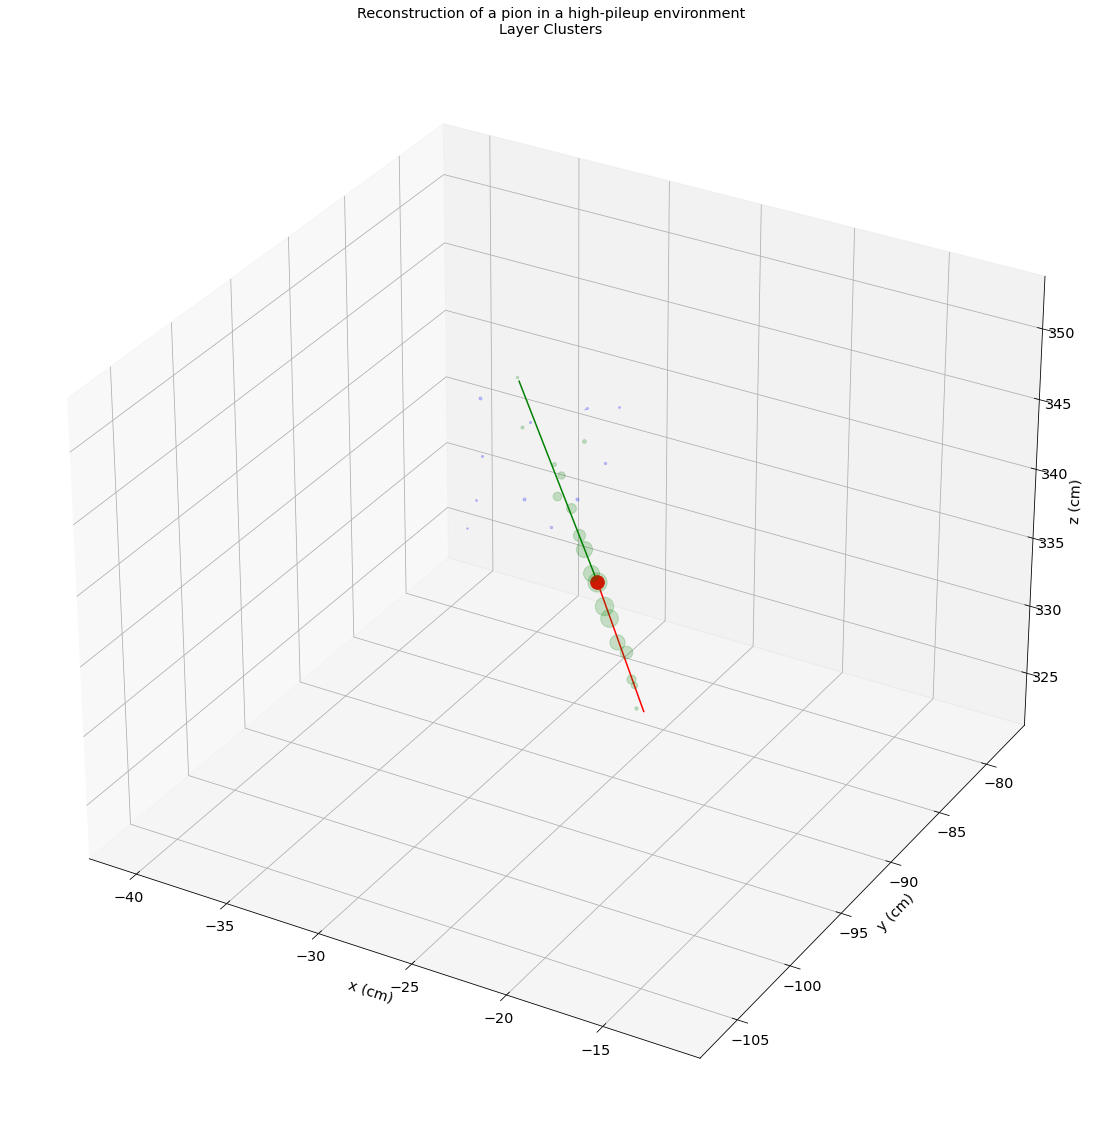

{((-25.41034524851753, -86.23477508794987, 323.16788499177903), (-26.35934829711914, -89.13424682617188, 334.38299560546875)), ((-27.442846612964253, -94.47306548328515, 351.59987584284136), (-26.35934829711914, -89.13424682617188, 334.38299560546875))}
0 0.028752672876733297 0.40515764945707333
1 0.04484449479111237 0.1408300204405994
2 0.11947007856620899 0.14968184305201443
3 0.27475354265873314 0.2914502796065355
4 0.5899440613272807 0.02105224146406604
5 0.6704118040814958 0.1284639214261003
6 0.9467121441824271 0.03571922881436101
7 0.942228779904711 0.11037577457209456
8 1.0 0.0
9 0.7757238589809053 0.043322252973926195
10 0.7407327754225328 0.09224248545379768
11 0.4804939694429426 0.37653261417202266
12 0.2712164581841264 0.25098027479672746
13 0.003279851345396714 5.126336807308323
14 0.18313232135371146 0.10038630229109125
15 0.17154327972926023 0.2221053361410143
16 0.0746821368022669 0.3592781255165032
17 0.009060589704565879 3.675386129615521
18 0.04463150672129071 0.3498

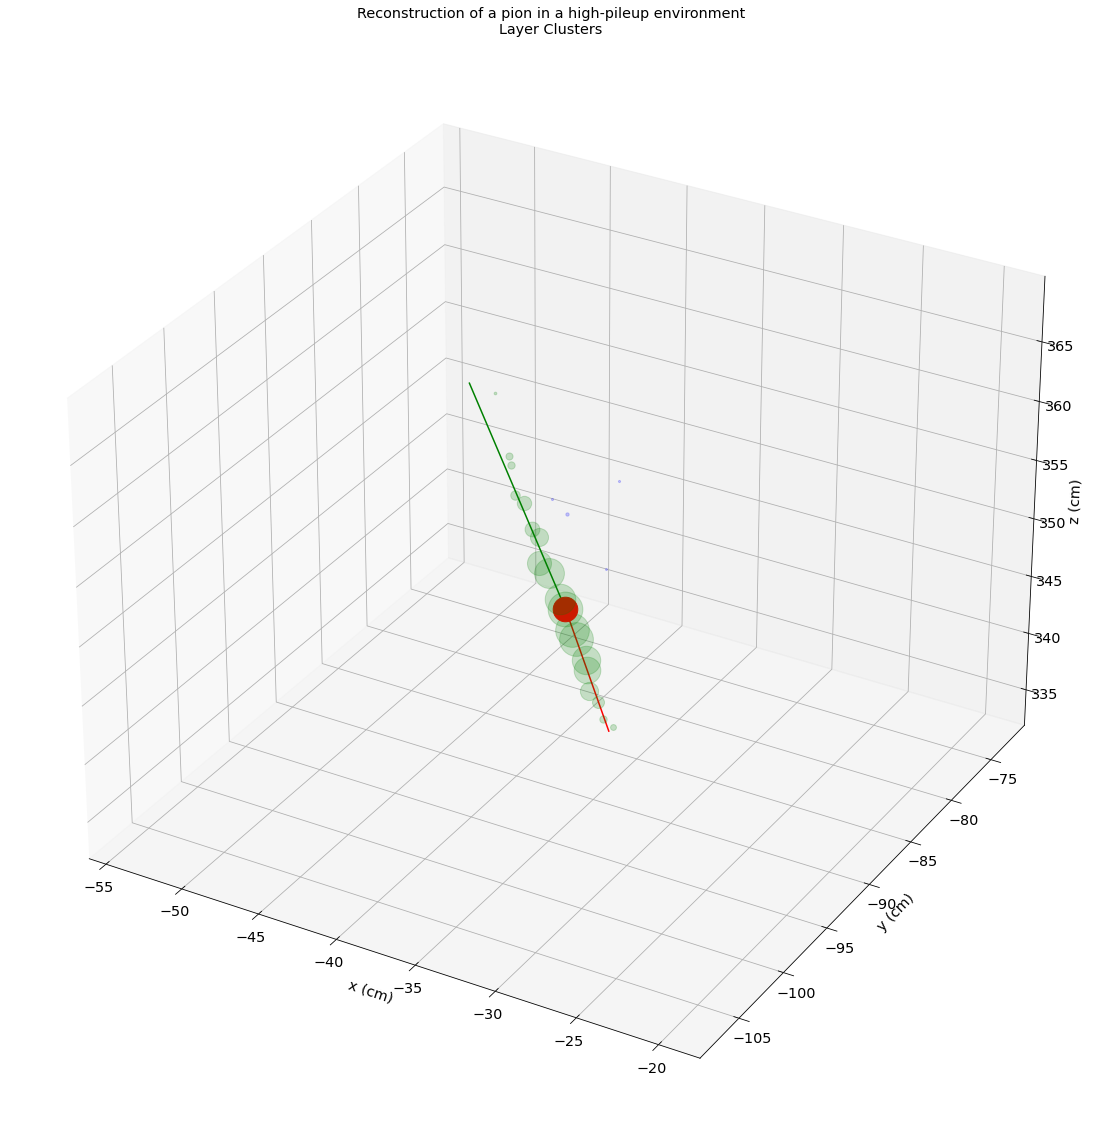

{((-40.41824466313698, -94.07566394278653, 367.8414089822251), (-37.523109436035156, -88.75871276855469, 346.6109924316406)), ((-36.39212040344291, -85.7835834457395, 334.2847631861671), (-37.523109436035156, -88.75871276855469, 346.6109924316406))}
0 0.07754104162487016 2.1887021486526663
1 0.11456513448395249 2.459789556531511
2 0.1348236088668464 1.4840647598726153
3 0.1201536864587928 2.0026476846031045
4 1.0 0.0
5 0.15158922734303482 3.122208651620437
6 0.17729690845540408 0.32668353594659744
7 0.07953505922878205 2.316073846663063
8 0.28251516382846587 3.0547483922514145
9 0.08202053626611364 3.8708307236036164
10 0.06545072887936514 0.7170073150618176
11 0.32725366312099197 0.35093155452787606
12 0.2742302694971748 5.038123522842873
13 0.3239396854160315 2.77164388356486
14 0.17398294323322114 3.328907767055763
15 0.0927909013933476 1.3090718702971729
16 0.08778620637106983 3.258825791337731


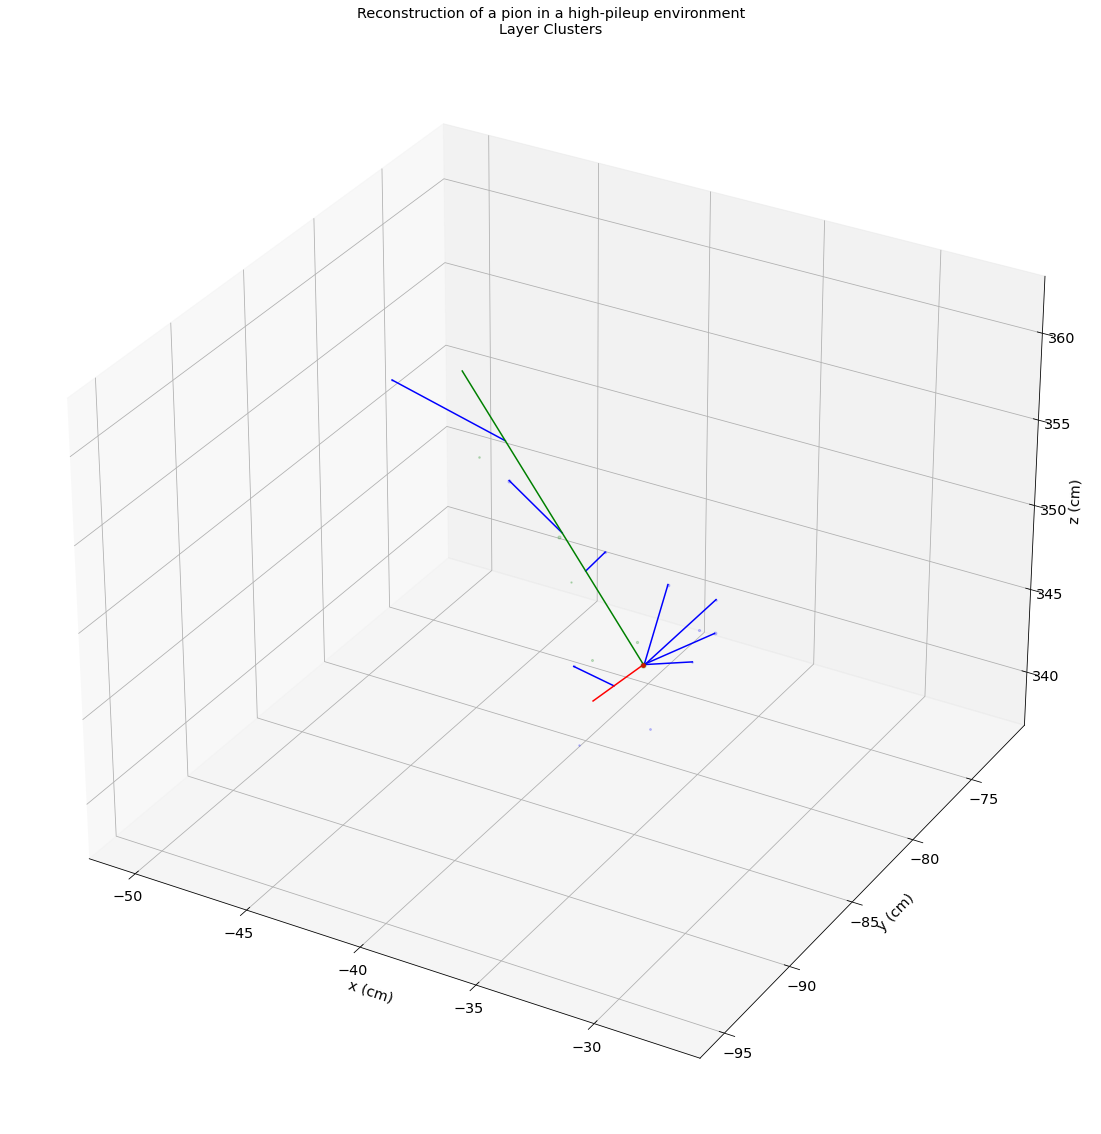

{((-41.977945687856135, -85.82613319300526, 361.5490745910894), (-34.882408142089844, -84.58861541748047, 346.6109924316406)), ((-34.882408142089844, -84.58861541748047, 346.6109924316406), (-32.790489196777344, -84.58799743652344, 347.6050109863281)), ((-34.882408142089844, -84.58861541748047, 346.6109924316406), (-33.07466506958008, -82.33525848388672, 347.6050109863281)), ((-37.16856974856565, -84.98734005356167, 351.42399915411085), (-35.340850830078125, -86.74073028564453, 354.3689880371094)), ((-39.430717954285456, -80.43577554721327, 339.7178395155743), (-34.882408142089844, -84.58861541748047, 346.6109924316406)), ((-34.862626319179675, -84.58516531136438, 346.5693461865197), (-32.790489196777344, -86.53933715820312, 353.375)), ((-37.502891292108586, -82.19598005311246, 342.63954109852784), (-38.377838134765625, -83.77892303466797, 344.5480041503906)), ((-38.09302319444897, -85.14857203416169, 353.3702310552344), (-41.16252899169922, -83.83157348632812, 354.3689880371094)), ((-

In [102]:
%matplotlib inline
eid = 2
# create internal edges per each trackster
all_event_edges, all_event_nodes = [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes = create_tr_skeletons(vx, vy, vz, ve, vi, ev=eid,
                                                                tr_id=tr_id, DST_THR=2, bubble_size=50, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05)
    print(internal_trackster_edges)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)

Number of internal edges in event: 14


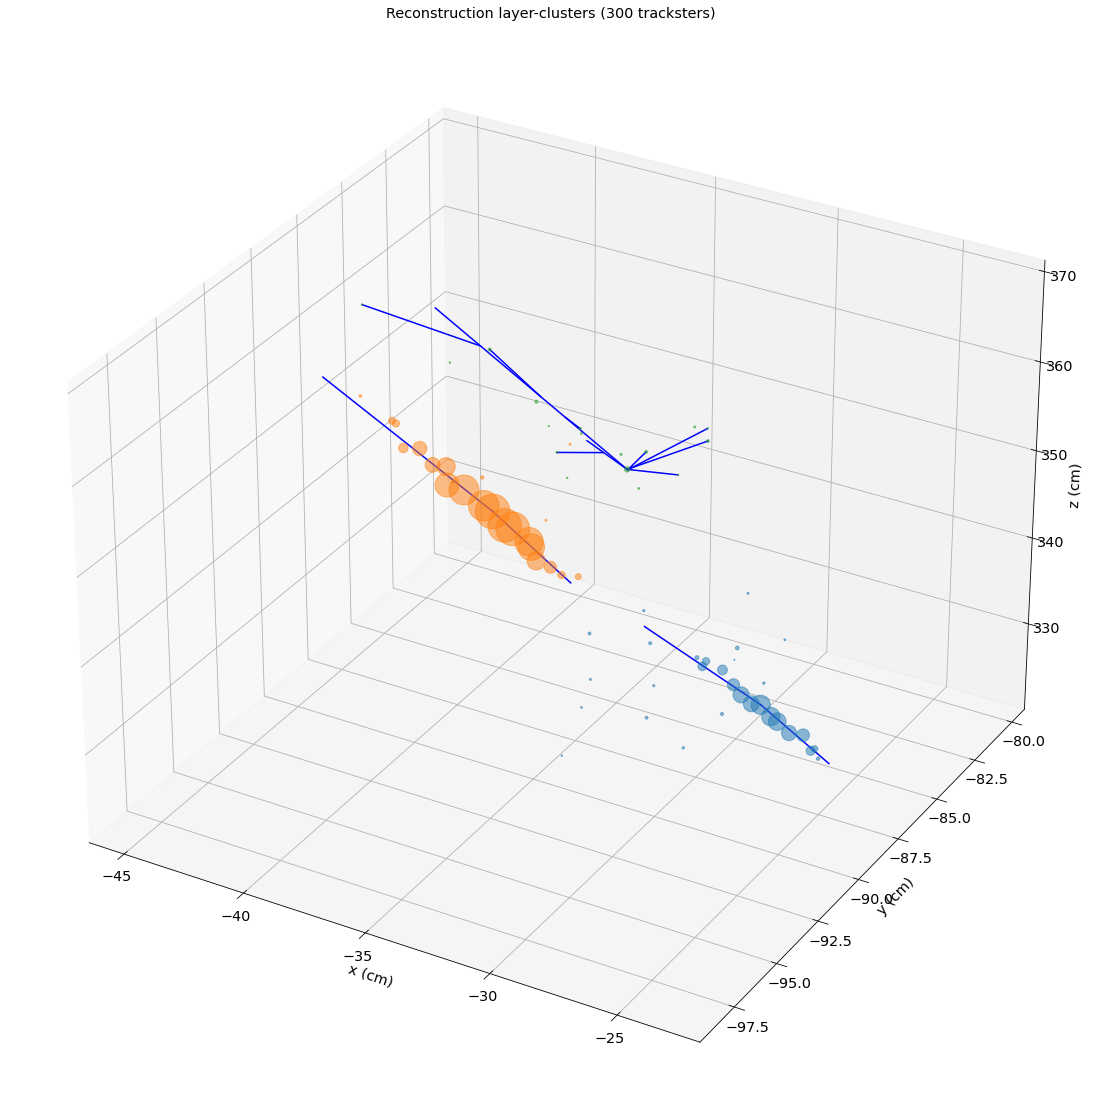

In [103]:
# Plot all of them in one figure
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid], vy[eid], vz[eid], ve[eid]):
    ax1.scatter(x, y, z, s=50*e, alpha=0.5)
    
num_edges = 0
for trackster_edges in all_event_edges:
    for edge in trackster_edges:
        ax1.plot([edge[0][0], edge[1][0]],
                [edge[0][1], edge[1][1]],
                [edge[0][2], edge[1][2]], c='blue')
        num_edges += 1
print(f"Number of internal edges in event: {num_edges}")

ax1.set_title(f"Reconstruction layer-clusters ({len(vx)} tracksters)")
plt.show()

In [104]:
def find_dist_to_closest_edge_set(point, edges):
    """
    point: np.array (x,y,z)
    edges: set
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    point = np.array(point)
    
    for (segment_start, segment_end) in edges:
        
        segment_start, segment_end = np.array(segment_start), np.array(segment_end)
        dist, closest_point_tmp, closest_endpoint_tmp = distance_point_to_segment_set(point, segment_start, segment_end)
        
        if dist < min_dist:
            min_dist = dist
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            
    return min_dist, min_edge, closest_point, closest_endpoint

def distance_point_to_segment_set(point, segment_start, segment_end):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        
        return np.linalg.norm(point_vector), segment_start, segment_start
    elif projection > 1:
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint

def create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev, tr_id, DST_THR=2, bubble_size=10, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05):
    # Project the poits on pca
    edges = set()
    nodes = set()

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    vxt = vx[ev][tr_id]
    vyt = vy[ev][tr_id]
    vzt = vz[ev][tr_id]
    vet = ve[ev][tr_id]
    vit = vi[ev][tr_id]
    
    bxt = bx[ev][tr_id]
    byt = by[ev][tr_id]
    bzt = bz[ev][tr_id]
    bet = be[ev][tr_id]

    dist_matrix = distance_matrix(vxt, vyt, vzt)
    pca = WPCA(n_components=3)    
    positions = np.array((vxt, vyt, vzt)).T

    vet_array = np.array(vet).reshape(-1,1)
    vet_array = np.tile(vet_array,(1, 3))

    pca.fit(positions, weights = vet_array)

    component = pca.components_[0]

    b_coord = np.array([bxt, byt, bzt])
    nodes.add(tuple(b_coord))

    ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
    ax.scatter(bxt, byt, bzt, s=bet*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

    segment_end = np.array([bxt+component[0],
                            byt+component[1],
                            bzt+component[2]])

    data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

    # project each LC to the principal component
    min_p, max_p = (0,0,99999), (0,0,-99999)

    for x,y,z,e,i,j in data:

        point = np.array([x, y, z])
        # if energy density is low: don't do anything for now 
        # else - create main edges
        dist, closest_point = project_lc_to_pca(point, b_coord, segment_end)

        z_cl = closest_point[2]
        if min_p[2] > z_cl:
            min_p = closest_point
        if max_p[2] < z_cl:
            max_p = closest_point

        #ax.text(x, y, z, str(j))

        print(j, e/bet, dist)
        if e / bet > ENERGY_RATIO_THR and dist > DST_THR:
            # and not covered by any other edges
            min_dist, min_edge, closest_point_edge, closest_endpoint =  find_dist_to_closest_edge_set(point, edges)
            if min_dist < DST_THR:
                continue

            #print(f"big: {dist}")

            # find neares higher
            # go through all points, if the point is within the Neighbour_threshold = 10
            distances = dist_matrix[j]
            indices = np.argsort(distances)
            for idx in indices:

                if distances[idx] < NEIGHBOUR_THR and vet[idx] > e and abs(vzt[idx]) < abs(z):
                    # found the nearest higher
                    # create an edge - to projection of the nearest higher to the pca
                    #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                    #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                    nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                    dist, closest_point = project_lc_to_pca(nearest_higher, b_coord, segment_end)
                        
                    if not np.allclose(closest_point, point, atol=0.1):
                        edges.add((tuple(closest_point), tuple(point)))
                        nodes.add(tuple(closest_point))
                        nodes.add(tuple(point))
                    ax.plot([closest_point[0], x], [closest_point[1], y], [closest_point[2], z], c='blue')

                    break

    ax.plot([bxt, min_p[0]], [byt, min_p[1]], [bzt, min_p[2]], c='red')
    ax.plot([bxt, max_p[0]], [byt, max_p[1]], [bzt, max_p[2]], c='green')
    if not np.allclose(min_p, b_coord, atol=0.1):
        edges.add((tuple(min_p), tuple(b_coord)))
        nodes.add(tuple(min_p))
    if not np.allclose(max_p, b_coord, atol=0.1):
        edges.add((tuple(max_p), tuple(b_coord)))
        nodes.add(tuple(max_p))

    set_axes_equal(ax)
    plt.show()
    return edges, nodes


0 0.004580943681556007 0.3834181529363743
1 0.015923479172445684 0.15978353993201916
2 0.03263108399772108 0.2426397081484999
3 0.06305272597502987 0.21431521667400993
4 0.09130985654784608 0.06805068598911079
5 0.1224421308612689 0.055664222478714956
6 0.1333341435167195 0.07208674586271809
7 0.1449122494795895 0.16311756508051833
8 0.10028237911291682 0.06902955927985618
9 0.10229695210131057 0.13744652071809277
10 0.05807842572687088 0.16926975009960601
11 0.03814039018382059 0.42856363267418335
12 0.029592595049643754 0.5679460498481939
13 0.02117549102717852 0.1772843113909131
14 0.0012734031878617615 4.175441120920549
15 0.0008379103031619047 6.136428795858851
16 0.0023814293364433662 4.679562366582644
17 0.0063417170717807786 0.09902590364118831
18 0.0034784300863549625 3.434641517942053
19 0.0038202095635852845 3.453981304830279
20 0.0015845884243955795 3.4392969691607598
21 0.0017474839462255443 3.113229539247011
22 0.005547682863683538 1.8410299695460144
23 0.0022171922013677

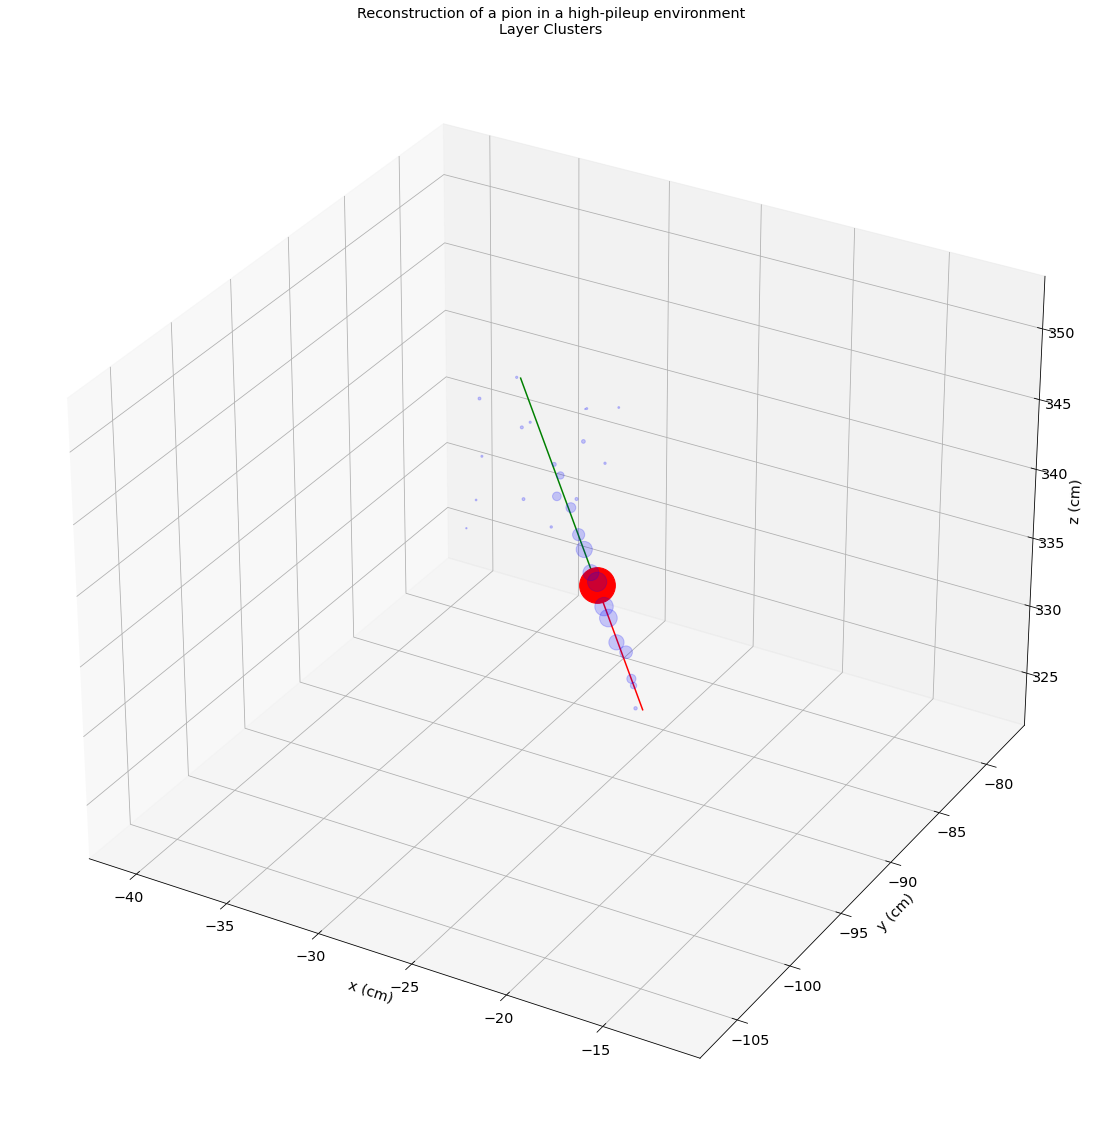

{((-25.525775601533805, -86.12461711315092, 323.1817731428243), (-26.30521583557129, -89.24987030029297, 334.2161560058594)), ((-27.533115593609708, -94.17327233257242, 351.5992925902257), (-26.30521583557129, -89.24987030029297, 334.2161560058594))}
0 0.0038715508968354922 0.4446039159981696
1 0.0060383166730616335 0.3742145573680641
2 0.016086660596771742 0.17207778102833227
3 0.03699559790665279 0.40778427916972515
4 0.07943603954687013 0.11164343228584304
5 0.09027103088704928 0.08030388681311704
6 0.12747490525725863 0.0608331410755309
7 0.12687121971245222 0.0946035410585115
8 0.13465012151855824 0.09681841769125306
9 0.10445131187662385 0.057279765304423635
10 0.09973975822342296 0.06128944247151392
11 0.06469857137442664 0.3458468871056384
12 0.03651932905232559 0.263253975403311
13 0.0004416323822204743 5.115803935398801
14 0.024658789324252906 0.0720723438111874
15 0.02309832346123692 0.16807333610422243
16 0.01005595879569083 0.3284290970813333
17 0.0012200095047495934 3.602

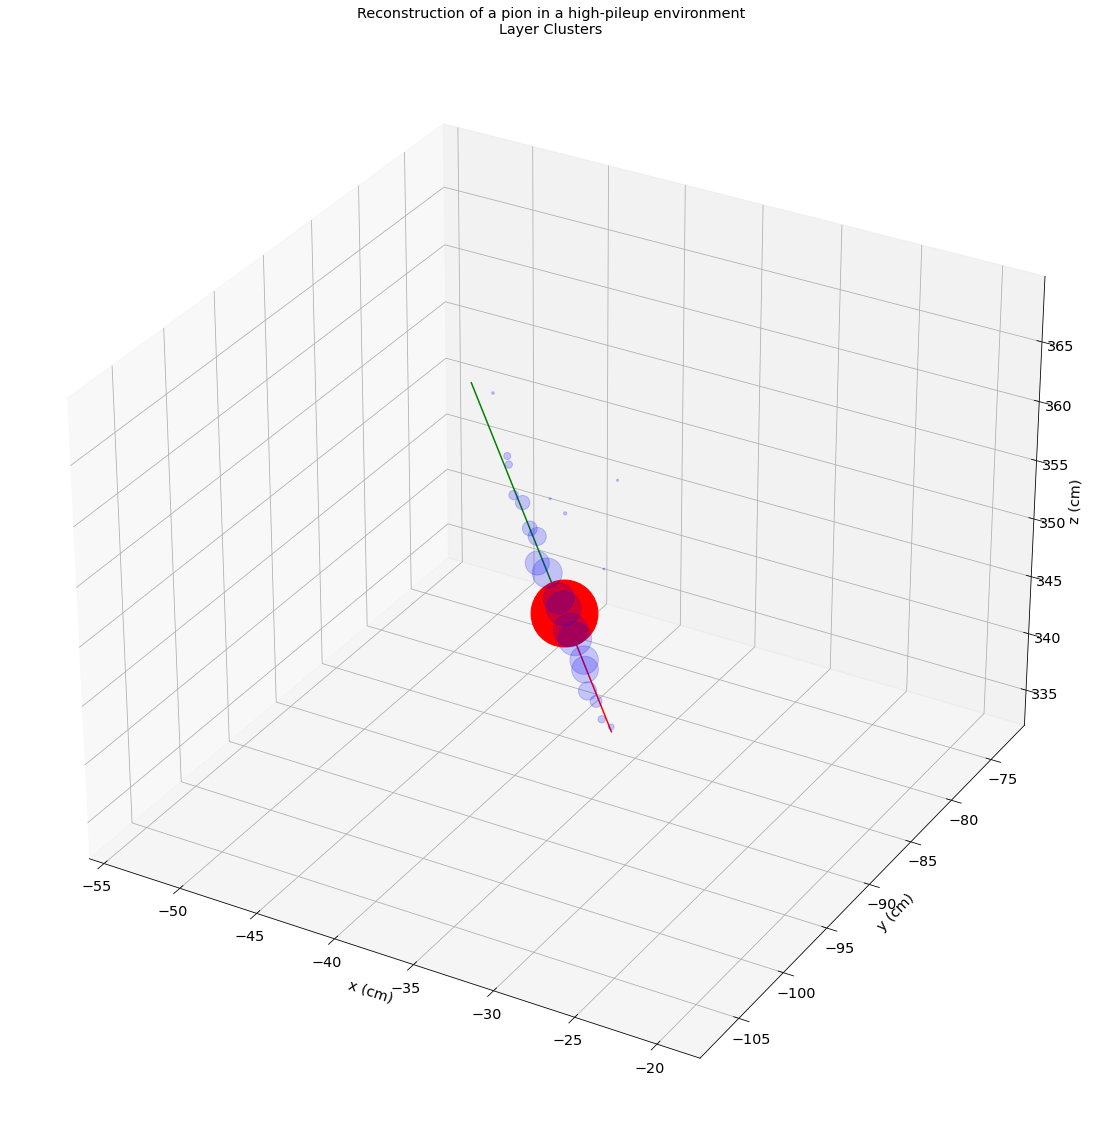

{((-36.121630132205524, -85.76908472097924, 334.31783270728727), (-37.55864715576172, -88.69091796875, 346.1654968261719)), ((-40.19496892863045, -94.05125294148915, 367.9009768951244), (-37.55864715576172, -88.69091796875, 346.1654968261719))}
0 0.021747746887318318 7.491056674969354
1 0.03213180394096562 2.818844243102004
2 0.03781364885780113 5.153685141296929
3 0.03369921148758372 4.049758243974315
4 0.2804675618433148 0.470660066079885
5 0.04251586099461292 2.8405968222179583
6 0.04972603163684456 0.15169627556110754
7 0.02230700414296013 2.3718065031020075
8 0.07923633918273446 2.7313570322727787
9 0.02300409982763807 3.6922299380546737
10 0.01835680634966337 1.0318885738612682
11 0.09178403699983811 0.7582068640946449
12 0.07691269506950774 5.246194171591294
13 0.09085457375292474 2.4852163420989704
14 0.04879657189094537 3.614234506046223
15 0.02602483787503564 1.5957999700159835
16 0.024621183264368022 3.1013985180378243


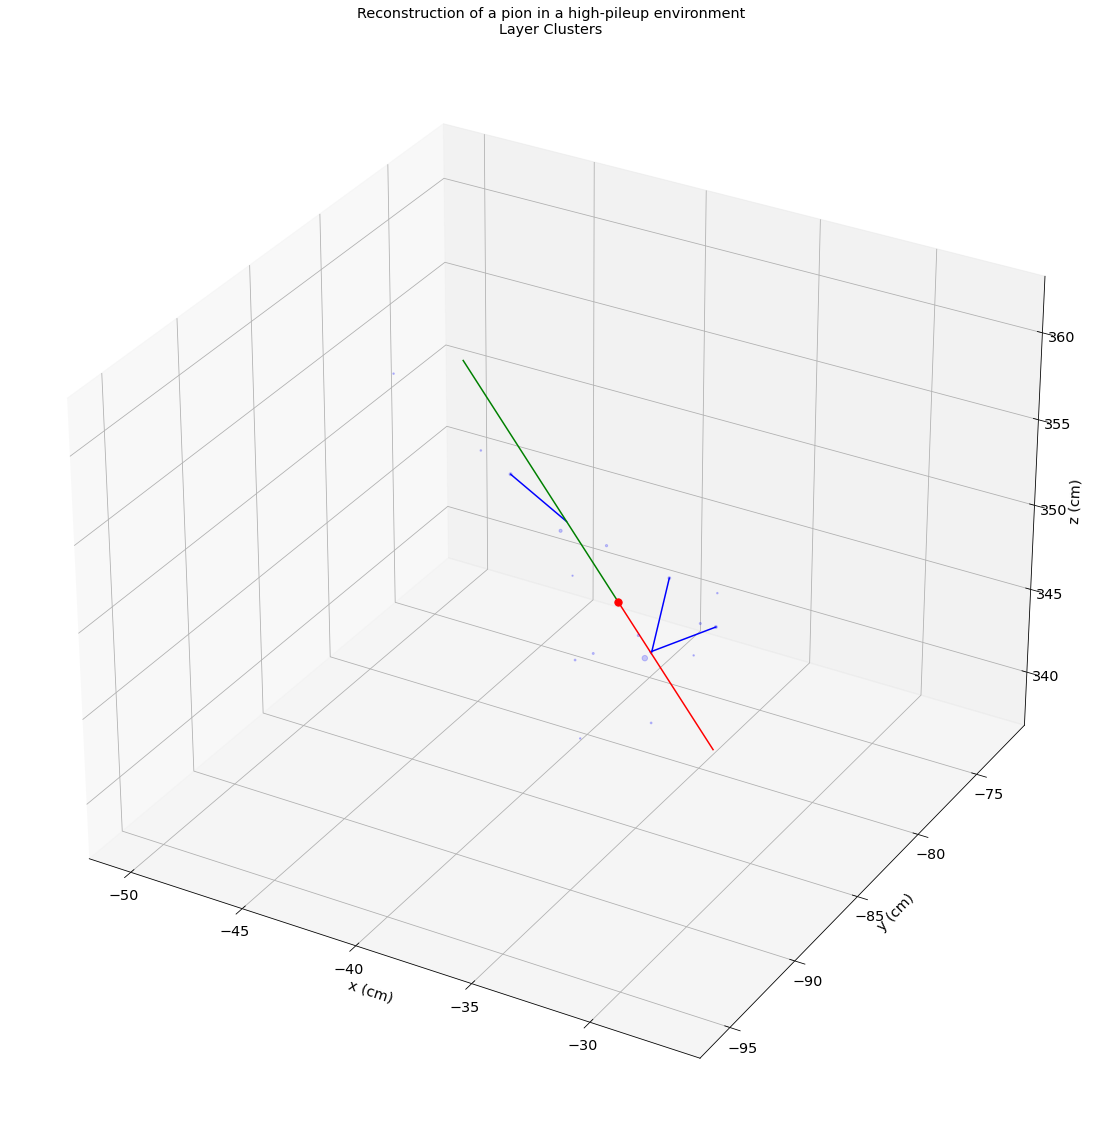

{((-42.181687300056595, -85.52314663496054, 361.52139812501605), (-36.176883697509766, -84.36463165283203, 349.239501953125)), ((-34.86730841139461, -84.1119734995252, 346.560968439303), (-32.790489196777344, -86.53933715820312, 353.375)), ((-32.41652578314071, -83.63914065090911, 341.5482719762043), (-36.176883697509766, -84.36463165283203, 349.239501953125)), ((-38.192383183491614, -84.7534847287248, 353.3618941344163), (-41.16252899169922, -83.83157348632812, 354.3689880371094)), ((-34.90741354413863, -84.11971103770622, 346.6429972796989), (-33.07466506958008, -82.33525848388672, 347.6050109863281))}


In [105]:
%matplotlib inline
eid = 2
# create internal edges per each trackster
all_event_edges, all_event_nodes = [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes = create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev=eid,
                                                                tr_id=tr_id, DST_THR=2, bubble_size=50, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05)
    print(internal_trackster_edges)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)

Number of internal edges in event: 9


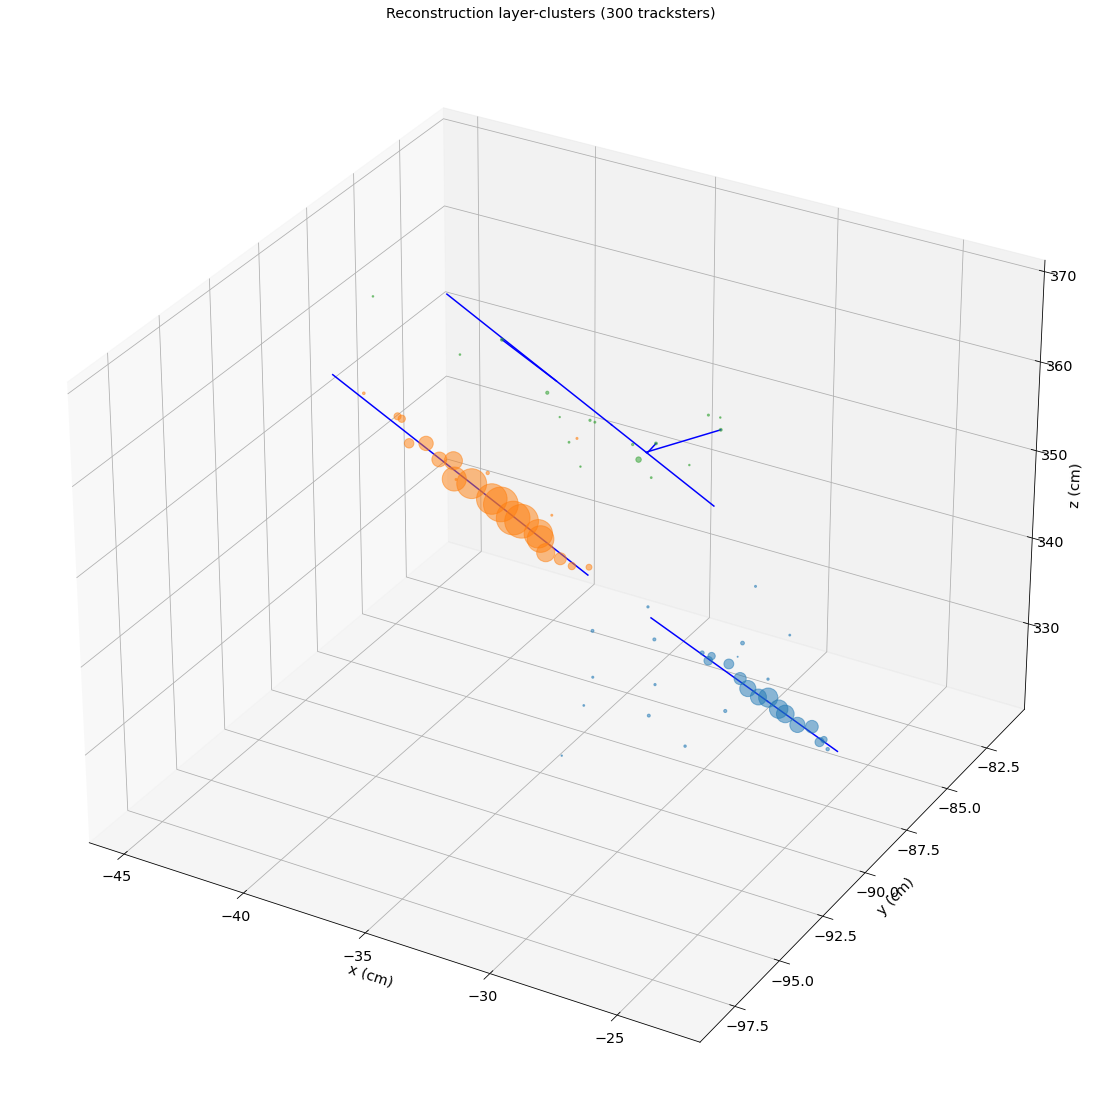

In [106]:
# Plot all of them in one figure
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid], vy[eid], vz[eid], ve[eid]):
    ax1.scatter(x, y, z, s=50*e, alpha=0.5)
    
num_edges = 0
for trackster_edges in all_event_edges:
    for edge in trackster_edges:
        ax1.plot([edge[0][0], edge[1][0]],
                [edge[0][1], edge[1][1]],
                [edge[0][2], edge[1][2]], c='blue')
        num_edges += 1
print(f"Number of internal edges in event: {num_edges}")

ax1.set_title(f"Reconstruction layer-clusters ({len(vx)} tracksters)")
plt.show()

In [107]:
def find_dist_to_closest_edge_set(point, edges):
    """
    point: np.array (x,y,z)
    edges: set
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    point = np.array(point)
    
    for (segment_start, segment_end) in edges:
        
        segment_start, segment_end = np.array(segment_start), np.array(segment_end)
        dist, closest_point_tmp, closest_endpoint_tmp = distance_point_to_segment_set(point, segment_start, segment_end)
        
        if dist < min_dist:
            min_dist = dist
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            
    return min_dist, min_edge, closest_point, closest_endpoint

def distance_point_to_segment_set(point, segment_start, segment_end):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        
        return np.linalg.norm(point_vector), segment_start, segment_start
    elif projection > 1:
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint

def create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev, tr_id, DST_THR=2, bubble_size=10, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05):
    # Project the poits on pca
    edges = set()
    nodes = set()
    covered_nodes = set()
    covered_node_idx = []
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    vxt = vx[ev][tr_id]
    vyt = vy[ev][tr_id]
    vzt = vz[ev][tr_id]
    vet = ve[ev][tr_id]
    vit = vi[ev][tr_id]
    
    bxt = bx[ev][tr_id]
    byt = by[ev][tr_id]
    bzt = bz[ev][tr_id]
    bet = be[ev][tr_id]

    dist_matrix = distance_matrix(vxt, vyt, vzt)
    pca = WPCA(n_components=3)    
    positions = np.array((vxt, vyt, vzt)).T

    vet_array = np.array(vet).reshape(-1,1)
    vet_array = np.tile(vet_array,(1, 3))

    pca.fit(positions, weights = vet_array)

    component = pca.components_[0]

    b_coord = np.array([bxt, byt, bzt])
    nodes.add(tuple(b_coord))

    #ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
    ax.scatter(bxt, byt, bzt, s=10, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

    segment_end = np.array([bxt+component[0],
                            byt+component[1],
                            bzt+component[2]])

    data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

    # project each LC to the principal component
    min_p, max_p = (0,0,99999), (0,0,-99999)
    max_en = max(vet)

    for x,y,z,e,i,j in data:

        point = np.array([x, y, z])
        # if energy density is low: don't do anything for now 
        # else - create main edges
        dist, closest_point = project_lc_to_pca(point, b_coord, segment_end)
        
        if e/max_en > ENERGY_RATIO_THR and dist < 1:

            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point
            covered_nodes.add((x, y, z))
            covered_node_idx.append(j)
            ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="green", zorder=-5)
    
        else:
            ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="blue", zorder=-5)


    ax.plot([bxt, min_p[0]], [byt, min_p[1]], [bzt, min_p[2]], c='red')
    #data_linewidth_plot([max_p[0], min_p[0]], [max_p[1], min_p[1]], [max_p[2], min_p[2]], ax=ax, 
                        #linewidth=0.01, alpha=0.3, c='green')
    
    ax.plot([bxt, max_p[0]], [byt, max_p[1]], [bzt, max_p[2]], c='green')
    if not np.allclose(min_p, b_coord, atol=0.1):
        edges.add((tuple(min_p), tuple(b_coord)))
        nodes.add(tuple(min_p))
    if not np.allclose(max_p, b_coord, atol=0.1):
        edges.add((tuple(max_p), tuple(b_coord)))
        nodes.add(tuple(max_p))
        
        
    # Build secondary edges
    for x,y,z,e,i,j in data:
        
        print(j, e/max_en, dist)
        if e / max_en > ENERGY_RATIO_THR and dist > DST_THR:
            # and not covered by any other edges
            min_dist, min_edge, closest_point_edge, closest_endpoint =  find_dist_to_closest_edge_set(point, edges)
            if min_dist < DST_THR:
                continue

            # find neares higher
            # go through all points, if the point is within the Neighbour_threshold
            distances = dist_matrix[j]
            indices = np.argsort(distances)
            for idx in indices:
            
                if idx in covered_node_idx and distances[idx] < NEIGHBOUR_THR and vet[idx] > e and abs(vzt[idx]) < abs(z):
                    # found the nearest higher
                    # create an edge - to projection of the nearest higher to the pca
                    #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                    #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                    nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                    #dist, closest_point = project_lc_to_pca(nearest_higher, b_coord, segment_end)
                        
                    if not np.allclose(nearest_higher, point, atol=0.1):
                        edges.add((tuple(nearest_higher), tuple(point)))
                        nodes.add(tuple(nearest_higher))
                        nodes.add(tuple(point))
                    ax.plot([nearest_higher[0], x], [nearest_higher[1], y], [nearest_higher[2], z], c='blue')

                    break
    

    set_axes_equal(ax)
    plt.show()
    return edges, nodes


0 0.031611845775682476 3.5873131818927866
1 0.10988359665680618 3.5873131818927866
2 0.22517823106677448 3.5873131818927866
3 0.43510970398614 3.5873131818927866
4 0.6301044727119968 3.5873131818927866
5 0.8449398260049407 3.5873131818927866
6 0.9201026413954001 3.5873131818927866
7 1.0 3.5873131818927866
8 0.6920214093222072 3.5873131818927866
9 0.7059234293076018 3.5873131818927866
10 0.40078341158489206 3.5873131818927866
11 0.2631964538594272 3.5873131818927866
12 0.2042104456725847 3.5873131818927866
13 0.14612630128387477 3.5873131818927866
14 0.008787408879751858 3.5873131818927866
15 0.005782190989174605 3.5873131818927866
16 0.016433595813987997 3.5873131818927866
17 0.04376246379830017 3.5873131818927866
18 0.024003699472244337 3.5873131818927866
19 0.026362226639255578 3.5873131818927866
20 0.010934813517050293 3.5873131818927866
21 0.012058911185915119 3.5873131818927866
22 0.03828304980156225 3.5873131818927866
23 0.01530024003719616 3.5873131818927866
24 0.025357474159968

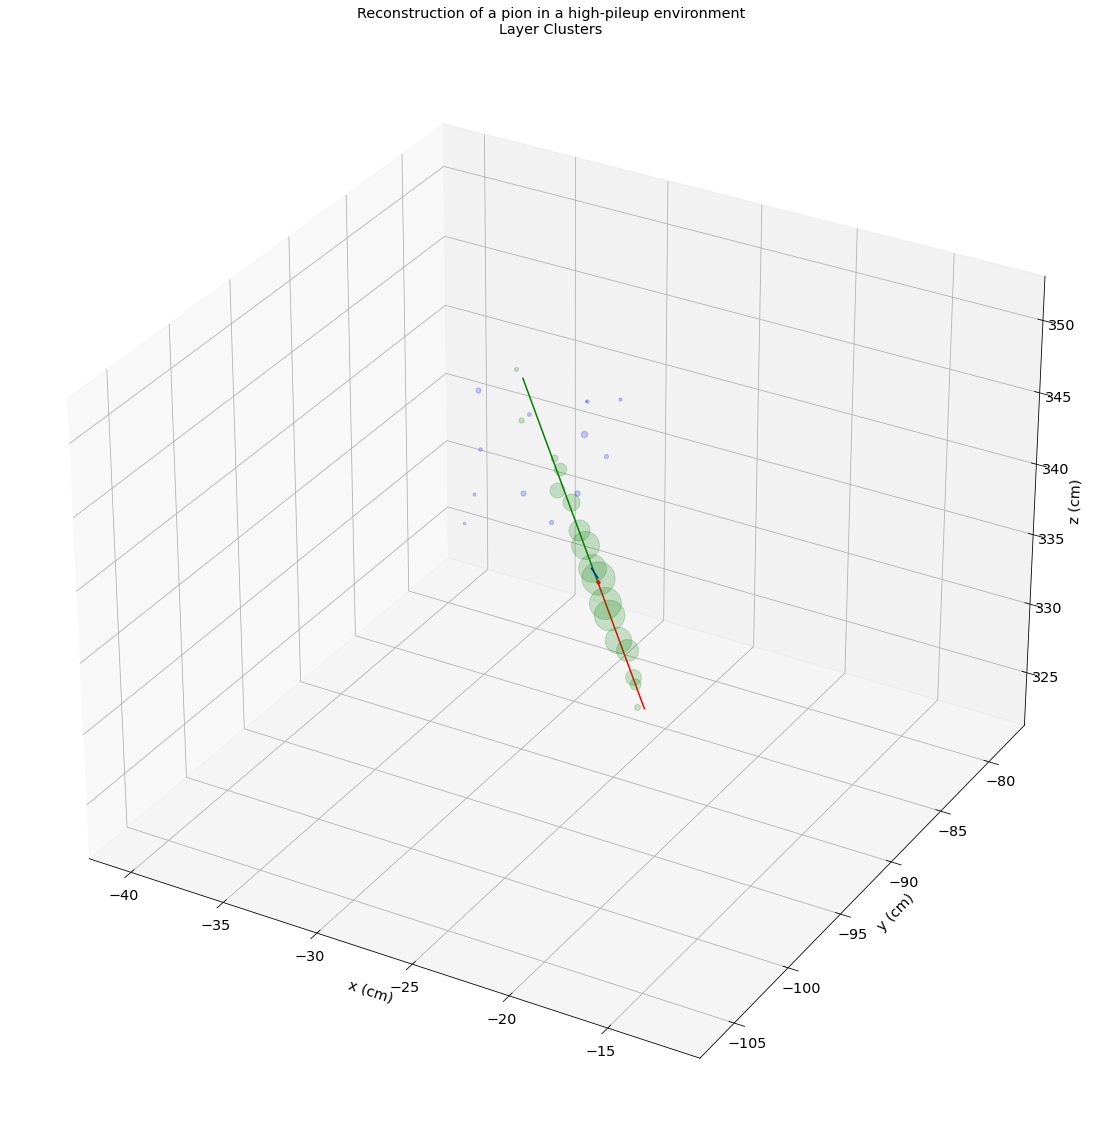

{((-25.525775601533805, -86.12461711315092, 323.1817731428243), (-26.30521583557129, -89.24987030029297, 334.2161560058594)), ((-26.35934829711914, -89.13424682617188, 334.38299560546875), (-23.940780639648438, -94.53096771240234, 350.98699951171875)), ((-27.482929729704704, -93.97204647294988, 350.8888211358956), (-26.30521583557129, -89.24987030029297, 334.2161560058594))}
0 0.028752672876733297 1.7337232313723914
1 0.04484449479111237 1.7337232313723914
2 0.11947007856620899 1.7337232313723914
3 0.27475354265873314 1.7337232313723914
4 0.5899440613272807 1.7337232313723914
5 0.6704118040814958 1.7337232313723914
6 0.9467121441824271 1.7337232313723914
7 0.942228779904711 1.7337232313723914
8 1.0 1.7337232313723914
9 0.7757238589809053 1.7337232313723914
10 0.7407327754225328 1.7337232313723914
11 0.4804939694429426 1.7337232313723914
12 0.2712164581841264 1.7337232313723914
13 0.003279851345396714 1.7337232313723914
14 0.18313232135371146 1.7337232313723914
15 0.17154327972926023 1.

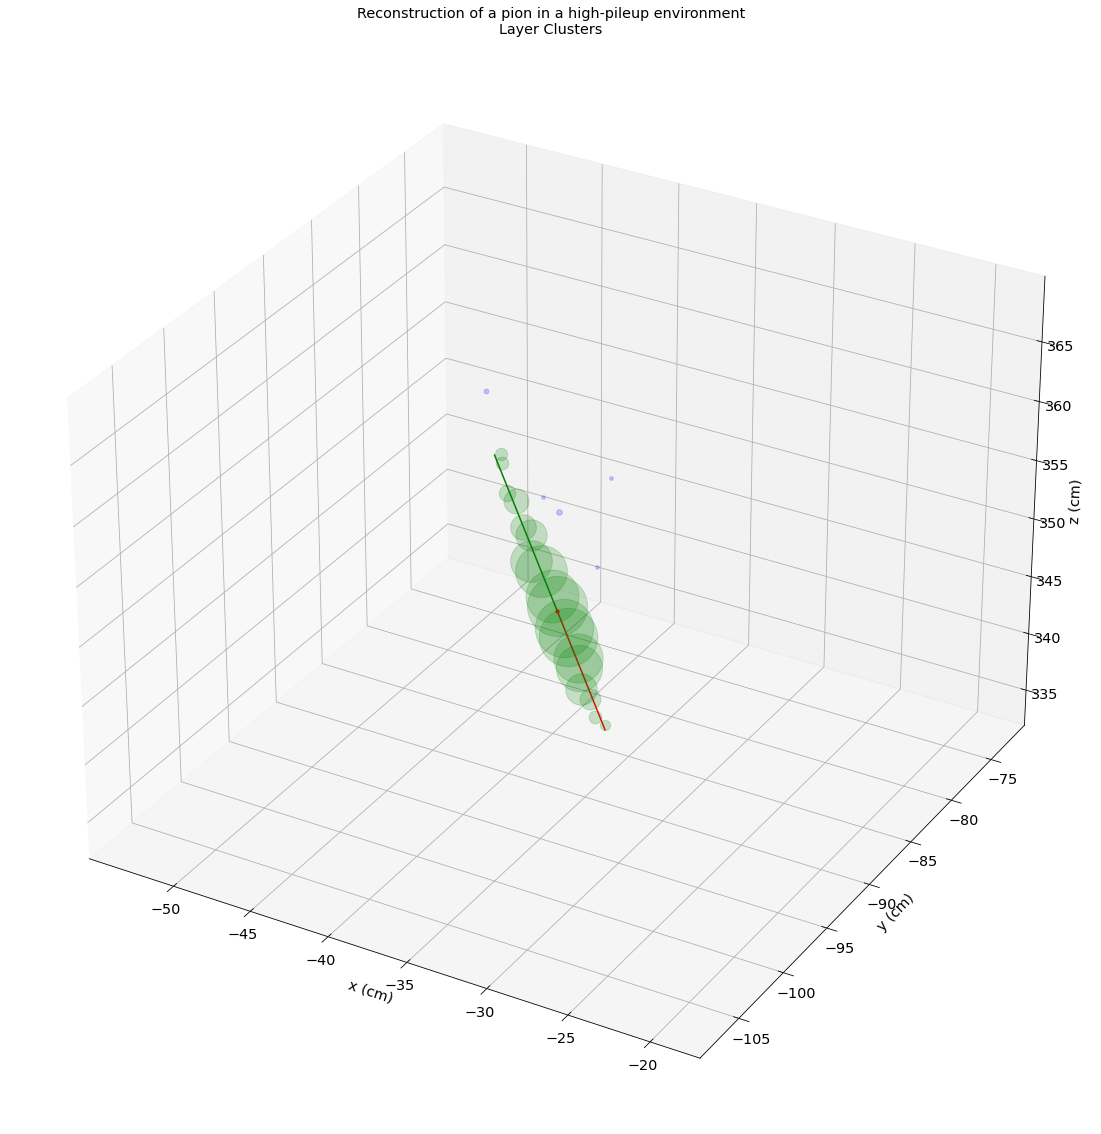

{((-36.121630132205524, -85.76908472097924, 334.31783270728727), (-37.55864715576172, -88.69091796875, 346.1654968261719)), ((-39.36487579936386, -92.36345546652602, 361.0571716918941), (-37.55864715576172, -88.69091796875, 346.1654968261719))}
0 0.07754104162487016 3.1013985180378243
1 0.11456513448395249 3.1013985180378243
2 0.1348236088668464 3.1013985180378243
3 0.1201536864587928 3.1013985180378243
4 1.0 3.1013985180378243
5 0.15158922734303482 3.1013985180378243
6 0.17729690845540408 3.1013985180378243
7 0.07953505922878205 3.1013985180378243
8 0.28251516382846587 3.1013985180378243
9 0.08202053626611364 3.1013985180378243
10 0.06545072887936514 3.1013985180378243
11 0.32725366312099197 3.1013985180378243
12 0.2742302694971748 3.1013985180378243
13 0.3239396854160315 3.1013985180378243
14 0.17398294323322114 3.1013985180378243
15 0.0927909013933476 3.1013985180378243
16 0.08778620637106983 3.1013985180378243


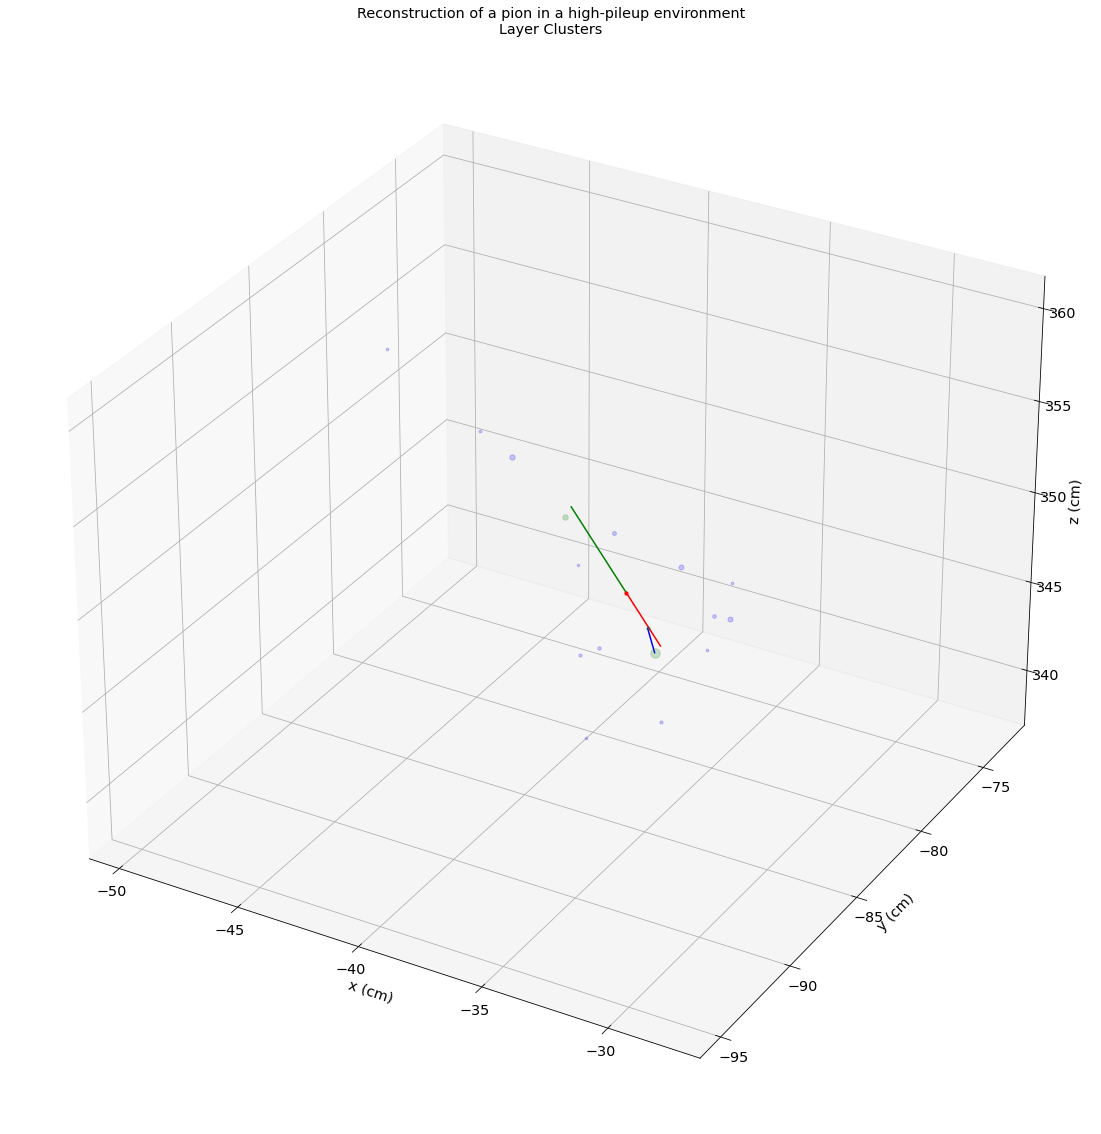

{((-34.90741354413863, -84.11971103770622, 346.6429972796989), (-36.176883697509766, -84.36463165283203, 349.239501953125)), ((-38.192383183491614, -84.7534847287248, 353.3618941344163), (-36.176883697509766, -84.36463165283203, 349.239501953125)), ((-34.882408142089844, -84.58861541748047, 346.6109924316406), (-44.907283782958984, -86.05115509033203, 360.1390075683594))}


In [108]:
%matplotlib inline
eid = 2
# create internal edges per each trackster
all_event_edges, all_event_nodes = [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes = create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev=eid,
                                                                tr_id=tr_id, DST_THR=2, bubble_size=150, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.01)
    print(internal_trackster_edges)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)

# PLS work...

In [109]:
def find_dist_to_closest_edge_set(point, edges):
    """
    point: np.array (x,y,z)
    edges: set
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    point = np.array(point)
    
    for (segment_start, segment_end) in edges:
        
        segment_start, segment_end = np.array(segment_start), np.array(segment_end)
        dist, closest_point_tmp, closest_endpoint_tmp = distance_point_to_segment_set(point, segment_start, segment_end)
        
        if dist < min_dist:
            min_dist = dist
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            
    return min_dist, min_edge, closest_point, closest_endpoint

def distance_point_to_segment_set(point, segment_start, segment_end):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        
        return np.linalg.norm(point_vector), segment_start, segment_start
    elif projection > 1:
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint

def create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev, tr_id, DST_THR=2, bubble_size=10, 
                                   NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.01, MIN_EDGE_LEN=1, PCA_NEIGHBOUR_THR=2):
    # Project the poits on pca
    edges, nodes = set(), set()
    covered_nodes = set()
    covered_node_idx = []
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    vxt = vx[ev][tr_id]
    vyt = vy[ev][tr_id]
    vzt = vz[ev][tr_id]
    vet = ve[ev][tr_id]
    vit = vi[ev][tr_id]
    
    bxt = bx[ev][tr_id]
    byt = by[ev][tr_id]
    bzt = bz[ev][tr_id]
    bet = be[ev][tr_id]

    # Get distances between the LCs
    dist_matrix = distance_matrix(vxt, vyt, vzt)
    # Calculate PCA
    pca = WPCA(n_components=3)    
    positions = np.array((vxt, vyt, vzt)).T

    vet_array = np.array(vet).reshape(-1,1)
    vet_array = np.tile(vet_array,(1, 3))

    pca.fit(positions, weights = vet_array)
    component = pca.components_[0]
    
    # Barycenter
    b_coord = np.array([bxt, byt, bzt])
    edges.add((tuple(b_coord), tuple(b_coord)))
    nodes.add(tuple(b_coord))
    ax.scatter(bxt, byt, bzt, s=10, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

    segment_end = np.array([bxt+component[0],
                            byt+component[1],
                            bzt+component[2]])

    data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]
    # sorted by energy
    data = sorted(data, key=lambda a: -a[3])

    # project each LC to the principal component
    min_p, max_p = b_coord, b_coord
    max_en = max(vet)
    num_lc_above_th = len(vxt[vet > 2*ENERGY_RATIO_THR*max_en])
    
    small_trackster = False
    if max_en < 1 or num_lc_above_th < 5:
        # If maximum energy of the LCs is lower than 2 GeV or number of layer clusters with at least a ENERGY_RATIO_THR of the maximum energy is less than 5
        small_trackster = True
        print("Small trackster")

    # try create main edges
    for x,y,z,e,i,j in data:

        point = np.array([x, y, z])
        dist, closest_point = project_lc_to_pca(point, b_coord, segment_end)
        
        if e/max_en > ENERGY_RATIO_THR and dist < PCA_NEIGHBOUR_THR:
            # limiting the PCA length
            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point          

    
    if np.linalg.norm(min_p-max_p) > 0.5:
    
        if not np.allclose(min_p, b_coord, atol=0.1):
            edges.add((tuple(min_p), tuple(b_coord)))
            nodes.add(tuple(min_p))
            ax.plot([bxt, min_p[0]], [byt, min_p[1]], [bzt, min_p[2]], c='red')    

        if not np.allclose(max_p, b_coord, atol=0.1):
            edges.add((tuple(max_p), tuple(b_coord)))
            nodes.add(tuple(max_p))
            ax.plot([bxt, max_p[0]], [byt, max_p[1]], [bzt, max_p[2]], c='green')
    else:
        min_p, max_p = b_coord, b_coord
        
        
    #Build secondary edges
    for x,y,z,e,i,j in data:
        
        if e / max_en > ENERGY_RATIO_THR:
            # and not covered by any edge
            point = np.array([x, y, z])
            min_dist, min_edge, closest_point_edge, closest_endpoint =  find_dist_to_closest_edge_set(point, edges)
            print(min_dist)
            
            if min_dist < DST_THR:
                # LC covered by some edge already
                ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="green", zorder=-5)
                covered_nodes.add((x, y, z))
                covered_node_idx.append(j)  
                continue
            else:
                ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="red", zorder=-5)

            if not small_trackster:
                # find neares higher
                # go through all points, if the point is within the Neighbour_threshold
                distances = dist_matrix[j]
                indices = np.argsort(distances)

                for idx in indices:

                    if idx in covered_node_idx and distances[idx] < NEIGHBOUR_THR and vet[idx] > e:# and abs(vzt[idx]) < abs(z):
                        # found the nearest higher
                        # create an edge - to projection of the nearest higher to the pca
                        #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                        #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                        nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                        
                        # TODO: check that it lies on the axis!!!!!!!!!!!!!!!
                        dist, closest_point = project_lc_to_pca(nearest_higher, b_coord, segment_end)

                        if not np.allclose(closest_point, point, atol=0.1):
                            edges.add((tuple(closest_point), tuple(point)))
                            nodes.add(tuple(closest_point))
                            nodes.add(tuple(point))
                        ax.plot([closest_point[0], x], [closest_point[1], y], [closest_point[2], z], c='blue')

                        break
        else:
            # if low energy
            ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="blue", zorder=-5)
    

    set_axes_equal(ax)
    plt.show()
    return edges, nodes

In [110]:
%matplotlib widget
eid = 5
# create internal edges per each trackster
all_event_edges, all_event_nodes = [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes = create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev=eid,
                                                                tr_id=tr_id, bubble_size=150)
    print(internal_trackster_edges)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.006694091647841689
0.22670024515019968
0.12884073583959088
0.16613904794643233
0.10696115890418151
0.10822441554270734
0.2863169270071071
0.07309391674098113
0.15678741425882614
0.2792687174305411
0.5938917520333551
0.17315582958235498
0.42427558895809725
0.32887237511457734
0.7627748289503216
0.20774270102441852
1.0420539127281003
1.595002777488151
0.13141984870019408
1.5908540939452722
2.698691013035058
{((27.625969557309283, -82.33576356686748, 325.1256689573602), (28.370155334472656, -84.93839263916016, 334.5314025878906)), ((29.622832656668162, -89.31936109756704, 350.36394007938657), (30.553314208984375, -92.157958984375, 350.98699951171875)), ((29.87537245814929, -90.20256452527983, 353.55578031166374), (28.370155334472656, -84.93839263916016, 334.5314025878906)), ((28.370155334472656, -84.93839263916016, 334.5314025878906), (28.370155334472656, -84.93839263916016, 334.5314025878906))}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.21293829107600407
0.12819983027937978
0.05219205981482645
0.05701471229453315
0.12895955670254422
0.19750928941494383
0.20782422363084266
0.16360398206137175
0.09579417359324596
0.2692532554842181
0.14221144553516207
0.11402435849122258
0.05723997699064335
0.25940318634504766
0.1908877124144617
0.2836545731589998
0.2773650285010752
0.3960387889153522
3.8716368251901496
0.3142410060751408
3.092279359091821
7.161535147431108
{((19.373885557443007, -92.63059108175713, 353.293027802716), (17.441747665405273, -91.80174255371094, 360.1390075683594)), ((19.373885557443007, -92.63059108175713, 353.293027802716), (22.448650360107422, -92.31232452392578, 353.375)), ((17.85520582197705, -85.19366072843133, 325.24982936163894), (18.428863525390625, -88.00284576416016, 335.84271240234375)), ((19.373885557443007, -92.63059108175713, 353.293027802716), (18.428863525390625, -88.00284576416016, 335.84271240234375)), ((18.428863525390625, -88.00284576416016, 335.84271240234375), (18.428863525390625, -

# Animation Time

In [138]:
import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx

from utils.visualization_utils import *


%matplotlib inline
filename = "/eos/home-j/jejarosl/SWAN_projects/histo.root"
#filename = "/eos/home-j/jejarosl/histo_2gammas_CloseBydeltaT.root"

In [139]:
 file = uproot.open(filename)

In [140]:
simtrackstersSC = file["ticlNtuplizer/simtrackstersSC"]
simtrackstersCP = file["ticlNtuplizer/simtrackstersCP"]

In [141]:
try:
    # TODO: add second line as below
    simtrackstersSC_data = simtrackstersSC.arrays(["stsSC_raw_energy", 'stsSC_boundaryPx', 'stsSC_boundaryPy', 'stsSC_boundaryPz',
                                                   'stsSC_vertices_x', 'stsSC_vertices_y', 'stsSC_vertices_z', 'stsSC_vertices_energy', 'stsSC_vertices_indexes'])
    simtrackstersCP_data = simtrackstersCP.arrays(["stsCP_raw_energy", 'stsCP_boundaryPx', 'stsCP_boundaryPy', 'stsCP_boundaryPz',
                                                   'stsCP_vertices_x', 'stsCP_vertices_y', 'stsCP_vertices_z', 'stsCP_vertices_energy', 'stsCP_vertices_indexes'])
    
except Exception:
    simtrackstersSC_data = simtrackstersSC.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz', 'vertices_x', 'vertices_y', 'vertices_z',
                                                  'vertices_energy', 'vertices_indexes', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'raw_energy', 'vertices_time'])
    simtrackstersCP_data = simtrackstersCP.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz', 'vertices_x', 'vertices_y', 'vertices_z',
                                                  'vertices_energy', 'vertices_indexes', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'raw_energy', 'vertices_time'])

In [142]:
vx = simtrackstersCP_data.vertices_x
vy = simtrackstersCP_data.vertices_y
vz = simtrackstersCP_data.vertices_z
ve = simtrackstersCP_data.vertices_energy
vi = simtrackstersCP_data.vertices_indexes
vt = simtrackstersCP_data.vertices_time

bx = simtrackstersCP_data.barycenter_x
by = simtrackstersCP_data.barycenter_y
bz = simtrackstersCP_data.barycenter_z
be = simtrackstersCP_data.raw_energy

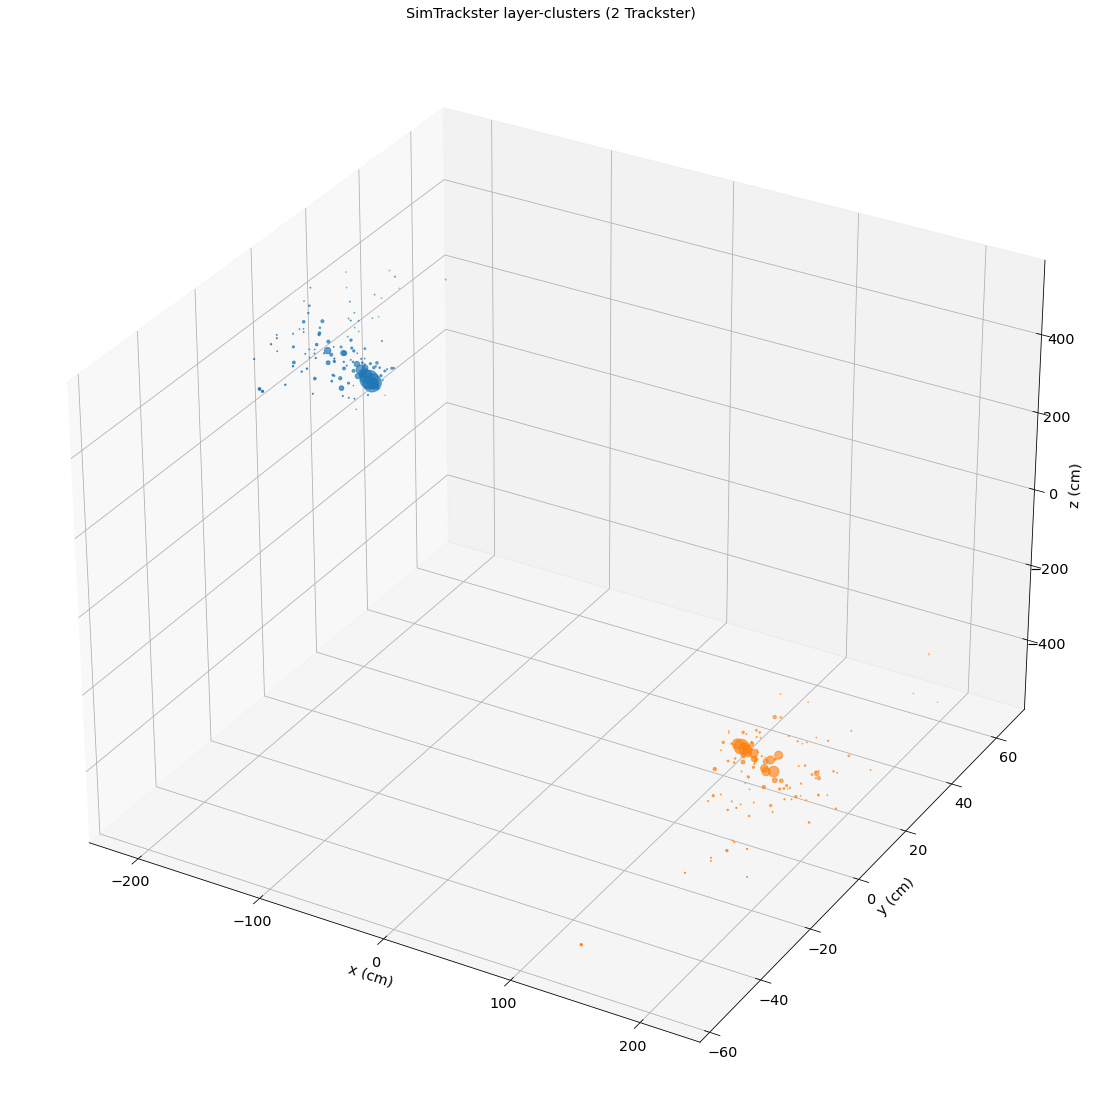

In [143]:
eid = 0

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid], vy[eid], vz[eid], ve[eid]):
    ax1.scatter(x, y, z, s=8*e)

ax1.set_title(f"SimTrackster layer-clusters ({len(vx[eid])} Trackster)")
plt.show()

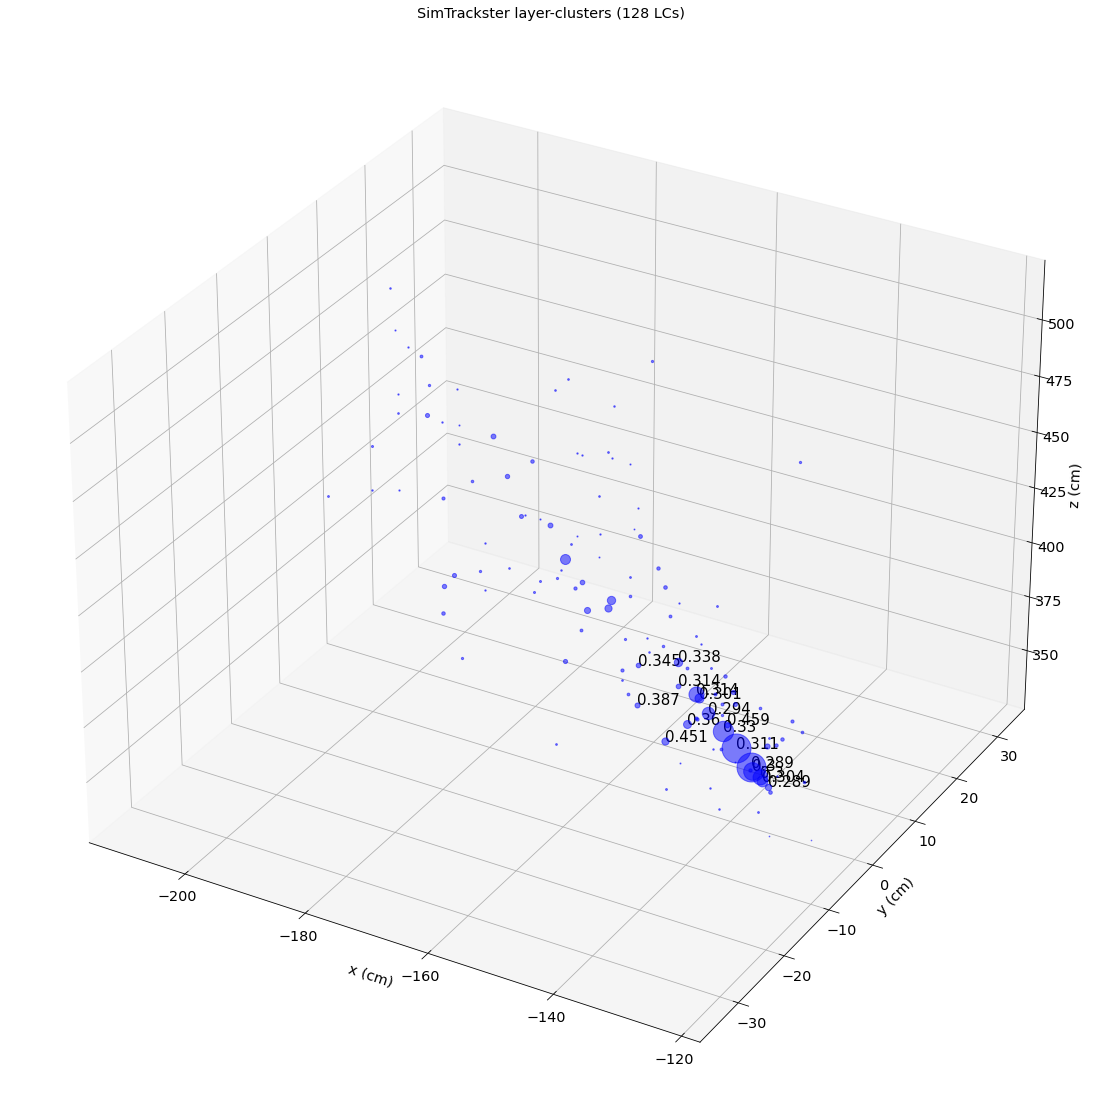

In [144]:
eid = 0
tr_id = 0

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e, t in zip(vx[eid][tr_id], vy[eid][tr_id], vz[eid][tr_id], ve[eid][tr_id], vt[eid][tr_id]):
    ax1.scatter(x, y, z, s=20*e, c='b', alpha=0.5)
    if t > -99:
        ax1.text(x,y,z, f"{t:.3}", size=15)

ax1.set_title(f"SimTrackster layer-clusters ({len(vx[eid][tr_id])} LCs)")
plt.show()

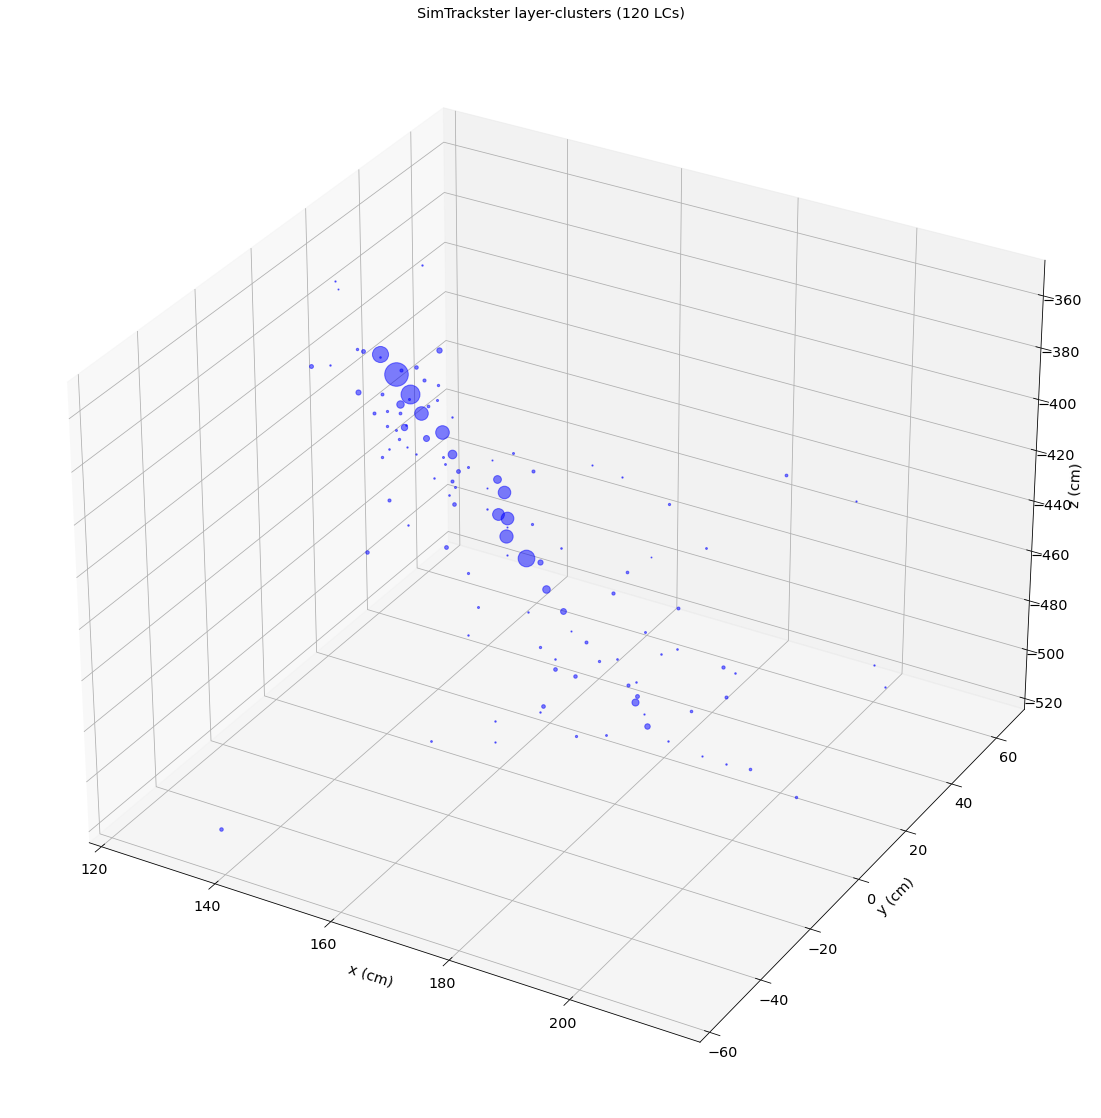

In [145]:
eid = 0
tr_id = 1

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid][tr_id], vy[eid][tr_id], vz[eid][tr_id], ve[eid][tr_id]):
    ax1.scatter(x, y, z, s=20*e, c='b', alpha=0.5)

ax1.set_title(f"SimTrackster layer-clusters ({len(vx[eid][tr_id])} LCs)")
plt.show()

In [175]:
def find_dist_to_closest_edge_set(point, edges):
    """
    point: np.array (x,y,z)
    edges: set
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    point = np.array(point)
    
    for (segment_start, segment_end) in edges:
        
        segment_start, segment_end = np.array(segment_start), np.array(segment_end)
        dist, closest_point_tmp, closest_endpoint_tmp = distance_point_to_segment_set(point, segment_start, segment_end)
        
        if dist < min_dist:
            min_dist = dist
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            
    return min_dist, min_edge, closest_point, closest_endpoint

def distance_point_to_segment_set(point, segment_start, segment_end):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        
        return np.linalg.norm(point_vector), segment_start, segment_start
    elif projection > 1:
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint

def create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev, tr_id, DST_THR=2.5, bubble_size=10, 
                                   NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.01, MIN_EDGE_LEN=1, PCA_NEIGHBOUR_THR=2, 
                                  secondary_edges = False):
    # Project the poits on pca
    edges, nodes = set(), set()
    covered_nodes = set()
    covered_node_idx = []
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    vxt = vx[ev][tr_id]
    vyt = vy[ev][tr_id]
    vzt = vz[ev][tr_id]
    vet = ve[ev][tr_id]
    vit = vi[ev][tr_id]
    
    bxt = bx[ev][tr_id]
    byt = by[ev][tr_id]
    bzt = bz[ev][tr_id]
    bet = be[ev][tr_id]
    
    #ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="m", zorder=-5)  

    # Get distances between the LCs
    dist_matrix = distance_matrix(vxt, vyt, vzt)
    # Calculate PCA
    pca = WPCA(n_components=3)    
    positions = np.array((vxt, vyt, vzt)).T

    vet_array = np.array(vet).reshape(-1,1)
    vet_array = np.tile(vet_array,(1, 3))

    pca.fit(positions, weights = vet_array)
    component = pca.components_[0]
    
    # Barycenter
    b_coord = np.array([bxt, byt, bzt])
    edges.add((tuple(b_coord), tuple(b_coord)))
    nodes.add(tuple(b_coord))
    ax.scatter(bxt, byt, bzt, s=10, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

    segment_end = np.array([bxt+component[0],
                            byt+component[1],
                            bzt+component[2]])

    data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]
    # sorted by energy
    data = sorted(data, key=lambda a: -a[3])

    # project each LC to the principal component
    min_p, max_p = b_coord, b_coord
    max_en = max(vet)
    num_lc_above_th = len(vxt[vet > 2*ENERGY_RATIO_THR*max_en])
    
    small_trackster = False
    if max_en < 1 or num_lc_above_th < 5:
        # If maximum energy of the LCs is lower than 2 GeV or number of layer clusters with at least a ENERGY_RATIO_THR of the maximum energy is less than 5
        small_trackster = True
        print("Small trackster")

    # try create main edges
    for x,y,z,e,i,j in data:

        point = np.array([x, y, z])
        dist, closest_point = project_lc_to_pca(point, b_coord, segment_end)
        
        if e/max_en > ENERGY_RATIO_THR and dist < PCA_NEIGHBOUR_THR:
            # limiting the PCA length
            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point  
                
#         ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="m", zorder=-5)   

    
    if np.linalg.norm(min_p-max_p) > 0.5:
    
        if not np.allclose(min_p, b_coord, atol=0.1):
            edges.add((tuple(min_p), tuple(b_coord)))
            nodes.add(tuple(min_p))
            ax.plot([bxt, min_p[0]], [byt, min_p[1]], [bzt, min_p[2]], c='red')    

        if not np.allclose(max_p, b_coord, atol=0.1):
            edges.add((tuple(max_p), tuple(b_coord)))
            nodes.add(tuple(max_p))
            ax.plot([bxt, max_p[0]], [byt, max_p[1]], [bzt, max_p[2]], c='green')
    else:
        min_p, max_p = b_coord, b_coord
        
        
    #Build secondary edges
    for x,y,z,e,i,j in data:
        
        if e / max_en > ENERGY_RATIO_THR:
            # and not covered by any edge
            point = np.array([x, y, z])
            min_dist, min_edge, closest_point_edge, closest_endpoint =  find_dist_to_closest_edge_set(point, edges)
            #print(min_dist)
            
            if min_dist < DST_THR:
                # LC covered by some edge already
                ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="green", zorder=-5)
                covered_nodes.add((x, y, z))
                covered_node_idx.append(j)  
                continue
            else:
                ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="black", zorder=-5)
                pass

            if not small_trackster and secondary_edges:
                # find neares higher
                # go through all points, if the point is within the Neighbour_threshold
                distances = dist_matrix[j]
                indices = np.argsort(distances)

                for idx in indices:

                    if idx in covered_node_idx and distances[idx] < NEIGHBOUR_THR and vet[idx] > e and abs(vzt[idx]) < abs(z):
                        # found the nearest higher
                        # create an edge - to projection of the nearest higher to the pca
                        #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                        #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                        nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                        
                        # TODO: check that it lies on the axis!!!!!!!!!!!!!!!
                        dist, closest_point = project_lc_to_pca(nearest_higher, b_coord, segment_end)

                        if not np.allclose(closest_point, point, atol=0.1):
                            edges.add((tuple(closest_point), tuple(point)))
                            nodes.add(tuple(closest_point))
                            nodes.add(tuple(point))
                        ax.plot([closest_point[0], x], [closest_point[1], y], [closest_point[2], z], c='blue')

                        break
        else:
            # if low energy
            pass
            ax.scatter(x, y, z, s=e*bubble_size, alpha=0.2, c="blue", zorder=-5)
    
    edges.remove((tuple(b_coord), tuple(b_coord)))
    set_axes_equal(ax)
    plt.show()
    return edges, nodes, covered_node_idx

In [176]:
%matplotlib widget
eid = 0
# create internal edges per each trackster
all_event_edges, all_event_nodes, covered_node_idxs = [], [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes, covered_node_idx = create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev=eid,
                                                                tr_id=tr_id, bubble_size=150, secondary_edges = True)
    print(internal_trackster_edges)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)
    covered_node_idxs.append(covered_node_idx)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{((-138.57088179543086, -4.689187261796906, 374.17167419084205), (-140.31198120117188, 0.4491671621799469, 380.58599853515625)), ((-165.23593825592636, -7.256520762664236, 447.1882841320554), (-163.08660888671875, -30.59446907043457, 455.5059814453125)), ((-154.8428263444501, -6.255863425668652, 418.72894823528304), (-155.98097229003906, -10.29640007019043, 424.5260009765625)), ((-165.23593825592636, -7.256520762664236, 447.1882841320554), (-176.87710571289062, -2.836475133895874, 471.95599365234375)), ((-148.0790699844533, -5.604643417173626, 400.2078338844864), (-149.3608856201172, -11.553841590881348, 405.8059997558594)), ((-159.1782583748892, -6.673282376533036, 430.6006106846838), (-148.7028350830078, -4.868013381958008, 439.0559997558594)), ((-130.2255686158668, -3.885693665866736, 351.3198014347408), (-140.80233764648438, -4.904033660888672, 380.28204345703125)), ((-171.3342400871495, -7.843670263468589, 463.88719218701834), (-185.0408172607422, -6.001169681549072, 480.180999755

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{((148.4194288723285, 7.7065799942110145, -412.2886217305478), (137.84243774414062, 4.601821422576904, -418.4159851074219)), ((146.2496482873545, 7.4023338752336345, -406.03978807538215), (139.81826782226562, 6.6722211837768555, -412.1109924316406)), ((146.2496482873545, 7.4023338752336345, -406.03978807538215), (138.48748779296875, 11.479798316955566, -412.1109924316406)), ((137.37161773347162, 6.157458536737691, -380.4716101218698), (131.56707763671875, 11.419936180114746, -386.8909912109375)), ((150.45772743398553, 7.992389735064948, -418.15879530457784), (148.18797302246094, 8.621580123901367, -424.72100830078125)), ((137.37161773347162, 6.157458536737691, -380.4716101218698), (150.11508178710938, 7.9443440437316895, -417.1719970703125)), ((155.04439533566295, 8.635531220331853, -431.3681146927007), (166.19049072265625, 2.1164164543151855, -439.0559997558594)), ((141.7954175904111, 6.777762703401915, -393.2118796316973), (135.6912078857422, 9.586593627929688, -399.5010070800781)), 

In [178]:
%matplotlib widget
eid = 0
# create internal edges per each trackster
all_event_edges, all_event_nodes, covered_node_idxs = [], [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes, covered_node_idx = create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, ev=eid,
                                                                tr_id=tr_id, bubble_size=150, secondary_edges = False)
    print(internal_trackster_edges)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)
    covered_node_idxs.append(covered_node_idx)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{((-130.2255686158668, -3.885693665866736, 351.3198014347408), (-140.80233764648438, -4.904033660888672, 380.28204345703125)), ((-171.3342400871495, -7.843670263468589, 463.88719218701834), (-140.80233764648438, -4.904033660888672, 380.28204345703125))}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{((166.36290875843324, 10.222610487847962, -463.96473210758916), (150.11508178710938, 7.9443440437316895, -417.1719970703125)), ((137.37161773347162, 6.157458536737691, -380.4716101218698), (150.11508178710938, 7.9443440437316895, -417.1719970703125))}


In [198]:
import plotly.express as px
import pandas as pd

df_event = pd.DataFrame()

eid = 0
tr_id = 0

# for tr_id in range(len(bx[eid])):
#     create_tr_skeletons_single_pca(vx, vy, vz, ve, vi, bx, by, bz, eid, tr_id)
trackster_ids = [[str(i)]*len(j) for i, j in enumerate(vi[eid])]
trackster_ids = [item for sublist in trackster_ids for item in sublist]
df_event['tr_id'] = trackster_ids 

df_event['lc_id'] = ak.flatten(vi[eid])
df_event['x'] = ak.flatten(vx[eid])
df_event['y'] = ak.flatten(vy[eid])
df_event['z'] = ak.flatten(vz[eid])

# Calculating time by projections
times = []
for tr_i in range(len(vi[eid])):
    segment_start = np.array(list(all_event_edges[tr_i])[0][0])
    segment_end = np.array(list(all_event_edges[tr_i])[0][1])
    covered_nodes_idx = covered_node_idxs[tr_i]
    
    for x, y, z, t in zip(vx[eid][tr_i], vy[eid][tr_i], vz[eid][tr_i], vt[eid][tr_i]):
        
        if t <= -99:
            point = np.array([x,y,z])
            dist, proj = project_lc_to_pca(point, segment_start, segment_end)
            # find closest PCA neighbour with time info
            # go through all the covered nodes, while also checking they contain the time info
            
            extrapolated_time = 99999
            min_dist = 99999
            neighbour_time = None
            neighbour_i = None
            speed_light = 299792458 / 1e-7 #cm/ns 
            
            for n_x, n_y, n_z, n_t, n_i in zip(vx[eid][tr_i][covered_nodes_idx], vy[eid][tr_i][covered_nodes_idx],
                                          vz[eid][tr_i][covered_nodes_idx], vt[eid][tr_i][covered_nodes_idx], covered_nodes_idx):
                #print(n_t)
                if n_t <= -98:
                    #print(n_t)
                    continue
                # calculate distance between the point and neighbour
                _, n_proj = project_lc_to_pca(np.array([n_x, n_y, n_z]), segment_start, segment_end)
                
                dist_n = np.linalg.norm(proj - n_proj)
                if dist_n < min_dist:
                    min_dist = dist
                    neighbour_i = n_i
                    neighbour_time = n_t
            
            extrapolated_time = neighbour_time + dist_n / speed_light
            
            times.append(extrapolated_time)
            #print(neighbour_time, dist)
            #print(extrapolated_time)
            #print("---------------")
        else:
            times.append(t)
    
df_event['time'] = times
df_event['energy'] = ak.flatten(ve[eid])
df_event = df_event[df_event["time"] > -99]

if tr_id!=-1:
    df_event = df_event.loc[df_event["tr_id"] == str(tr_id)]
    #print(df_event.head())

df = px.data.gapminder()

In [199]:
df_event

tr_id  lc_id           x          y           z      time     energy
0       0    342 -136.205765  -4.366139  367.976013  0.311487  42.179970
1       0    334 -133.866882  -4.317561  361.132996  0.289383  41.927994
2       0    378 -138.288666  -4.510900  374.281006  0.329747  20.702541
3       0    319 -133.534866  -4.394214  360.139008  0.299731  15.607418
4       0    423 -142.701584  -4.375359  386.890991  0.314110  11.407395
..    ...    ...         ...        ...         ...       ...        ...
123     0    327 -143.241089  -6.973895  360.139008  0.303837   0.056402
124     0    509 -165.448013  12.657930  411.915985  0.338151   0.053156
125     0    302 -137.440994  -2.894458  357.751007  0.303837   0.051396
126     0    326 -123.443993 -14.878430  360.139008  0.289040   0.029369
127     0    254 -124.388123  -3.910872  335.377014  0.311487   0.023638

[128 rows x 7 columns]

In [204]:
import plotly.graph_objects as go

dataset = df_event
margin = 5
size_res = 2

years = dataset['time'].unique()
years = sorted(years)
print(years)

# make list of continents
continents = []
for continent in dataset["tr_id"]:
    if continent not in continents:
        continents.append(continent)

        
# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# fill in most of layout
#fig_dict["layout"]["xaxis"] = {"range":[dataset['x'].min(), dataset['x'].max()], "title": "x [cm]"}
#fig_dict["layout"]["yaxis"] = {"range":[dataset['y'].min(), dataset['y'].max()], "title": "y [cm]"}
#fig_dict["layout"]["zaxis"] = {"range":[dataset['z'].min(), dataset['z'].max()], "title": "z [cm]"}

fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": True},
                                "fromcurrent": True, "transition": {"duration": 0,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 500, "redraw": True},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        #"pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Time:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 0, "easing": "cubic-in-out"},
    #"pad": {"b": 10, "t": 50},
    #"len": 0.9,
    #"x": 0.1,
    #"y": 0,
    "steps": []
}
min_en = dataset['energy'].min() / size_res

# make data
year = min(years)
for continent in continents:
    dataset_by_year = dataset[dataset["time"] <= year]
    dataset_by_year_and_cont = dataset_by_year[
        dataset_by_year["tr_id"] == continent]

    data_dict = {
        "x": list(dataset_by_year_and_cont["x"]),
        "y": list(dataset_by_year_and_cont["y"]),
        "z": list(dataset_by_year_and_cont["z"]),
        "mode": "markers",
        "marker": {
            "sizemode": "area",
            "sizeref": min_en,
            "size": list(dataset_by_year_and_cont["energy"])
        },
        "name": continent
    }
    fig_dict["data"].append(go.Scatter3d(data_dict))

#print(fig_dict["data"])

# make frames
for year in years:
    frame = {"data": [], "name": str(year)}
    for continent in continents:
        
        dataset_by_year = dataset[dataset["time"] <= year]
        dataset_by_year_and_cont = dataset_by_year[
            dataset_by_year["tr_id"] == continent]

        data_dict = {
            "x": list(dataset_by_year_and_cont["x"]),
            "y": list(dataset_by_year_and_cont["y"]),
            "z": list(dataset_by_year_and_cont["z"]),
            "mode": "markers",
            "marker": {
                "sizemode": "area",
                "sizeref": min_en,
                "size": list(dataset_by_year_and_cont["energy"])
            },
            "name": continent
        }
        
        frame["data"].append(go.Scatter3d(data_dict))

    #print(frame)
    fig_dict["frames"].append(frame)
    
    
    slider_step = {"args": [
        [year],
        {"frame": {"duration": 500, "redraw": True},
         "mode": "immediate",
         "transition": {"duration": 0}}
    ],
        "label": str(year),
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)
    
#print(fig_dict["frames"][1]['data'])

# adding a line
dataset_by_year = dataset[dataset["time"] <= max(years)]
dataset_by_year_and_cont = dataset_by_year[
    dataset_by_year["tr_id"] == continent]

# data_dict = {
#     "x": list(dataset_by_year_and_cont["x"]),
#     "y": list(dataset_by_year_and_cont["y"]),
#     "z": list(dataset_by_year_and_cont["z"]),
#     "mode": "markers",
#     "marker": {
#         "sizemode": "area",
#         "sizeref": min_en,
#         "size": list(dataset_by_year_and_cont["energy"])
#     },
#     "name":  continent
# }

x = [i for (i,j,k) in internal_trackster_nodes]
y = [j for (i,j,k) in internal_trackster_nodes]
z = [k for (i,j,k) in internal_trackster_nodes]

data=go.Scatter3d(
    x=x, y=y, z=z,
    marker=dict(
        size=4,
        color=z,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    ))

frame["data"].append(data)

fig_dict["frames"].append(frame)


slider_step = {"args": [
    [year],
    {"frame": {"duration": 500, "redraw": True},
     "mode": "immediate",
     "transition": {"duration": 0}}
],
    "label": str(99),
    "method": "animate"}
sliders_dict["steps"].append(slider_step)




fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.update_layout(
    scene = dict(
        xaxis = dict(range=[dataset['x'].min() - margin, dataset['x'].max() + margin], autorange=False),
        yaxis = dict(range=[dataset['y'].min() - margin, dataset['y'].max() + margin], autorange=False),
        zaxis = dict(range=[dataset['z'].min() - margin, dataset['z'].max() + margin], autorange=False)),
        xaxis_autorange=False, yaxis_autorange=False, width=1200, height=1200, scene_aspectmode="cube", title = go.layout.Title(text="Event"), title_x = 0.5)


fig.show()

[0.28903988003730774, 0.28903988003731795, 0.289039880037319, 0.2890398800373204, 0.289039880037321, 0.2890398800373217, 0.28938281536102295, 0.2941878139972687, 0.2941878139972732, 0.29418781399727334, 0.29418781399727373, 0.2941878139972744, 0.2997306287288666, 0.29973062872887557, 0.30026981234550476, 0.30026981234551436, 0.30026981234551536, 0.30103281140327454, 0.30383679270744324, 0.3038367927074537, 0.303836792707454, 0.3038367927074544, 0.30383679270745517, 0.31148651242256165, 0.311486512422566, 0.3114865124225661, 0.31148651242256625, 0.3114865124225663, 0.3114865124225666, 0.31148651242256736, 0.3114865124225674, 0.3114865124225689, 0.311486512422569, 0.31148651242256975, 0.31148651242256986, 0.31148651242257086, 0.31148651242257097, 0.3114865124225717, 0.31148651242257225, 0.3114865124225728, 0.31148651242257286, 0.31148651242257386, 0.3114865124225739, 0.3114865124225751, 0.31148651242257525, 0.3114865124225753, 0.31148651242257636, 0.3114865124225764, 0.3114865124225765, 

In [243]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import time

eid = 0
tr_id = 0

deltaT = 0.03 # 30ps
valid_times = vt[eid][tr_id][np.where(vt[eid][tr_id]>-99)]
tmin = min(valid_times)
tmax = max(valid_times)
print(tmin, tmax)

df = pd.DataFrame({"time": np.array(vt[eid][tr_id]),
                   "x" : np.array(vx[eid][tr_id]), 
                   "y" : np.array(vy[eid][tr_id]), 
                   "z" : np.array(vz[eid][tr_id]), 
                   "e" : np.array(ve[eid][tr_id])})
df =  df[df['time']>-98]

nframes = len(df['time'])
times = np.linspace(tmin, tmax, nframes)

def update_graph(num):
    #print(num)
    #condition = np.where((CP_vt[eid][tr_id]<=times[n]+deltaT) & (CP_vt[eid][tr_id]>=times[n]-deltaT))
    data=df[(df['time']<=times[num]+deltaT) & (df['time']>=times[num]-deltaT)]
    graph.set_offsets = (data.x, data.y, data.z)
    graph.set_sizes(data.e)
    title.set_text('3D Test, time={}'.format(num))
    time.sleep(10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

ax.set_xlim(ak.min(vx[eid][tr_id])-10, ak.max(vx[eid][tr_id])+10)
ax.set_ylim(ak.min(vy[eid][tr_id])-10, ak.max(vy[eid][tr_id])+10)
ax.set_zlim(ak.min(vz[eid][tr_id])-10, ak.max(vz[eid][tr_id])+10)

data=df[(df['time']<=times[0]+deltaT) & (df['time']>=times[0]-deltaT)]
graph = ax.scatter(data.x, data.y, data.z, s=20*data.e)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, nframes, 
                               interval=1000, blit=True, repeat=True)

ani.save('myanimationEnergy.gif') 
plt.show()

0.28903988003730774 0.4588969349861145


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

# RANSAC skeletons

In [310]:
def fit_lineransac(points, max_iter=1000, threshold=5.):
    best_line = None
    best_inliers = []
    best_score = 0
    energy = points[:,3]
    points = points[:,:3]
    for i in range(max_iter):
        # Select 3 random points to fit the line
        sample = np.random.choice(points.shape[0], 3, replace=False)
        p1, p2, p3 = points[sample]

        # Fit the line to the 3 selected points
        v1 = p2 - p1
        v2 = p3 - p1
        line = np.cross(v1, v2)
        line = line / np.linalg.norm(line)

        # Find the inliers by computing the perpendicular distance to the line for each point
        distances = np.abs(np.dot(points - p1, line))
        #print(distances)

        inliers = np.where(distances < threshold)[0]
        score = len(inliers)

        # Update the best line if this one has more inliers
        if score > best_score:
            best_line = line
            best_inliers = inliers
            best_score = score


    # Refit the line using all the inliers
    line_points = points[best_inliers]
#     mean = np.mean(line_points, axis=0)
#     line_points = line_points - mean
    
    line_energy = energy[best_inliers].reshape((-1, 1))
    mean = np.average(line_points, weights=np.tile(line_energy, (1, 3)), axis=0)
    
    line_points = line_points * line_energy / np.sum(line_energy)
    
    line_points = line_points - mean
    _, _, v = np.linalg.svd(line_points, full_matrices=False)
    best_line_lsq = v[0]#v[-1, :]
    normal = v[-1, :]
    distances = np.abs(np.dot(points - mean, normal))
    inliers_lsq = np.where(distances < threshold)[0]

    return best_line_lsq, best_line, mean, best_inliers, inliers_lsq

In [314]:
eid = 0
tr_id = 0

points = np.array([vx[eid][tr_id], vy[eid][tr_id], vz[eid][tr_id], ve[eid][tr_id]]).T
# points = []
# for x,y,z,e in zip(vx[eid][tr_id], vy[eid][tr_id], vz[eid][tr_id], ve[eid][tr_id]):
#     if e > 2:
#         points.append([x,y,z,e])
# points = np.array(points)
        

print(points)

[[8.21903076e+01 2.18289890e+01 3.25212006e+02 1.74267256e+00]
 [8.22788467e+01 2.17778759e+01 3.26205994e+02 3.30596995e+00]
 [8.29396286e+01 2.18951511e+01 3.28269012e+02 7.21553421e+00]
 [8.32661896e+01 2.20072384e+01 3.29263000e+02 1.17325506e+01]
 [8.36892166e+01 2.20015316e+01 3.31325989e+02 1.44982252e+01]
 [8.39670334e+01 2.22288151e+01 3.32320007e+02 1.16173515e+01]
 [8.43517151e+01 2.23294773e+01 3.34382996e+02 1.22822399e+01]
 [8.46995239e+01 2.23954086e+01 3.35377014e+02 1.04025393e+01]
 [8.50935745e+01 2.22746487e+01 3.37440002e+02 9.39083290e+00]
 [8.54013443e+01 2.25590801e+01 3.38433990e+02 7.48118687e+00]
 [8.57406845e+01 2.25989170e+01 3.40497009e+02 6.30287647e+00]
 [8.62284775e+01 2.26635361e+01 3.41490997e+02 3.70400524e+00]
 [8.70594559e+01 2.29844513e+01 3.43553986e+02 3.82950830e+00]
 [8.71045456e+01 2.27526150e+01 3.44548004e+02 2.35411882e+00]
 [8.73493195e+01 2.28702507e+01 3.46610992e+02 1.45620990e+00]
 [8.79176865e+01 2.66409779e+01 3.46610992e+02 3.210541

In [329]:
line_lsq, line, mean, best_inliers, inliers_lsq = fit_lineransac(points, max_iter=1000, threshold=0.05)
print(line_lsq)
print(line)
print(mean)
print(best_inliers)
print(inliers_lsq)

[0.24428454 0.06453483 0.96755378]
[-0.22212377 -0.96982254  0.100525  ]
[ 84.60261652  22.34997215 335.09183285]
[ 0  3  5  6  7  9 10 11 13 14 25]
[ 2  3  5  7  9 10 16]


In [331]:
%matplotlib widget
size_bubble = 20

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

i = 0
for x, y, z, e in points:
    if i in inliers_lsq:
        ax1.scatter(x, y, z, c='g', alpha=0.5, s=size_bubble*e)
    else:
        ax1.scatter(x, y, z, c='b', alpha=0.5, s=size_bubble*e)
    i += 1
    
ax1.scatter(mean[0], mean[1], mean[2], s=size_bubble*max(ve[eid][tr_id]), c='r', alpha=0.5)

linepts = line_lsq * np.mgrid[-15:15:2j][:, np.newaxis]
linepts += mean
ax1.plot3D(*linepts.T)

ax1.set_title(f"SimTrackster layer-clusters ({len(vx[eid][tr_id])} LCs)")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [322]:
import numpy as np

# Generate some data that lies along a line

x = np.mgrid[-2:5:120j]
y = np.mgrid[1:9:120j]
z = np.mgrid[-5:3:120j]

data = np.concatenate((x[:, np.newaxis], 
                       y[:, np.newaxis], 
                       z[:, np.newaxis]), 
                      axis=1)

# Perturb with some Gaussian noise
data += np.random.normal(size=data.shape) * 0.4

# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = data.mean(axis=0)

# Do an SVD on the mean-centered data.
uu, dd, vv = np.linalg.svd(data - datamean)

# Now vv[0] contains the first principal component, i.e. the direction
# vector of the 'best fit' line in the least squares sense.

# Now generate some points along this best fit line, for plotting.

# I use -7, 7 since the spread of the data is roughly 14
# and we want it to have mean 0 (like the points we did
# the svd on). Also, it's a straight line, so we only need 2 points.

print(vv[0])
linepts = vv[0] * np.mgrid[-7:7:2j][:, np.newaxis]

# shift by the mean to get the line in the right place
linepts += datamean

# Verify that everything looks right.

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d

ax = m3d.Axes3D(plt.figure())
ax.scatter3D(*data.T)
ax.plot3D(*linepts.T)
plt.show()

[0.52111691 0.60802888 0.59894745]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/tmp/ipykernel_749/2260061599.py:43: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = m3d.Axes3D(plt.figure())
